In [1]:
import sys
# sys.path.append(r"Y:\Users\Yingyue\Gates_Lab_Suite-master")
sys.path.append(r"/Volumes/funkflower/Users/Yingyue/Gates_Lab_Suite-master")
from Core_Definition import *
from Auto_Algorithm import *
from Visualization import *
import os
from SPAM import *
import numpy as np
import xlsxwriter as xlsx
from scipy import optimize
import random
import math
from math import floor
import pickle
import uuid

In [2]:
import json, pickle
import qiskit
#transpiler reducinig qiskit circuit to QASM strings
from qiskit import transpile
# Use AerSimulator
from qiskit_aer import AerSimulator
from qiskit import IBMQ, QuantumCircuit, execute
from qiskit.providers.ibmq.managed import IBMQJobManager
from qiskit.extensions import UnitaryGate
from qiskit.quantum_info import Pauli, Clifford, Statevector,Operator
from qiskit.visualization import array_to_latex
from scipy.stats import sem, unitary_group
from scipy.linalg import sqrtm,expm
import qiskit.quantum_info as qi
from qiskit.quantum_info import Pauli
import pylatexenc

In [3]:
def state_init_bell_pairs(qc,n):
    for i in range (n):
        qc.Add_Gate(Quantum_Gate("HAD",i))
    for i in range (n):
        qc.Add_Gate(Quantum_Gate("CNOT",i,int(i+n)))

        
#should we set_mapping in this function? need to think about if it takes mapping into account   
def add_pauli_twirl(qc,n):
    pauliLayer = [random.choice(['I','X','Y','Z']) for j in range(n)]
    q_index=0
    for pauli in pauliLayer :
        if (pauli=="I"):
            qc.Add_Gate(Quantum_Gate("SKAX",2*n,angle=1))
        elif (pauli=="X"):
            qc.Add_Gate(Quantum_Gate("SKAX",q_index,angle=1))
        elif (pauli=="Y"):
            qc.Add_Gate(Quantum_Gate("SKAY",q_index,angle=1))
        elif (pauli=="Z"):
            qc.Add_Gate(Quantum_Gate("AZ",q_index,angle=1))
        q_index+=1
    return pauliLayer

def add_pauli_twirl_wSE(qc,n):
    pauliLayer = [random.choice(['I','X','Y','Z']) for j in range(n)]
    q_index=0
    for pauli in pauliLayer :
        if (pauli=="I"):
            qc.Add_Gate(Quantum_Gate("SKAX",2*n,angle=1))
        elif (pauli=="X"):
            qc.Add_Gate(Quantum_Gate("SKAX",q_index,angle=1))
        elif (pauli=="Y"):
            qc.Add_Gate(Quantum_Gate("SKAY",q_index,angle=1))
        elif (pauli=="Z"):
            qc.Add_Gate(Quantum_Gate("AZ",q_index,angle=1))
        
        if (q_index==(int(n/2)-1)):
            for i in range (n):
                qc.Add_Gate(Quantum_Gate("SKAX",n+i,angle=1))
        q_index+=1
    return pauliLayer
    
def add_clifford_layer(qc,n,clifford):
    if (clifford=="CNOT"):
        for i in range (floor(n/2)):
            qc.Add_Gate(Quantum_Gate("CNOT",2*i,2*i+1))
            
def bell_measurement(qc,n):
    for i in range (n-1,-1,-1):
        qc.Add_Gate(Quantum_Gate("SKAX",int(i+n),angle=1))
        qc.Add_Gate(Quantum_Gate("CNOT",i,int(i+n)))
    for i in range (n-1,-1,-1):
        qc.Add_Gate(Quantum_Gate("HAD",i))

def map_statepop_2_ibm_mapping(counts,n):
    counts_ibm_mapping=[0 for i in range (2**(2*n))]
    idx_ibm_mapping=[]
    counts_ibm_mapping_dic={}
    if len(str((2*n)))<2:
        f="00"+str(2*n)+"b"
    elif len(str((2*n)))<3:
        f="0"+str(2*n)+"b"
    else:
        raise ValueError("n is too big")
    for gates_idx in range (2**(2*n)):
        gates_idx_str=format(gates_idx,f)
        ibm_idx=0
        for i in range (2*n):
            ibm_idx+=2**(i)*int(gates_idx_str[i])
        ibm_idx_str=format(ibm_idx,f)
#         idx_ibm_mapping.append(ibm_idx_str)
        counts_ibm_mapping[ibm_idx]=counts[gates_idx]
        counts_ibm_mapping_dic[ibm_idx_str]=counts[gates_idx]
    return counts_ibm_mapping, counts_ibm_mapping_dic
        
        
#for qiskit
def prepare_bell_state_1q(circuit,index1,index2):
	circuit.h([index1])
	circuit.cx([index1],[index2])
        
def bell_measurement_1q(circuit,index1,index2): 
	# info qubit at index1
	circuit.cx([index1],[index2])
	circuit.h([index1])

def pauli_gate_1q(circuit,index,pauli=None): #For stabilizer simulator to work, cannot use Pauli class
	if pauli == 'I':
		circuit.id([index])
	elif pauli == 'Z':
		circuit.z([index])
	elif pauli == 'X':
		circuit.x([index])
	elif pauli == 'Y':
		circuit.y([index])
	else:
		assert 1==0

    
    
    

In [4]:
## Additional functions

def int_to_pauli(i,n):
    p = np.base_repr(i,base=4)
    p = '0'*(n-len(p)) + p
    p = p.replace('0','I').replace('1', 'X').replace('2', 'Y').replace('3', 'Z')
    return p

def commute(p,q):
    c = 1
    n = len(p)
    for i in range(n):
        if p[i] != 'I' and q[i] != 'I':
            if p[i] != q[i]:
                c *= -1
    return c

def fidelity_to_error(pauli_fidelity,n):
    N = 4**n
    pauli_error = {}
    for i in range(N):
        p = int_to_pauli(i,n)
        pauli_error[p] = 0
        for j in range(N):
            q = int_to_pauli(j,n)
            pauli_error[p] += pauli_fidelity[q] * commute(p,q) / N
    return pauli_error
    

from scipy.optimize import curve_fit
def rcs_fit_fun_depth1(x, alpha):
        #return a * np.exp(-alpha * x)
        return alpha ** x

def fit_EAB_depth1(X, xeb_list):
    Y = [np.mean(xeb_list[L]) for L in X]
    Yerr = [sem(xeb_list[L]) for L in X]
    #print(linregress(X,np.log(Y)))
    
    
    try:
        params, pcov = curve_fit(rcs_fit_fun_depth1, X, Y, sigma=Yerr, absolute_sigma=True, p0=[1])
        alpha = params[0]
        params_err = np.sqrt(np.diag(pcov))
        alpha_err = params_err[0]

    except RuntimeError:
        alpha = 1.0
        alpha_err = 0.0


    return alpha, alpha_err

    print(alpha, alpha_err)

In [5]:
Set_Mapping([2,3,5,4,1])
nqubit=2
C=20
results_d2=np.zeros((C,2**(2*nqubit)))
results_d4=np.zeros((C,2**(2*nqubit)))
results_d8=np.zeros((C,2**(2*nqubit)))

file=open(r"/Volumes/funkflower/Labs/Gates/AutoAlgorithms/EAB/01 10/XX23541_noSE_explicitCNOT_FT_R0627_01+10/removeFTXX23/d=2.txt", 'r')
Lines= file.readlines()
c_d2=[]
count = 0
for line in Lines:
    c_d2.append(line)
    count += 1
print (count)
count=0

file=open(r"/Volumes/funkflower/Labs/Gates/AutoAlgorithms/EAB/01 10/XX23541_noSE_explicitCNOT_FT_R0627_01+10/removeFTXX23/d=4.txt", 'r')
Lines= file.readlines()
c_d4=[]
count = 0
for line in Lines:
    c_d4.append(line)
    count += 1
print (count)
count=0

file=open(r"/Volumes/funkflower/Labs/Gates/AutoAlgorithms/EAB/01 10/XX23541_noSE_explicitCNOT_FT_R0627_01+10/removeFTXX23/d=8.txt", 'r')
Lines= file.readlines()
c_d8=[]
count = 0
for line in Lines:
    c_d8.append(line)
    count += 1
print (count)
count=0

file=open(r"/Volumes/funkflower/Labs/Gates/AutoAlgorithms/EAB/01 10/XX23541_noSE_explicitCNOT_FT_R0627_01+10/removeFTXX23/d=16.txt", 'r')
Lines= file.readlines()
c_d16=[]
count = 0
for line in Lines:
    c_d16.append(line)
    count += 1
print (count)
count=0

file=open(r"/Volumes/funkflower/Labs/Gates/AutoAlgorithms/EAB/01 10/XX23541_noSE_explicitCNOT_FT_R0627_01+10/removeFTXX23/d=32.txt", 'r')
Lines= file.readlines()
c_d32=[]
count = 0
for line in Lines:
    c_d32.append(line)
    count += 1
print (count)
count=0



20
20
20
20
20


In [6]:
filenames_d2=[]
filenames_d4=[]
filenames_d8=[]
filenames_d16=[]
filenames_d32=[]
filenames_d2_0703=[]
filenames_d4_0703=[]
filenames_d8_0703=[]
filenames_d2_rerun=[]
filenames=[]

paf_data_d2="/Volumes/funkflower/Users/Yingyue/Gates_Lab_Suite-master/PauliNoiseEstimation/data/0711/2023-07-11 EAB__d=2/"
L1=[]
filenames=[]
line_Idx="000"
line_num=""
p=0 #position indicator

#------------------------------------------read in raw data-------------------------------
for f in os.listdir(paf_data_d2):
    if (f.find("Line")!=-1):
        n=f.find("_")
        line_Idx=f[n+6:n+9]
        for i in range(3):
            if line_Idx[i]=="0":
                p+=1
            else:
                line_num=line_Idx[p:3]
                p=0
                break
        L1.append(int(line_num))
        filenames.append(f)
    else:
        print (f) #print out non datafiles just for debugging 
        continue
for Idx in range (len(filenames)):
    for i in range (len(filenames)):
        if L1[i]==Idx+1:
            filenames_d2.append(filenames[i])
            break
print (filenames_d2)




paf_data_d4="/Volumes/funkflower/Users/Yingyue/Gates_Lab_Suite-master/PauliNoiseEstimation/data/0711/2023-07-11 EAB__d=4/"
L1=[]
filenames=[]
line_Idx="000"
line_num=""
p=0 #position indicator

#------------------------------------------read in raw data-------------------------------
for f in os.listdir(paf_data_d4):
    if (f.find("Line")!=-1):
        n=f.find("_")
        line_Idx=f[n+6:n+9]
        for i in range(3):
            if line_Idx[i]=="0":
                p+=1
            else:
                line_num=line_Idx[p:3]
                p=0
                break
        L1.append(int(line_num))
        filenames.append(f)
    else:
        print (f) #print out non datafiles just for debugging 
        continue
for Idx in range (len(filenames)):
    for i in range (len(filenames)):
        if L1[i]==Idx+1:
            filenames_d4.append(filenames[i])
            break
print (filenames_d4)





paf_data_d8="/Volumes/funkflower/Users/Yingyue/Gates_Lab_Suite-master/PauliNoiseEstimation/data/0711/2023-07-11 EAB__d=8/"
L1=[]
filenames=[]
line_Idx="000"
line_num=""
p=0 #position indicator

#------------------------------------------read in raw data-------------------------------
for f in os.listdir(paf_data_d8 ):
    if (f.find("Line")!=-1):
        n=f.find("_")
        line_Idx=f[n+6:n+9]
        for i in range(3):
            if line_Idx[i]=="0":
                p+=1
            else:
                line_num=line_Idx[p:3]
                p=0
                break
        L1.append(int(line_num))
        filenames.append(f)
    else:
        print (f) #print out non datafiles just for debugging 
        continue
for Idx in range (len(filenames)):
    for i in range (len(filenames)):
        if L1[i]==Idx+1:
            filenames_d8.append(filenames[i])
            break
print (filenames_d8)



paf_data_d16="/Volumes/funkflower/Users/Yingyue/Gates_Lab_Suite-master/PauliNoiseEstimation/data/0711/2023-07-11 EAB__d=16/"
L1=[]
filenames=[]
line_Idx="000"
line_num=""
p=0 #position indicator

#------------------------------------------read in raw data-------------------------------
for f in os.listdir(paf_data_d16 ):
    if (f.find("Line")!=-1):
        n=f.find("_")
        line_Idx=f[n+6:n+9]
        for i in range(3):
            if line_Idx[i]=="0":
                p+=1
            else:
                line_num=line_Idx[p:3]
                p=0
                break
        L1.append(int(line_num))
        filenames.append(f)
    else:
        print (f) #print out non datafiles just for debugging 
        continue
for Idx in range (len(filenames)):
    for i in range (len(filenames)):
        if L1[i]==Idx+1:
            filenames_d16.append(filenames[i])
            break
print (filenames_d16)



paf_data_d32="/Volumes/funkflower/Users/Yingyue/Gates_Lab_Suite-master/PauliNoiseEstimation/data/0711/2023-07-11 EAB__d=32/"
L1=[]
filenames=[]
line_Idx="000"
line_num=""
p=0 #position indicator

#------------------------------------------read in raw data-------------------------------
for f in os.listdir(paf_data_d32 ):
    if (f.find("Line")!=-1):
        n=f.find("_")
        line_Idx=f[n+6:n+9]
        for i in range(3):
            if line_Idx[i]=="0":
                p+=1
            else:
                line_num=line_Idx[p:3]
                p=0
                break
        L1.append(int(line_num))
        filenames.append(f)
    else:
        print (f) #print out non datafiles just for debugging 
        continue
for Idx in range (len(filenames)):
    for i in range (len(filenames)):
        if L1[i]==Idx+1:
            filenames_d32.append(filenames[i])
            break
print (filenames_d32)



['2023-07-11-185411_Line_001.txt', '2023-07-11-185434_Line_002.txt', '2023-07-11-185457_Line_003.txt', '2023-07-11-190129_Line_004.txt', '2023-07-11-190153_Line_005.txt', '2023-07-11-190216_Line_006.txt', '2023-07-11-190240_Line_007.txt', '2023-07-11-190907_Line_008.txt', '2023-07-11-190931_Line_009.txt', '2023-07-11-190955_Line_010.txt', '2023-07-11-191018_Line_011.txt', '2023-07-11-232016_Line_012.txt', '2023-07-11-232040_Line_013.txt', '2023-07-11-232103_Line_014.txt', '2023-07-11-232126_Line_015.txt', '2023-07-11-232309_Line_016.txt', '2023-07-11-232332_Line_017.txt', '2023-07-11-232355_Line_018.txt', '2023-07-11-232418_Line_019.txt', '2023-07-11-232601_Line_020.txt']
['2023-07-11-200423_Line_001.txt', '2023-07-11-200451_Line_002.txt', '2023-07-11-200519_Line_003.txt', '2023-07-11-202731_Line_004.txt', '2023-07-11-202442_Line_005.txt', '2023-07-11-202824_Line_006.txt', '2023-07-11-203010_Line_007.txt', '2023-07-11-203037_Line_008.txt', '2023-07-11-203104_Line_009.txt', '2023-07-11-

In [9]:
a=Quantum_State(5)
a_s=Quantum_State(5)
b_c=Quantum_Circuit(5,"qc")

a_0703=Quantum_State(5)
a_rerun=Quantum_State(5)

spam1=SPAM_Operator(5)
spam1.Import("/Volumes/funkflower/Users/Yingyue/Gates_Lab_Suite-master/PauliNoiseEstimation/data/0711/SPAM1/SPAM1.csv")

spam2=SPAM_Operator(5)
spam2.Import("/Volumes/funkflower/Users/Yingyue/Gates_Lab_Suite-master/PauliNoiseEstimation/data/0711/SPAM2/SPAM2.csv")


['2024-01-15-165420_Line_001.txt', '2024-01-15-165444_Line_002.txt', '2024-01-15-170232_Line_003.txt', '2024-01-15-165531_Line_004.txt', '2024-01-15-165555_Line_005.txt', '2024-01-15-165843_Line_006.txt', '2024-01-15-165906_Line_007.txt', '2024-01-15-165930_Line_008.txt', '2024-01-15-165953_Line_009.txt', '2024-01-15-170017_Line_010.txt', '2024-01-15-203737_Line_011.txt', '2024-01-15-203801_Line_012.txt', '2024-01-15-203824_Line_013.txt', '2024-01-15-203847_Line_014.txt', '2024-01-15-203911_Line_015.txt', '2024-01-15-204012_Line_016.txt', '2024-01-15-204036_Line_017.txt', '2024-01-15-204100_Line_018.txt', '2024-01-15-204123_Line_019.txt', '2024-01-15-204146_Line_020.txt']
counts: [4, 33, 39, 1624, 2, 6, 34, 91, 1, 29, 5, 105, 2, 5, 6, 14]
counts_ibm_mapping_dic: {'0000': 4, '1000': 33, '0100': 39, '1100': 1624, '0010': 2, '1010': 6, '0110': 34, '1110': 91, '0001': 1, '1001': 29, '0101': 5, '1101': 105, '0011': 2, '1011': 5, '0111': 6, '1111': 14}
HAD2:RX+51:HAD3:RX+41:RY+22:FTXA250.250

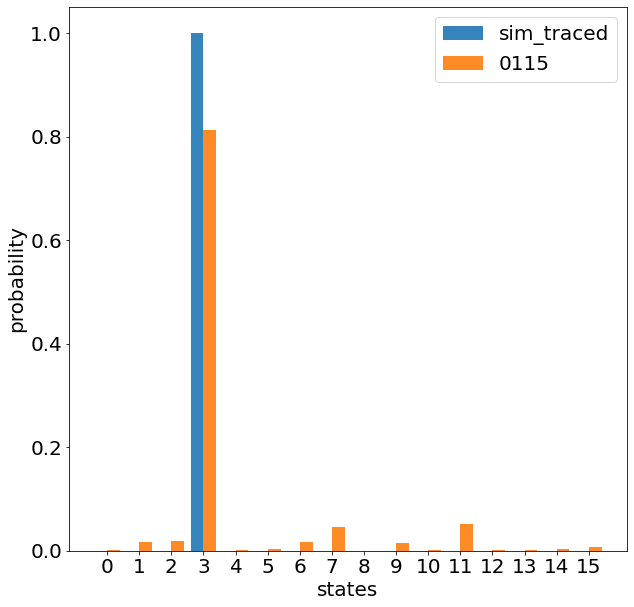

counts: [130, 25, 4, 0, 1737, 23, 19, 2, 4, 0, 4, 2, 36, 0, 14, 0]
counts_ibm_mapping_dic: {'0000': 130, '1000': 25, '0100': 4, '1100': 0, '0010': 1737, '1010': 23, '0110': 19, '1110': 2, '0001': 4, '1001': 0, '0101': 4, '1101': 2, '0011': 36, '1011': 0, '0111': 14, '1111': 0}
HAD2:RX+51:HAD3:RX+41:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:RY+21:FTXA230.2500+:RY+21:FTXA230.2500+:RX+21:RY+31:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



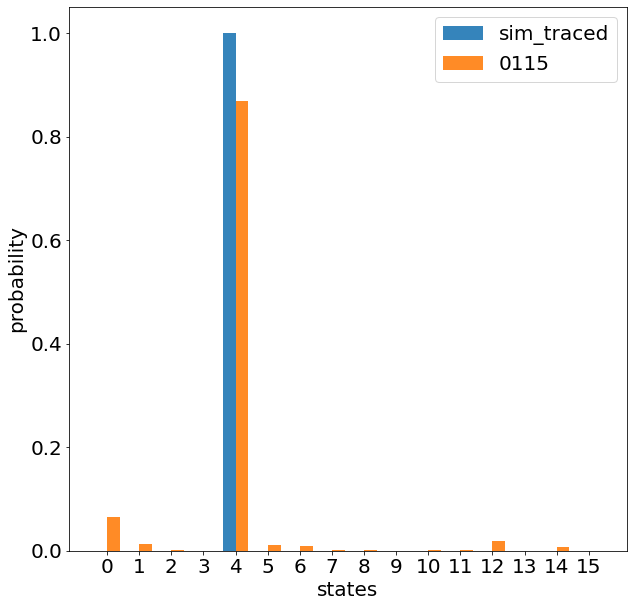

counts: [3, 5, 29, 105, 2, 41, 40, 1701, 1, 0, 0, 2, 1, 36, 2, 32]
counts_ibm_mapping_dic: {'0000': 3, '1000': 5, '0100': 29, '1100': 105, '0010': 2, '1010': 41, '0110': 40, '1110': 1701, '0001': 1, '1001': 0, '0101': 0, '1101': 2, '0011': 1, '1011': 36, '0111': 2, '1111': 32}
HAD2:RX+51:HAD3:RX+41:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:AZ2+1.0000:RY+31:FTXA230.2500+:RX+31:FTXA230.2500+:AZ2+1.0000:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



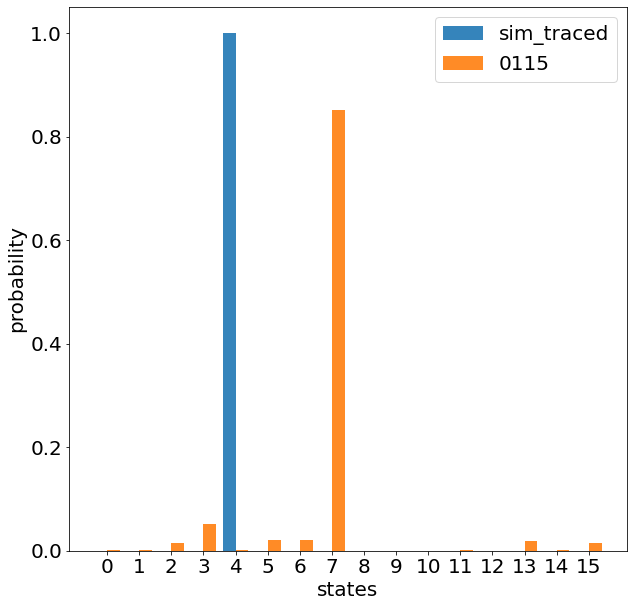

counts: [1, 54, 6, 39, 3, 6, 3, 5, 67, 1632, 1, 35, 41, 101, 3, 3]
counts_ibm_mapping_dic: {'0000': 1, '1000': 54, '0100': 6, '1100': 39, '0010': 3, '1010': 6, '0110': 3, '1110': 5, '0001': 67, '1001': 1632, '0101': 1, '1101': 35, '0011': 41, '1011': 101, '0111': 3, '1111': 3}
HAD2:RX+51:HAD3:RX+41:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:RY+21:RY+31:FTXA230.2500+:RY+21:RX+31:FTXA230.2500+:RY+21:AZ3+1.0000:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



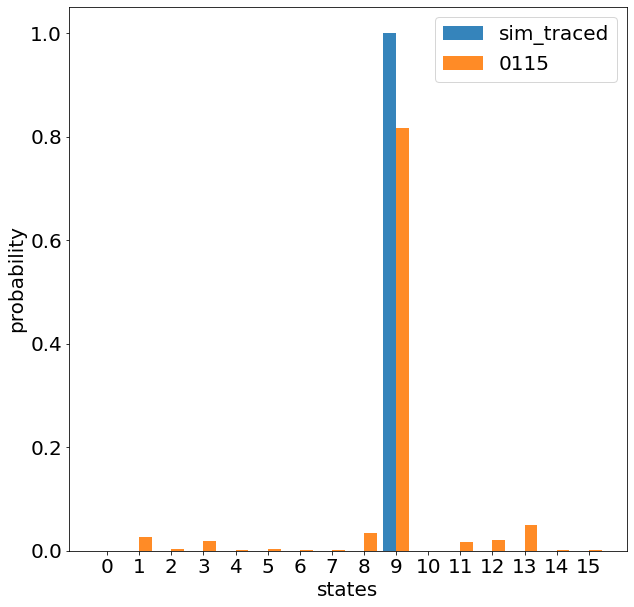

counts: [2, 27, 6, 133, 0, 1, 4, 7, 3, 33, 35, 1662, 1, 2, 30, 54]
counts_ibm_mapping_dic: {'0000': 2, '1000': 27, '0100': 6, '1100': 133, '0010': 0, '1010': 1, '0110': 4, '1110': 7, '0001': 3, '1001': 33, '0101': 35, '1101': 1662, '0011': 1, '1011': 2, '0111': 30, '1111': 54}
HAD2:RX+51:HAD3:RX+41:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:AZ2+1.0000:AZ3+1.0000:FTXA230.2500+:RY+21:FTXA230.2500+:RY+21:AZ3+1.0000:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



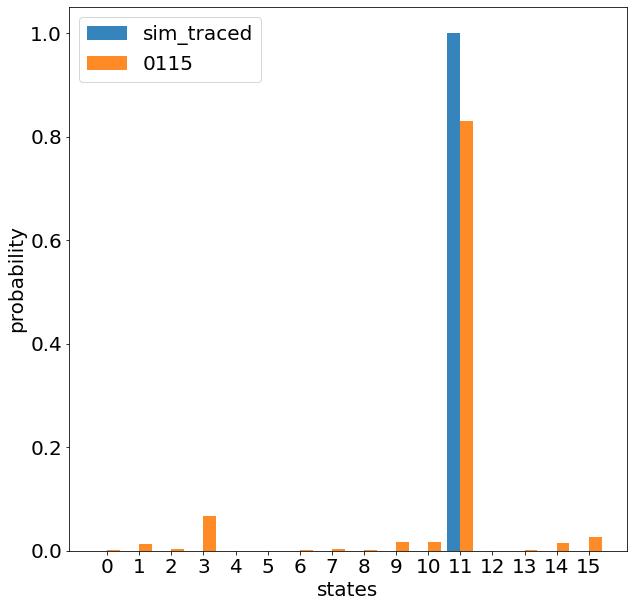

counts: [39, 43, 1, 0, 32, 1768, 0, 42, 2, 2, 0, 0, 0, 50, 1, 20]
counts_ibm_mapping_dic: {'0000': 39, '1000': 43, '0100': 1, '1100': 0, '0010': 32, '1010': 1768, '0110': 0, '1110': 42, '0001': 2, '1001': 2, '0101': 0, '1101': 0, '0011': 0, '1011': 50, '0111': 1, '1111': 20}
HAD2:RX+51:HAD3:RX+41:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:RY+21:AZ3+1.0000:FTXA230.2500+:RX+21:AZ3+1.0000:FTXA230.2500+:RY+21:AZ3+1.0000:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



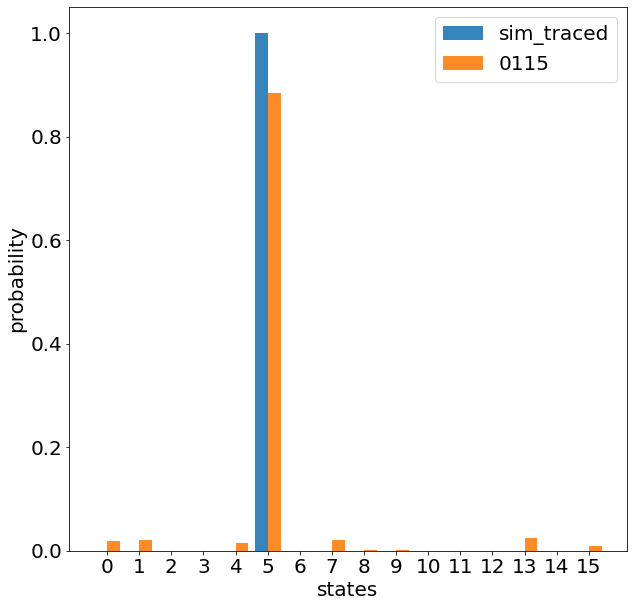

counts: [0, 3, 5, 20, 2, 28, 5, 138, 0, 5, 45, 85, 6, 46, 36, 1576]
counts_ibm_mapping_dic: {'0000': 0, '1000': 3, '0100': 5, '1100': 20, '0010': 2, '1010': 28, '0110': 5, '1110': 138, '0001': 0, '1001': 5, '0101': 45, '1101': 85, '0011': 6, '1011': 46, '0111': 36, '1111': 1576}
HAD2:RX+51:HAD3:RX+41:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:AZ2+1.0000:FTXA230.2500+:RX+21:RY+31:FTXA230.2500+:RX+21:RX+31:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



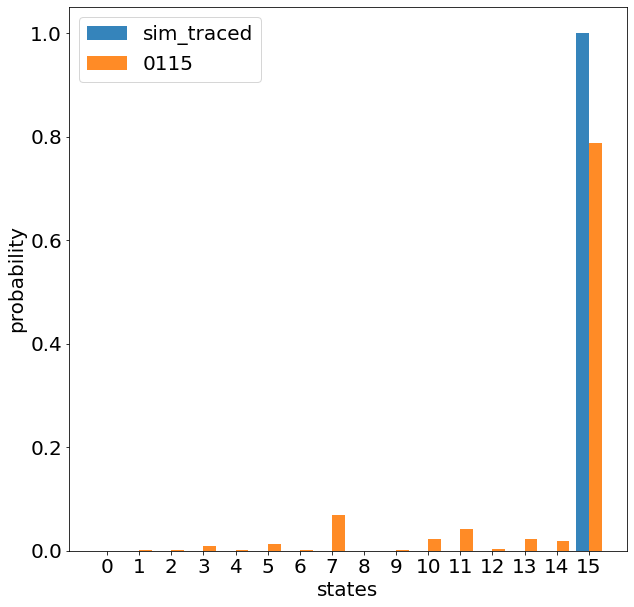

counts: [2, 29, 1, 138, 1, 1, 3, 3, 2, 53, 30, 1657, 2, 2, 28, 48]
counts_ibm_mapping_dic: {'0000': 2, '1000': 29, '0100': 1, '1100': 138, '0010': 1, '1010': 1, '0110': 3, '1110': 3, '0001': 2, '1001': 53, '0101': 30, '1101': 1657, '0011': 2, '1011': 2, '0111': 28, '1111': 48}
HAD2:RX+51:HAD3:RX+41:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:RY+21:FTXA230.2500+:RX+21:FTXA230.2500+:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



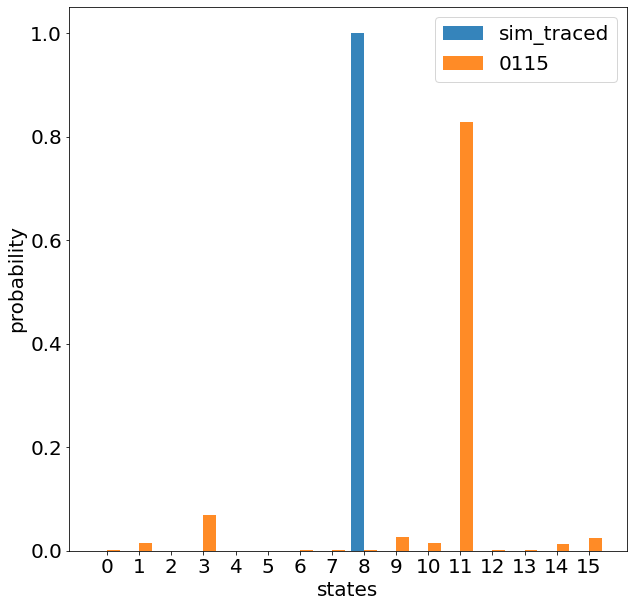

counts: [0, 26, 6, 164, 2, 0, 3, 5, 2, 46, 30, 1644, 1, 1, 25, 45]
counts_ibm_mapping_dic: {'0000': 0, '1000': 26, '0100': 6, '1100': 164, '0010': 2, '1010': 0, '0110': 3, '1110': 5, '0001': 2, '1001': 46, '0101': 30, '1101': 1644, '0011': 1, '1011': 1, '0111': 25, '1111': 45}
HAD2:RX+51:HAD3:RX+41:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:RY+21:AZ3+1.0000:FTXA230.2500+:RX+21:FTXA230.2500+:AZ3+1.0000:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



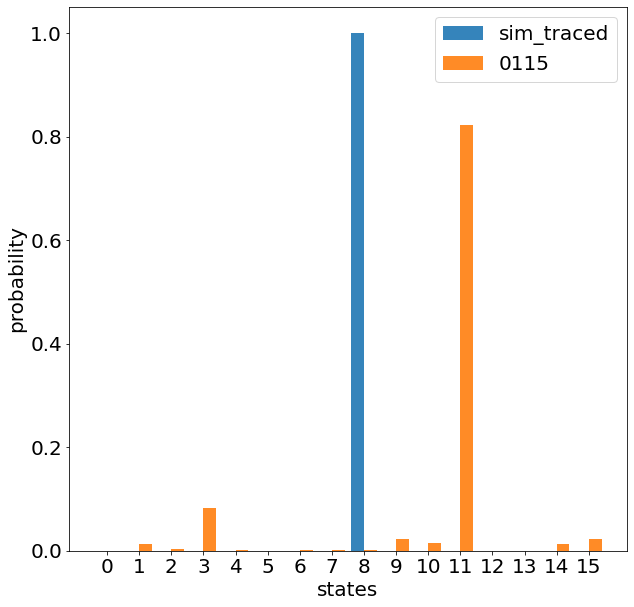

counts: [8, 3, 12, 72, 4, 25, 10, 225, 6, 9, 29, 144, 4, 33, 28, 1388]
counts_ibm_mapping_dic: {'0000': 8, '1000': 3, '0100': 12, '1100': 72, '0010': 4, '1010': 25, '0110': 10, '1110': 225, '0001': 6, '1001': 9, '0101': 29, '1101': 144, '0011': 4, '1011': 33, '0111': 28, '1111': 1388}
HAD2:RX+51:HAD3:RX+41:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:RY+21:RY+31:FTXA230.2500+:FTXA230.2500+:RX+21:RX+31:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



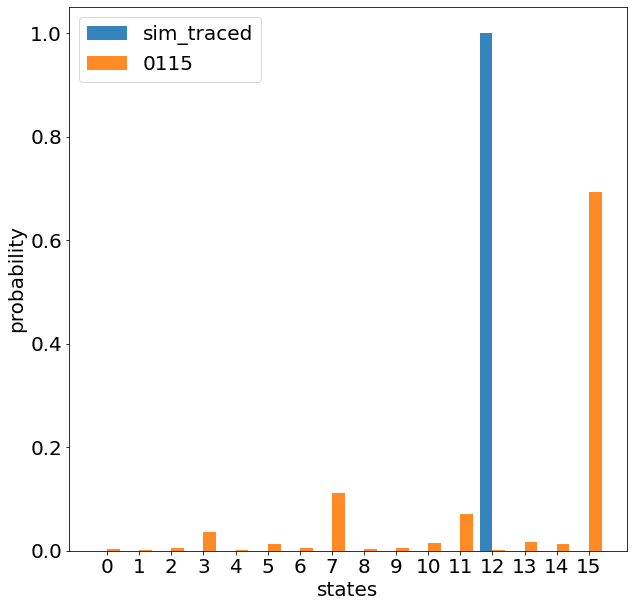

counts: [24, 1615, 2, 28, 44, 92, 1, 3, 1, 143, 2, 17, 3, 20, 1, 4]
counts_ibm_mapping_dic: {'0000': 24, '1000': 1615, '0100': 2, '1100': 28, '0010': 44, '1010': 92, '0110': 1, '1110': 3, '0001': 1, '1001': 143, '0101': 2, '1101': 17, '0011': 3, '1011': 20, '0111': 1, '1111': 4}
HAD2:RX+51:HAD3:RX+41:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:RX+21:AZ3+1.0000:FTXA230.2500+:RY+31:FTXA230.2500+:RX+31:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



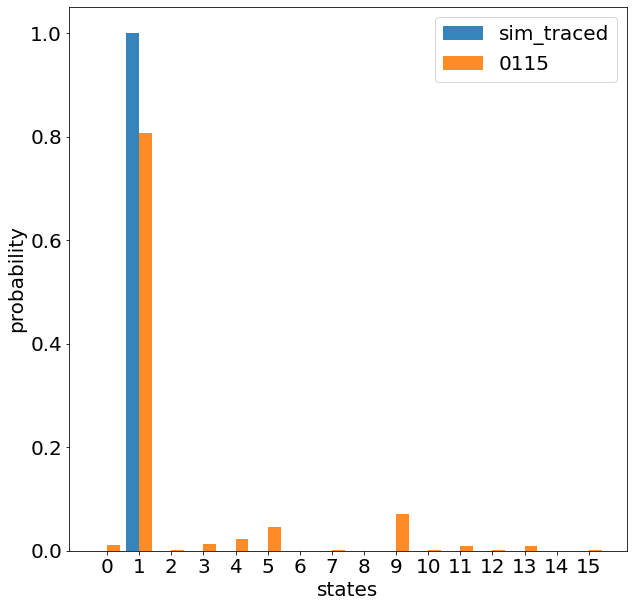

counts: [3, 0, 12, 1, 31, 1, 118, 5, 6, 2, 122, 19, 60, 2, 1583, 35]
counts_ibm_mapping_dic: {'0000': 3, '1000': 0, '0100': 12, '1100': 1, '0010': 31, '1010': 1, '0110': 118, '1110': 5, '0001': 6, '1001': 2, '0101': 122, '1101': 19, '0011': 60, '1011': 2, '0111': 1583, '1111': 35}
HAD2:RX+51:HAD3:RX+41:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:AZ2+1.0000:AZ3+1.0000:FTXA230.2500+:RX+21:AZ3+1.0000:FTXA230.2500+:RX+21:RY+31:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



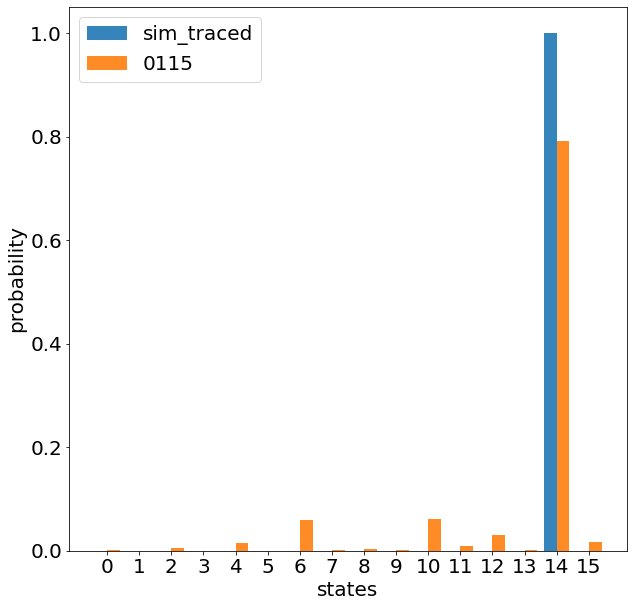

counts: [6, 7, 5, 61, 5, 38, 6, 163, 2, 7, 39, 143, 5, 22, 32, 1459]
counts_ibm_mapping_dic: {'0000': 6, '1000': 7, '0100': 5, '1100': 61, '0010': 5, '1010': 38, '0110': 6, '1110': 163, '0001': 2, '1001': 7, '0101': 39, '1101': 143, '0011': 5, '1011': 22, '0111': 32, '1111': 1459}
HAD2:RX+51:HAD3:RX+41:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:RX+21:RY+31:FTXA230.2500+:AZ2+1.0000:AZ3+1.0000:FTXA230.2500+:RX+21:RY+31:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



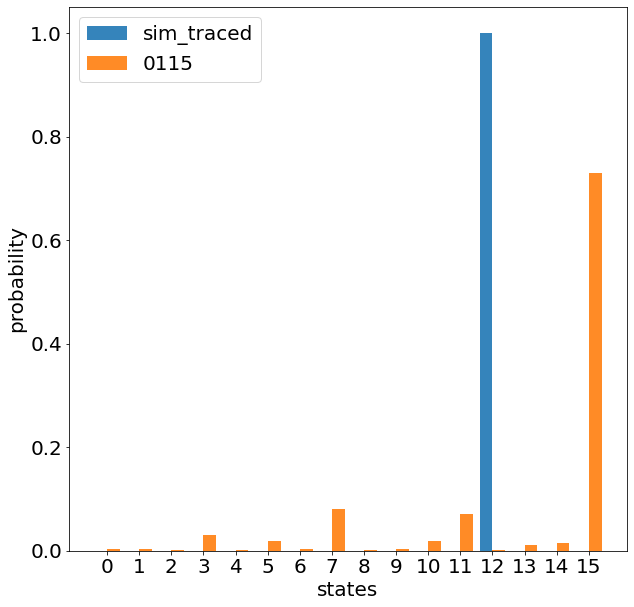

counts: [1623, 14, 22, 5, 123, 20, 2, 0, 147, 2, 22, 1, 14, 2, 3, 0]
counts_ibm_mapping_dic: {'0000': 1623, '1000': 14, '0100': 22, '1100': 5, '0010': 123, '1010': 20, '0110': 2, '1110': 0, '0001': 147, '1001': 2, '0101': 22, '1101': 1, '0011': 14, '1011': 2, '0111': 3, '1111': 0}
HAD2:RX+51:HAD3:RX+41:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:RY+21:FTXA230.2500+:AZ2+1.0000:AZ3+1.0000:FTXA230.2500+:RY+31:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



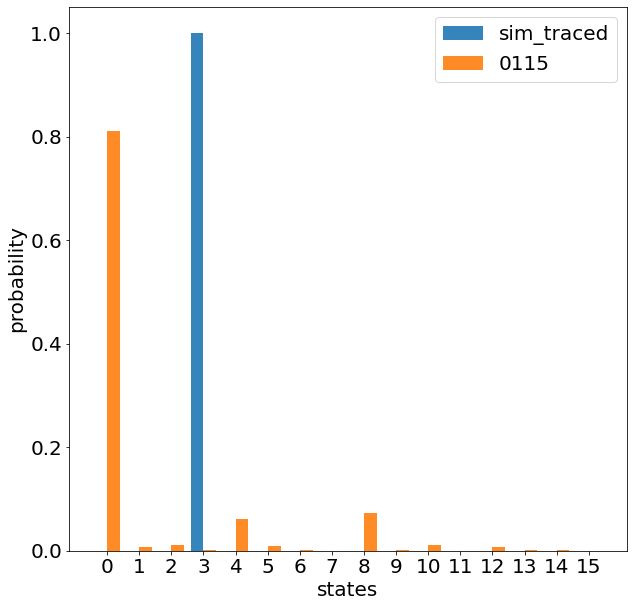

counts: [81, 0, 28, 0, 8, 1, 3, 0, 1651, 23, 21, 1, 159, 20, 3, 1]
counts_ibm_mapping_dic: {'0000': 81, '1000': 0, '0100': 28, '1100': 0, '0010': 8, '1010': 1, '0110': 3, '1110': 0, '0001': 1651, '1001': 23, '0101': 21, '1101': 1, '0011': 159, '1011': 20, '0111': 3, '1111': 1}
HAD2:RX+51:HAD3:RX+41:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:RX+21:FTXA230.2500+:RX+21:AZ3+1.0000:FTXA230.2500+:RY+21:RY+31:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



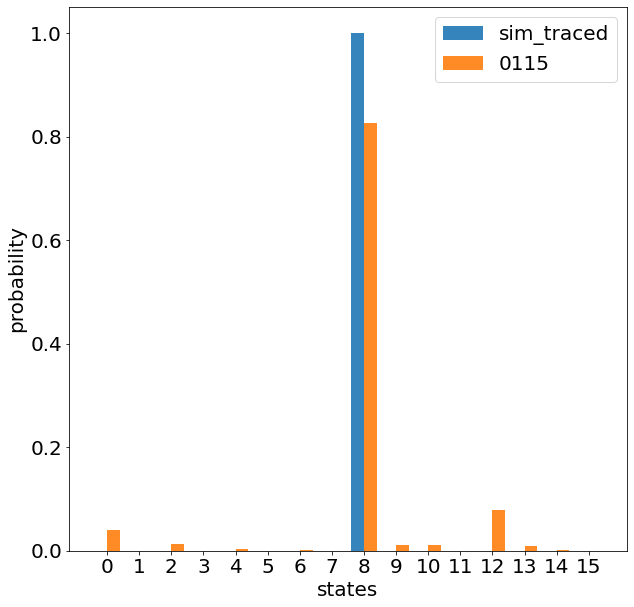

counts: [1574, 11, 14, 1, 266, 27, 9, 1, 48, 0, 22, 0, 17, 0, 10, 0]
counts_ibm_mapping_dic: {'0000': 1574, '1000': 11, '0100': 14, '1100': 1, '0010': 266, '1010': 27, '0110': 9, '1110': 1, '0001': 48, '1001': 0, '0101': 22, '1101': 0, '0011': 17, '1011': 0, '0111': 10, '1111': 0}
HAD2:RX+51:HAD3:RX+41:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:RY+21:RX+31:FTXA230.2500+:RY+21:AZ3+1.0000:FTXA230.2500+:RX+21:AZ3+1.0000:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



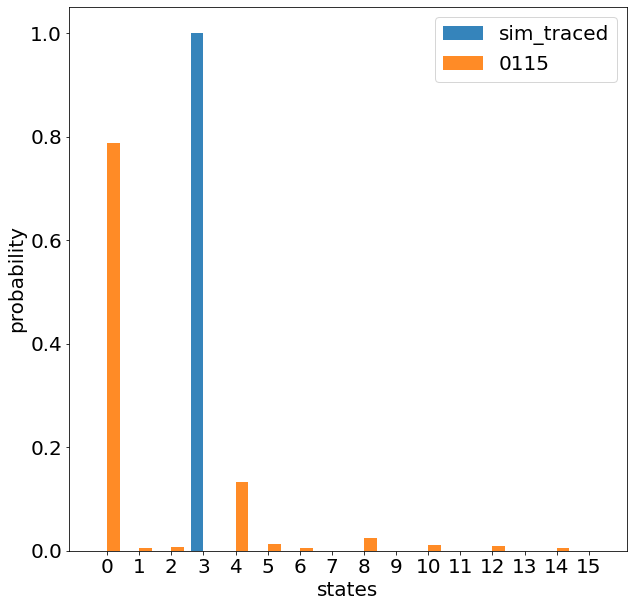

counts: [1, 34, 6, 227, 1, 2, 6, 33, 3, 43, 31, 1479, 1, 0, 51, 82]
counts_ibm_mapping_dic: {'0000': 1, '1000': 34, '0100': 6, '1100': 227, '0010': 1, '1010': 2, '0110': 6, '1110': 33, '0001': 3, '1001': 43, '0101': 31, '1101': 1479, '0011': 1, '1011': 0, '0111': 51, '1111': 82}
HAD2:RX+51:HAD3:RX+41:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:RY+21:RY+31:FTXA230.2500+:RX+31:FTXA230.2500+:RX+21:AZ3+1.0000:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



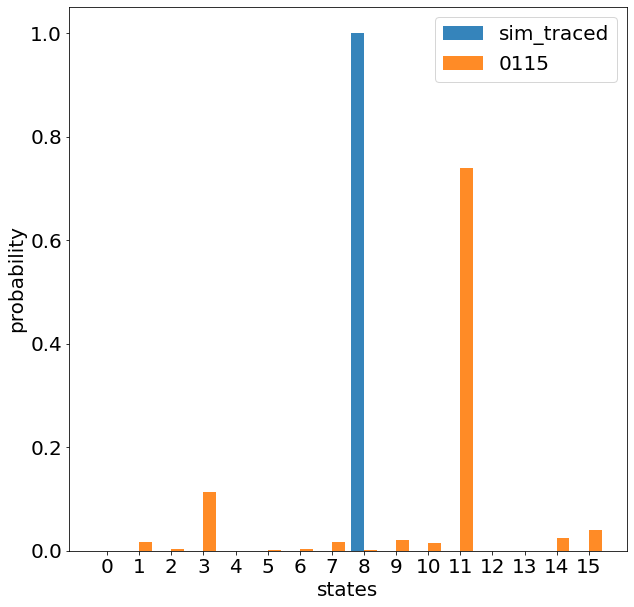

counts: [2, 5, 48, 115, 4, 48, 36, 1569, 0, 4, 2, 16, 3, 40, 2, 106]
counts_ibm_mapping_dic: {'0000': 2, '1000': 5, '0100': 48, '1100': 115, '0010': 4, '1010': 48, '0110': 36, '1110': 1569, '0001': 0, '1001': 4, '0101': 2, '1101': 16, '0011': 3, '1011': 40, '0111': 2, '1111': 106}
HAD2:RX+51:HAD3:RX+41:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:AZ2+1.0000:AZ3+1.0000:FTXA230.2500+:RX+21:RX+31:FTXA230.2500+:RY+21:RX+31:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



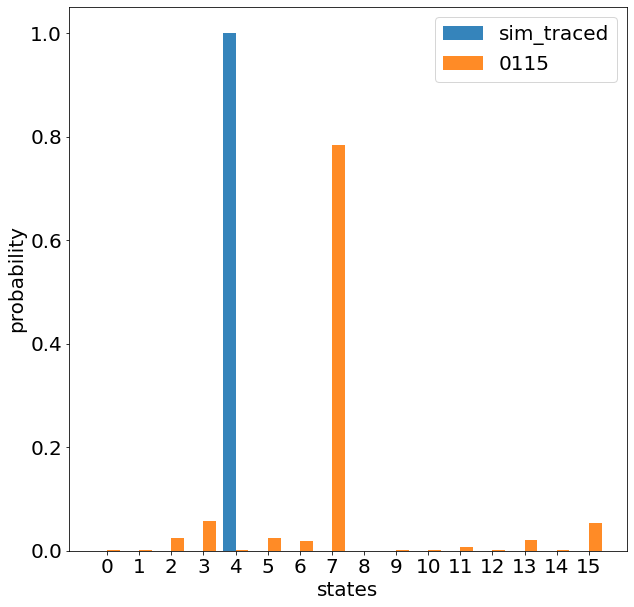

counts: [37, 1778, 1, 30, 37, 39, 1, 0, 2, 43, 0, 23, 4, 1, 1, 3]
counts_ibm_mapping_dic: {'0000': 37, '1000': 1778, '0100': 1, '1100': 30, '0010': 37, '1010': 39, '0110': 1, '1110': 0, '0001': 2, '1001': 43, '0101': 0, '1101': 23, '0011': 4, '1011': 1, '0111': 1, '1111': 3}
HAD2:RX+51:HAD3:RX+41:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:FTXA230.2500+:AZ3+1.0000:FTXA230.2500+:RX+21:AZ3+1.0000:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



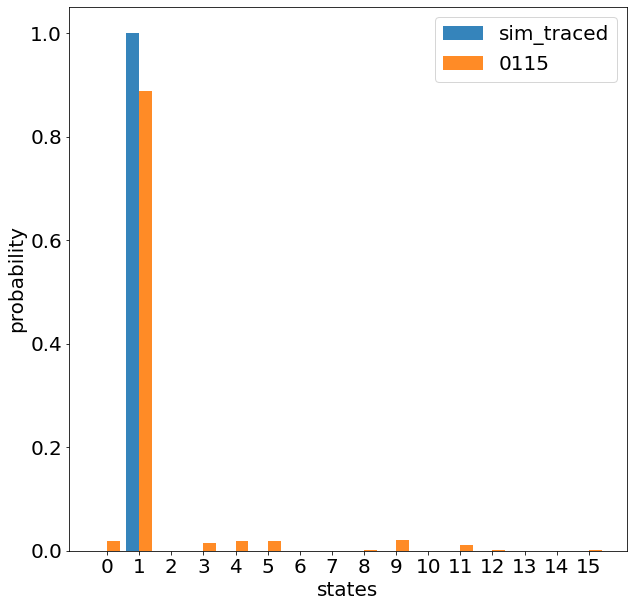

counts: [3, 3, 3, 0, 57, 0, 18, 1, 138, 21, 2, 0, 1699, 28, 26, 1]
counts_ibm_mapping_dic: {'0000': 3, '1000': 3, '0100': 3, '1100': 0, '0010': 57, '1010': 0, '0110': 18, '1110': 1, '0001': 138, '1001': 21, '0101': 2, '1101': 0, '0011': 1699, '1011': 28, '0111': 26, '1111': 1}
HAD2:RX+51:HAD3:RX+41:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:RX+31:FTXA230.2500+:RY+31:FTXA230.2500+:RY+21:RX+31:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



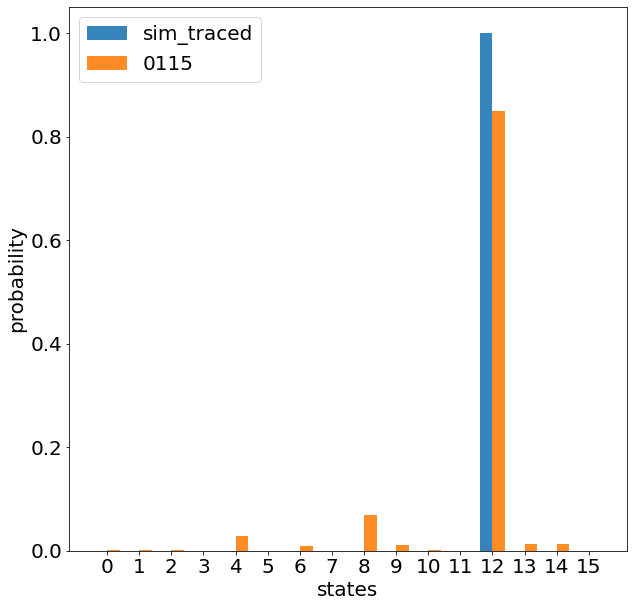

In [11]:
filenames_data=[]
counts_d2=[]
counts_d2_spam=[]
counts_d2_sim=[]
shots=2000
counts=[]
counts_spam=[]
counts_sim=[]

filenames_data=filenames_d2_0703.copy()
print (filenames_data)
paf_data=paf_data_d2_0703
circuit=c_d2
for i in range (len(filenames_data)):
#     print (filenames_data[i])
    a.Import(paf_data+filenames_data[i],keep_file=True)
    data_traced=Trace_Out(a,[0,1,2,3])
    counts=[round(shots*x) for x in  data_traced.population]
    print ("counts:", counts)
    counts_ibm_mapping, counts_ibm_mapping_dic=map_statepop_2_ibm_mapping(counts,nqubit)
    print ("counts_ibm_mapping_dic:",counts_ibm_mapping_dic)
    counts_d2.append(counts_ibm_mapping_dic)
    
#     a_s=spam1.Correct_SPAM(a)
#     a_s=a
#     data_traced_spam=Trace_Out(a_s,[0,1,2,3])
#     counts_spam=[round(shots*x) for x in  data_traced_spam.population]
#     counts_ibm_mapping_spam, counts_ibm_mapping_dic_spam=map_statepop_2_ibm_mapping(counts_spam,nqubit)
#     counts_d2_spam.append(counts_ibm_mapping_dic_spam)


    
    b_c.Interpret_GatesLab_Sequence(circuit[i])
    print (circuit[i])
    b=b_c.Simulate()
    sim_traced=Trace_Out(b,[0,1,2,3])
    counts_sim=[round(shots*x) for x in sim_traced.population]
    counts_ibm_mapping_sim, counts_ibm_mapping_dic_sim=map_statepop_2_ibm_mapping(counts_sim,nqubit)
    counts_d2_sim.append(counts_ibm_mapping_dic_sim)
    
    
#     Display_States_Population(states=[b,a,a_0703],label=["simulation","d=2 0711","0115 identity channel"])
    Display_States_Population(states=[sim_traced,data_traced],label=["sim_traced","0115"])
# #       


['2024-01-15-175855_Line_001.txt', '2024-01-15-175922_Line_002.txt', '2024-01-15-175950_Line_003.txt', '2024-01-15-180017_Line_004.txt', '2024-01-15-180122_Line_005.txt', '2024-01-15-180149_Line_006.txt', '2024-01-15-180217_Line_007.txt', '2024-01-15-180244_Line_008.txt', '2024-01-15-180349_Line_009.txt', '2024-01-15-180416_Line_010.txt', '2024-01-15-200921_Line_011.txt', '2024-01-15-200948_Line_012.txt', '2024-01-15-201016_Line_013.txt', '2024-01-15-201043_Line_014.txt', '2024-01-15-201110_Line_015.txt', '2024-01-15-203337_Line_016.txt', '2024-01-15-203405_Line_017.txt', '2024-01-15-203433_Line_018.txt', '2024-01-15-203500_Line_019.txt', '2024-01-15-203527_Line_020.txt']
HAD2:RX+51:HAD3:RX+41:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:RX+21:RY+31:XA230.2500+:AZ2+1.0000:AZ3+1.0000:XA230.2500+:RY+21:XA230.2500+:AZ2+1.0000:XA230.2500+:RY+21:RX+31:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



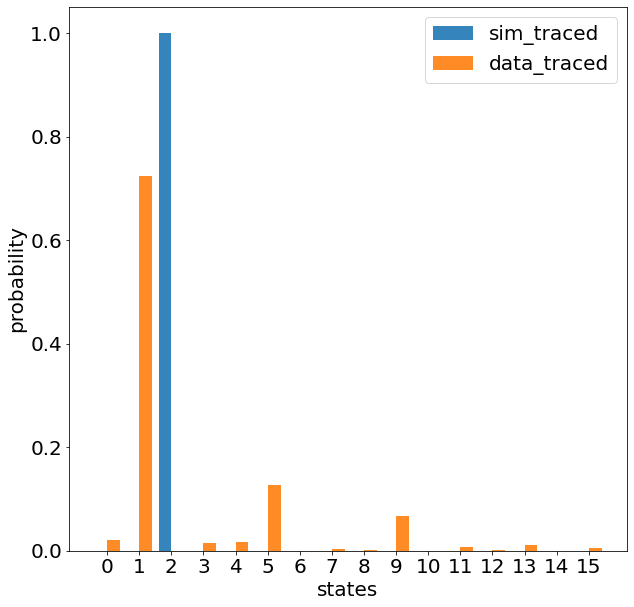

HAD2:RX+51:HAD3:RX+41:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:AZ3+1.0000:XA230.2500+:RX+31:XA230.2500+:AZ3+1.0000:XA230.2500+:RX+21:RY+31:XA230.2500+:AZ2+1.0000:AZ3+1.0000:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



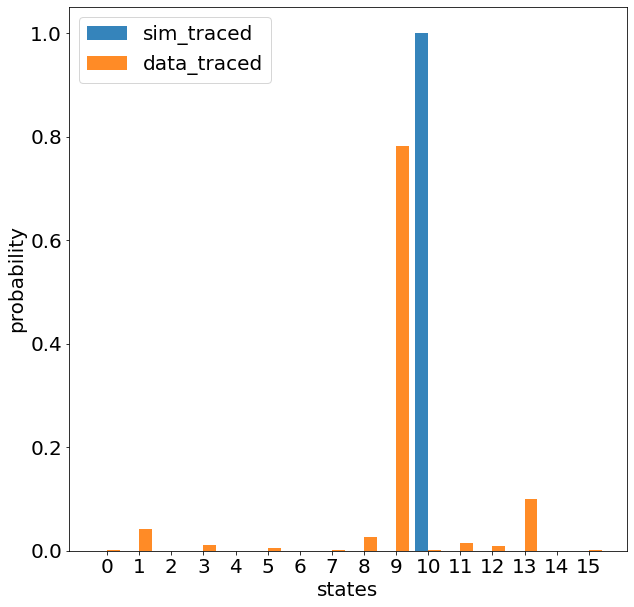

HAD2:RX+51:HAD3:RX+41:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:XA230.2500+:RY+21:AZ3+1.0000:XA230.2500+:RX+21:RY+31:XA230.2500+:RY+21:RY+31:XA230.2500+:RX+21:AZ3+1.0000:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



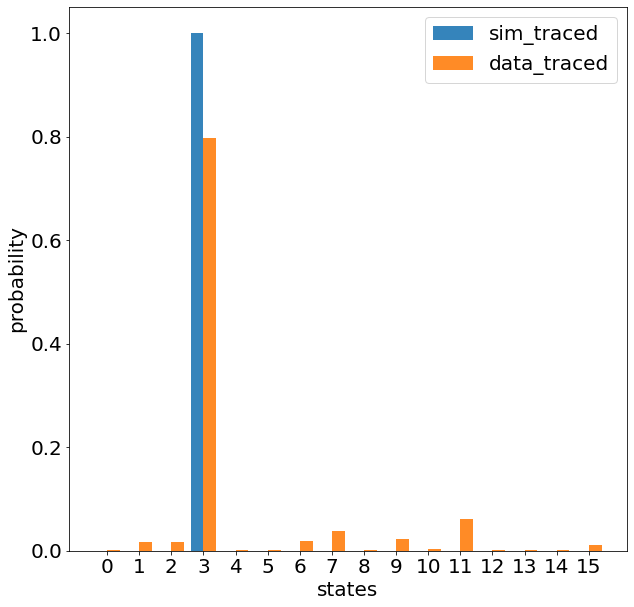

HAD2:RX+51:HAD3:RX+41:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:RX+21:RY+31:XA230.2500+:AZ2+1.0000:RX+31:XA230.2500+:AZ3+1.0000:XA230.2500+:AZ2+1.0000:RY+31:XA230.2500+:AZ2+1.0000:RX+31:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



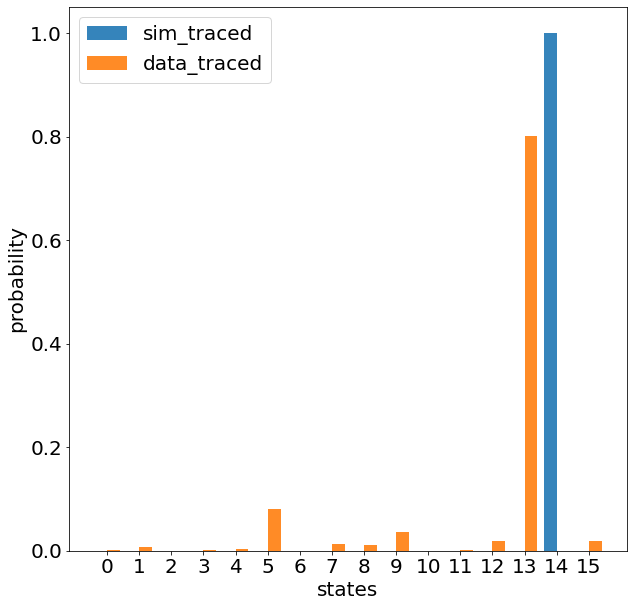

HAD2:RX+51:HAD3:RX+41:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:XA230.2500+:XA230.2500+:AZ2+1.0000:XA230.2500+:AZ2+1.0000:XA230.2500+:AZ2+1.0000:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



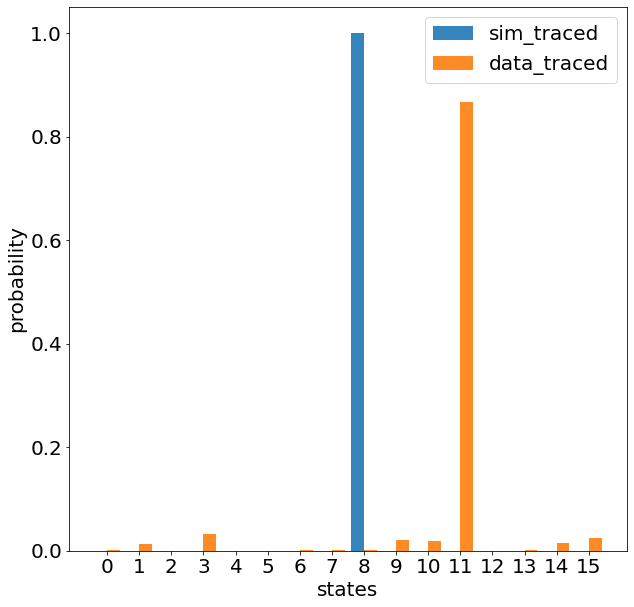

HAD2:RX+51:HAD3:RX+41:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:AZ2+1.0000:XA230.2500+:XA230.2500+:RX+31:XA230.2500+:RX+31:XA230.2500+:AZ2+1.0000:RX+31:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



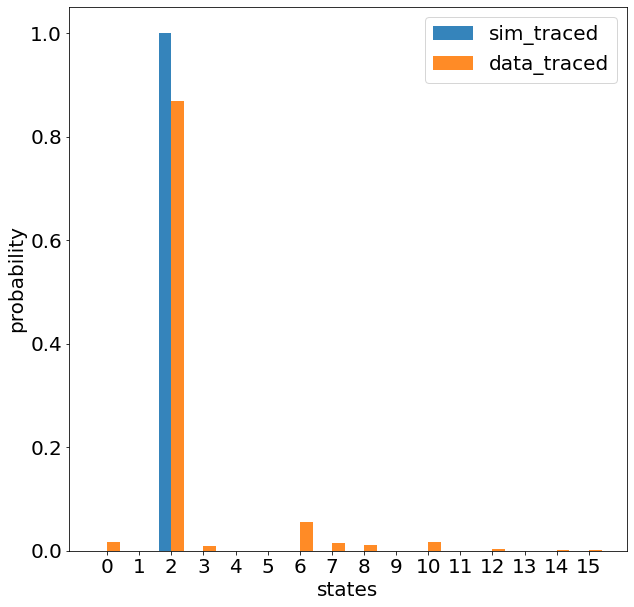

HAD2:RX+51:HAD3:RX+41:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:AZ2+1.0000:RX+31:XA230.2500+:AZ2+1.0000:RY+31:XA230.2500+:XA230.2500+:RX+21:RY+31:XA230.2500+:RY+21:RX+31:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



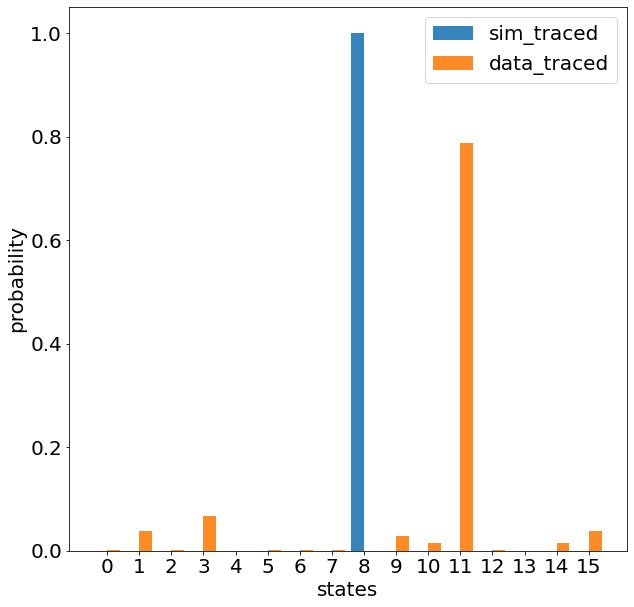

HAD2:RX+51:HAD3:RX+41:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:RX+21:AZ3+1.0000:XA230.2500+:AZ2+1.0000:XA230.2500+:RX+31:XA230.2500+:RY+31:XA230.2500+:AZ2+1.0000:RX+31:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



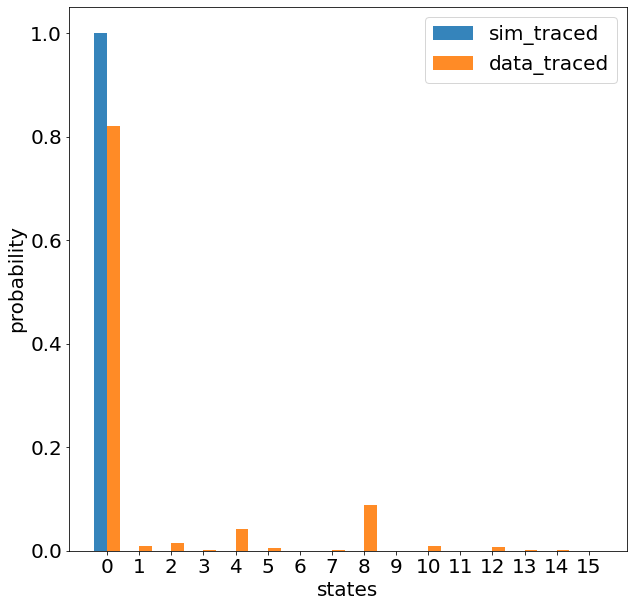

HAD2:RX+51:HAD3:RX+41:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:AZ2+1.0000:AZ3+1.0000:XA230.2500+:RY+31:XA230.2500+:RY+21:XA230.2500+:RX+31:XA230.2500+:RX+21:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



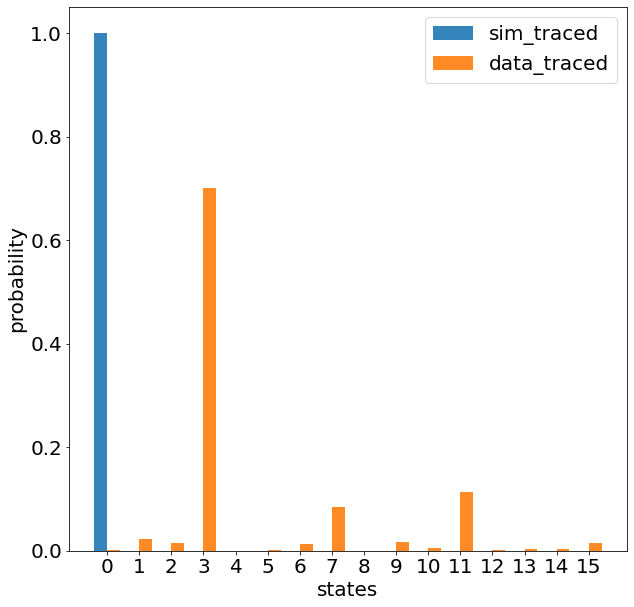

HAD2:RX+51:HAD3:RX+41:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:RX+31:XA230.2500+:RY+21:RX+31:XA230.2500+:AZ2+1.0000:RX+31:XA230.2500+:XA230.2500+:AZ2+1.0000:AZ3+1.0000:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



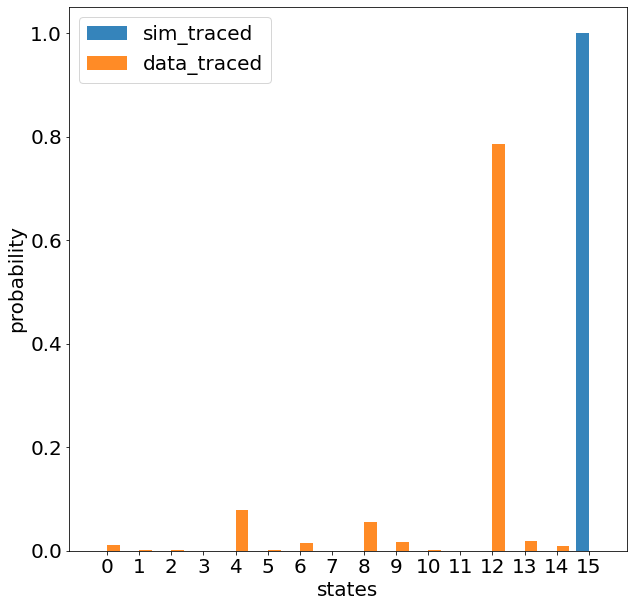

HAD2:RX+51:HAD3:RX+41:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:RY+21:RX+31:XA230.2500+:RY+21:RY+31:XA230.2500+:RY+21:RX+31:XA230.2500+:RY+21:RY+31:XA230.2500+:RY+21:RY+31:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



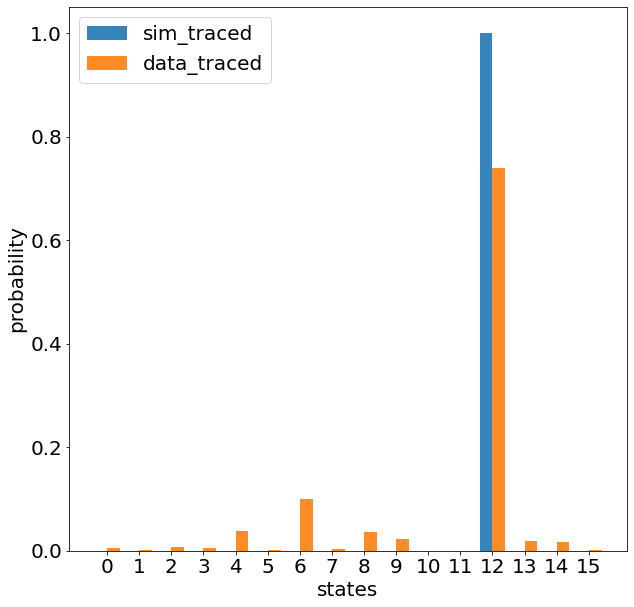

HAD2:RX+51:HAD3:RX+41:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:AZ2+1.0000:RY+31:XA230.2500+:AZ2+1.0000:RX+31:XA230.2500+:AZ2+1.0000:RY+31:XA230.2500+:RX+31:XA230.2500+:RX+21:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



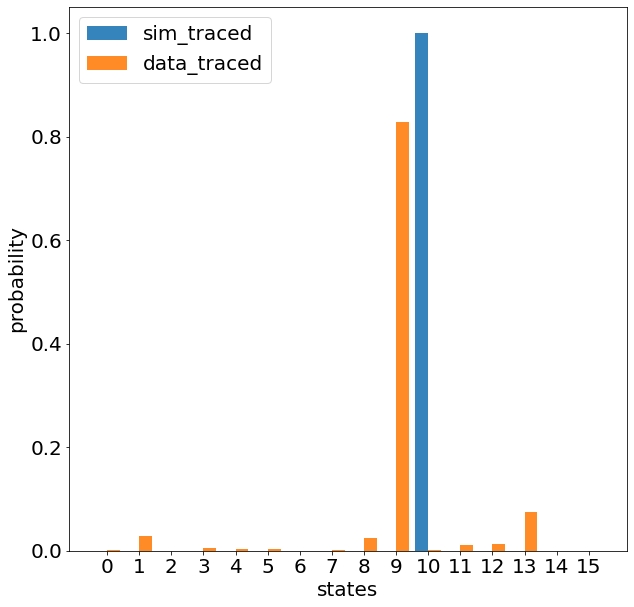

HAD2:RX+51:HAD3:RX+41:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:XA230.2500+:AZ2+1.0000:RY+31:XA230.2500+:RY+31:XA230.2500+:RY+21:AZ3+1.0000:XA230.2500+:RY+21:AZ3+1.0000:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



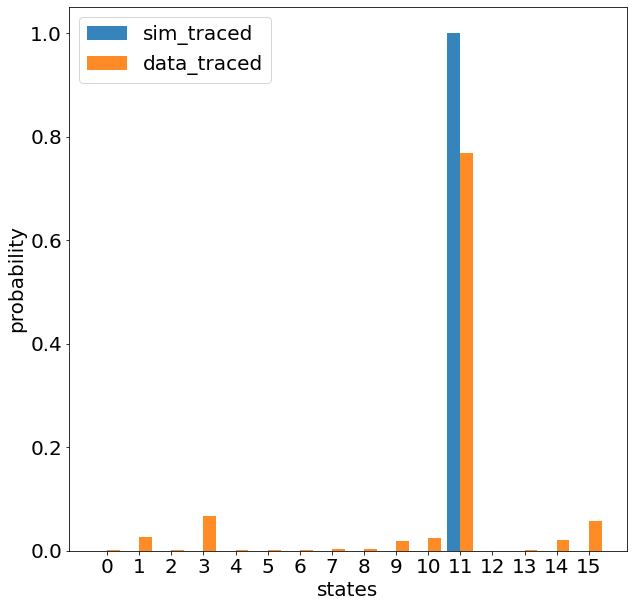

HAD2:RX+51:HAD3:RX+41:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:RY+21:XA230.2500+:RY+21:AZ3+1.0000:XA230.2500+:RX+31:XA230.2500+:RY+21:AZ3+1.0000:XA230.2500+:RY+21:RY+31:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



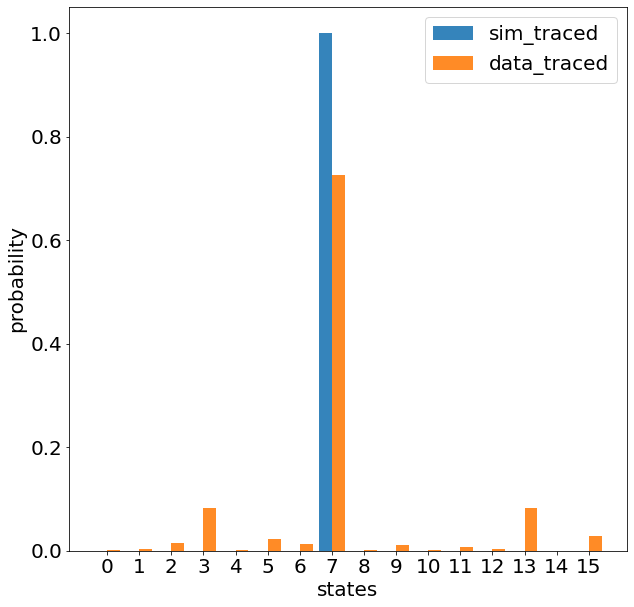

HAD2:RX+51:HAD3:RX+41:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:XA230.2500+:RY+21:AZ3+1.0000:XA230.2500+:RX+21:RY+31:XA230.2500+:RX+31:XA230.2500+:RX+21:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



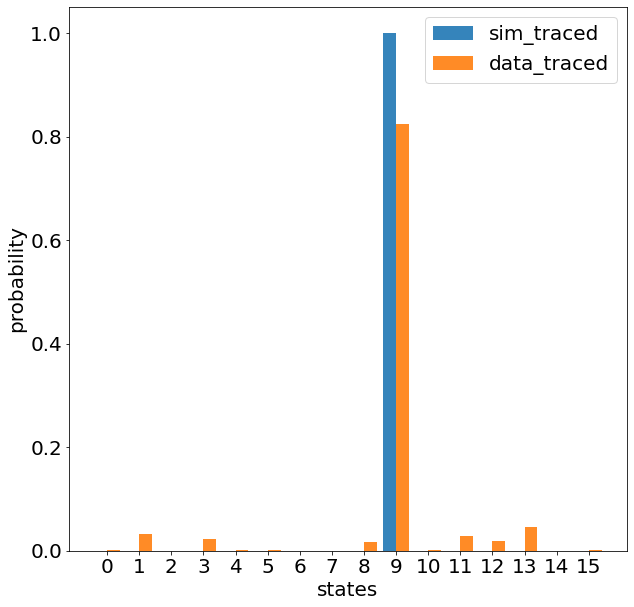

HAD2:RX+51:HAD3:RX+41:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:AZ2+1.0000:AZ3+1.0000:XA230.2500+:AZ3+1.0000:XA230.2500+:XA230.2500+:RX+21:AZ3+1.0000:XA230.2500+:RY+31:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



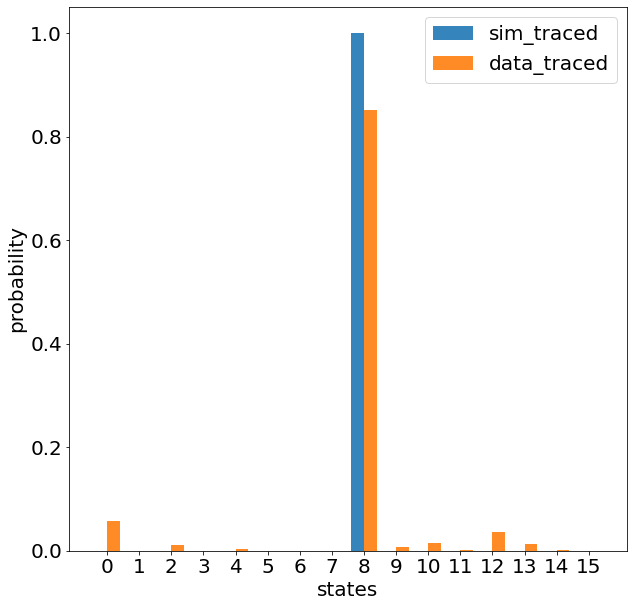

HAD2:RX+51:HAD3:RX+41:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:RX+21:RY+31:XA230.2500+:RX+21:RY+31:XA230.2500+:RX+21:RY+31:XA230.2500+:RX+21:RX+31:XA230.2500+:RY+21:RY+31:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



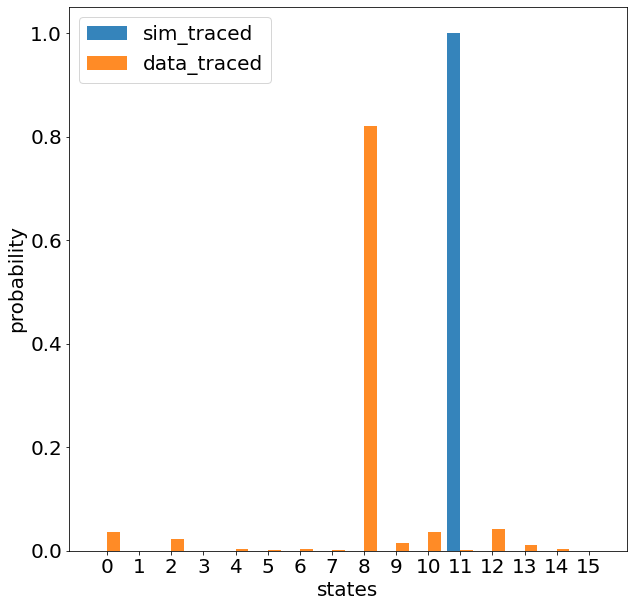

HAD2:RX+51:HAD3:RX+41:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:RY+21:AZ3+1.0000:XA230.2500+:RY+21:RY+31:XA230.2500+:RY+21:RY+31:XA230.2500+:RX+31:XA230.2500+:RX+21:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



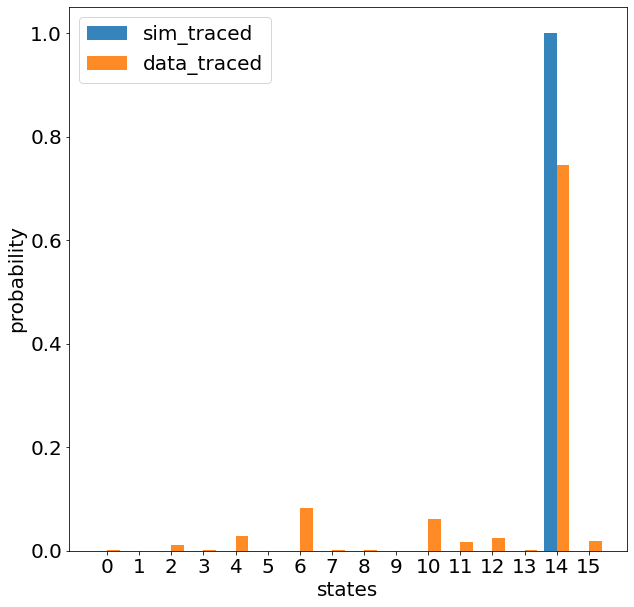

HAD2:RX+51:HAD3:RX+41:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:RY+21:AZ3+1.0000:XA230.2500+:RX+21:RX+31:XA230.2500+:AZ2+1.0000:RY+31:XA230.2500+:AZ3+1.0000:XA230.2500+:AZ3+1.0000:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



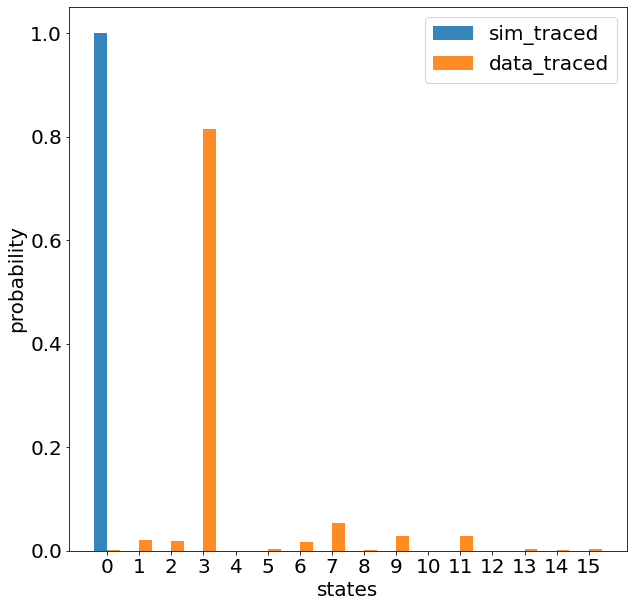

HAD2:RX+51:HAD3:RX+41:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:RX+31:XA230.2500+:RX+21:XA230.2500+:AZ2+1.0000:RY+31:XA230.2500+:RY+21:XA230.2500+:RX+21:AZ3+1.0000:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



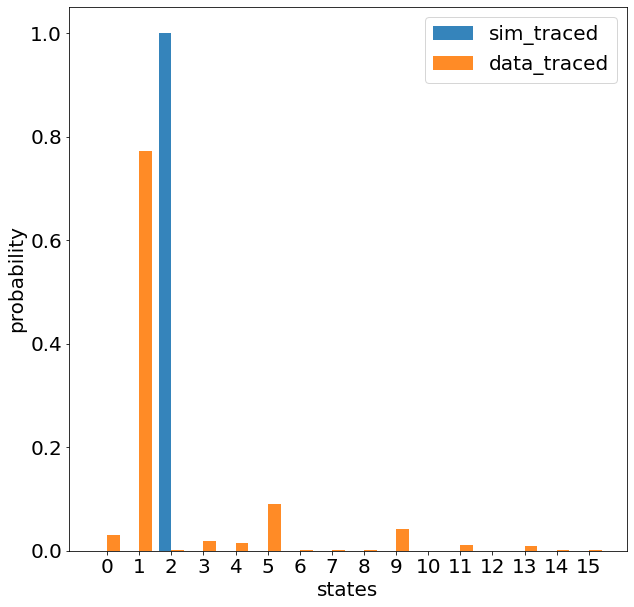

In [12]:
filenames_data=[]
counts_d4=[]
counts_d4_spam=[]
counts=[]
counts_spam=[]
filenames_data=filenames_d4_0703.copy()
print (filenames_data)
paf_data=paf_data_d4_0703
circuit=c_d4
for i in range (len(filenames_data)):
#     print (filenames_data[i])
    a.Import(paf_data+filenames_data[i],keep_file=True)
    data_traced=Trace_Out(a,[0,1,2,3])
    counts=[round(shots*x) for x in  data_traced.population]
    counts_ibm_mapping, counts_ibm_mapping_dic=map_statepop_2_ibm_mapping(counts,nqubit)
    counts_d4.append(counts_ibm_mapping_dic)
    
    
#     a_s=spam1.Correct_SPAM(a)
#     data_traced_spam=Trace_Out(a_s,[0,1,2,3])
#     counts_spam=[round(shots*x) for x in  data_traced_spam.population]
#     counts_ibm_mapping_spam, counts_ibm_mapping_dic_spam=map_statepop_2_ibm_mapping(counts_spam,nqubit)
#     counts_d4_spam.append(counts_ibm_mapping_dic_spam)
    
#     a_0703.Import(paf_data_d4_0703+filenames_d4_0703[i],keep_file=True)
#     data_0703_traced=Trace_Out(a_0703,[0,1,2,3])

    b_c.Interpret_GatesLab_Sequence(circuit[i])
    print (circuit[i])
    b=b_c.Simulate()
    sim_traced=Trace_Out(b,[0,1,2,3])
#     Display_States_Population(states=[b,a,a_s],label=["simulation","d=4","spam"])
    Display_States_Population(states=[sim_traced,data_traced],label=["sim_traced","data_traced"])
# #         

['2024-01-15-181107_Line_001.txt', '2024-01-15-181142_Line_002.txt', '2024-01-15-181218_Line_003.txt', '2024-01-15-181331_Line_004.txt', '2024-01-15-181406_Line_005.txt', '2024-01-15-181443_Line_006.txt', '2024-01-15-181555_Line_007.txt', '2024-01-15-181631_Line_008.txt', '2024-01-15-181707_Line_009.txt', '2024-01-15-181820_Line_010.txt', '2024-01-15-195139_Line_011.txt', '2024-01-15-195214_Line_012.txt', '2024-01-15-195250_Line_013.txt', '2024-01-15-195325_Line_014.txt', '2024-01-15-200117_Line_015.txt', '2024-01-15-200151_Line_016.txt', '2024-01-15-200226_Line_017.txt', '2024-01-15-200340_Line_018.txt', '2024-01-15-200414_Line_019.txt', '2024-01-15-200450_Line_020.txt']
HAD2:RX+51:HAD3:RX+41:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:XA230.2500+:AZ2+1.0000:RX+31:XA230.2500+:RY+31:XA230.2500+:RY+21:RX+31:XA230.2500+:AZ2+1.0000:AZ3+1.0000:XA230.2500+:XA230.2500+:RX+21:RX+31:XA230.2500+:RY+31:XA230.2500+:RY+21:RY+31:RY+22:XA250.2500+:RY-22:RX-52:AZ

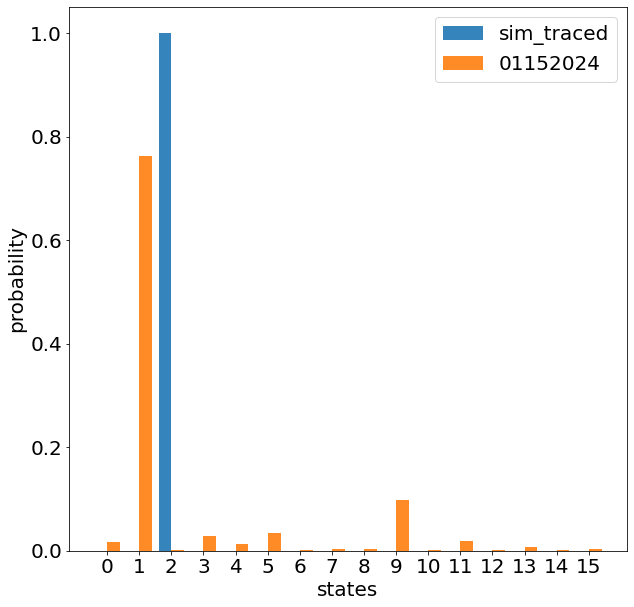

HAD2:RX+51:HAD3:RX+41:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:RY+21:XA230.2500+:AZ2+1.0000:XA230.2500+:AZ2+1.0000:XA230.2500+:RY+31:XA230.2500+:RX+21:AZ3+1.0000:XA230.2500+:RX+31:XA230.2500+:RY+31:XA230.2500+:AZ2+1.0000:RX+31:XA230.2500+:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



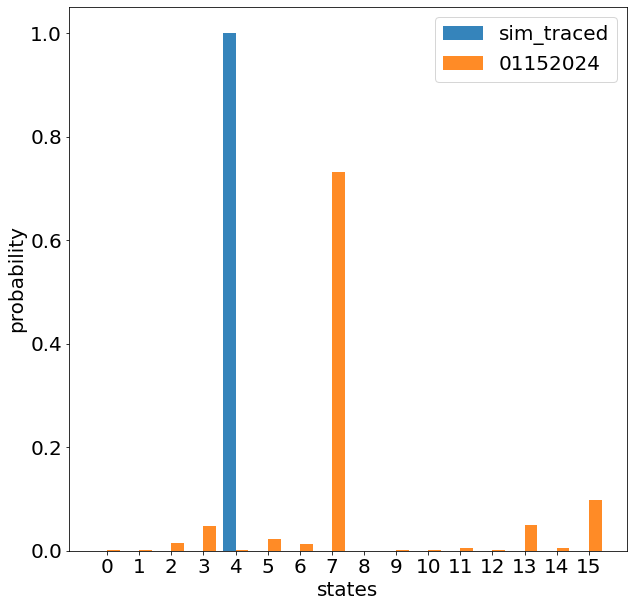

HAD2:RX+51:HAD3:RX+41:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:AZ2+1.0000:RY+31:XA230.2500+:RY+21:RX+31:XA230.2500+:RX+21:RY+31:XA230.2500+:RY+21:RY+31:XA230.2500+:AZ2+1.0000:XA230.2500+:AZ2+1.0000:RX+31:XA230.2500+:RX+31:XA230.2500+:AZ3+1.0000:XA230.2500+:RY+21:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



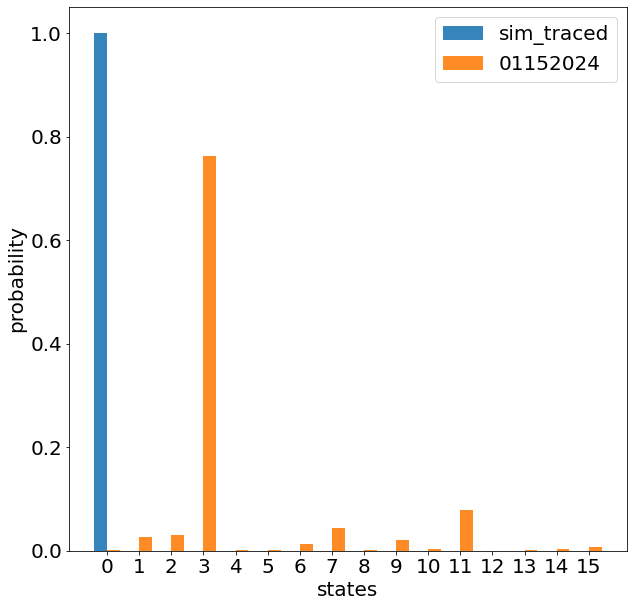

HAD2:RX+51:HAD3:RX+41:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:AZ2+1.0000:RY+31:XA230.2500+:RY+21:AZ3+1.0000:XA230.2500+:RX+31:XA230.2500+:RY+21:XA230.2500+:RX+21:RX+31:XA230.2500+:XA230.2500+:RX+21:AZ3+1.0000:XA230.2500+:RY+21:AZ3+1.0000:XA230.2500+:RY+21:AZ3+1.0000:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



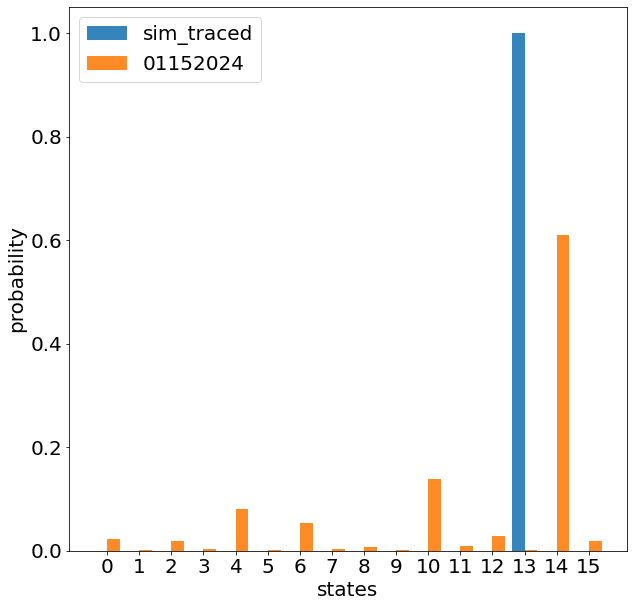

HAD2:RX+51:HAD3:RX+41:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:RY+31:XA230.2500+:AZ2+1.0000:RX+31:XA230.2500+:RY+21:RX+31:XA230.2500+:RY+21:AZ3+1.0000:XA230.2500+:XA230.2500+:XA230.2500+:RY+21:RY+31:XA230.2500+:XA230.2500+:RX+21:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



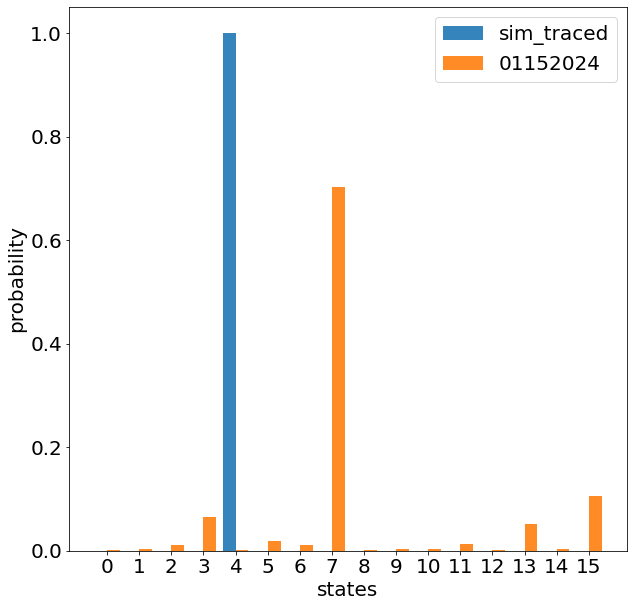

HAD2:RX+51:HAD3:RX+41:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:RY+21:AZ3+1.0000:XA230.2500+:RY+21:XA230.2500+:AZ2+1.0000:RY+31:XA230.2500+:RX+21:RX+31:XA230.2500+:RY+21:RY+31:XA230.2500+:RY+31:XA230.2500+:RY+21:RX+31:XA230.2500+:RX+21:XA230.2500+:AZ2+1.0000:AZ3+1.0000:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



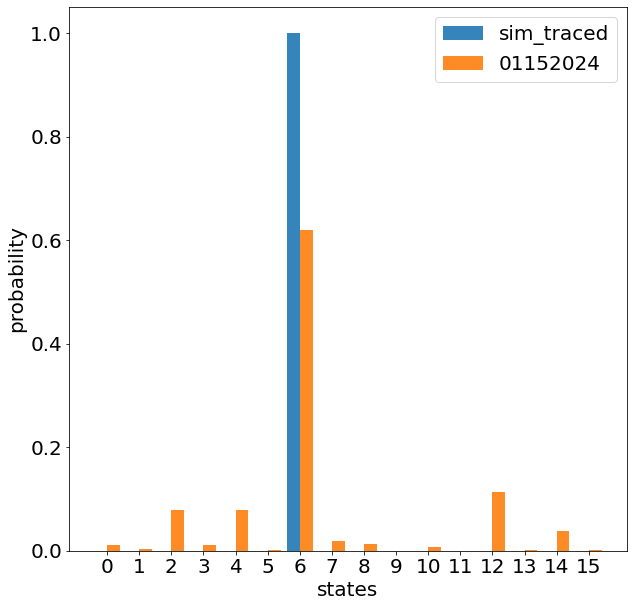

HAD2:RX+51:HAD3:RX+41:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:RX+21:XA230.2500+:AZ2+1.0000:XA230.2500+:RY+21:AZ3+1.0000:XA230.2500+:RX+21:XA230.2500+:AZ3+1.0000:XA230.2500+:AZ2+1.0000:XA230.2500+:AZ2+1.0000:XA230.2500+:RX+31:XA230.2500+:AZ2+1.0000:RY+31:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



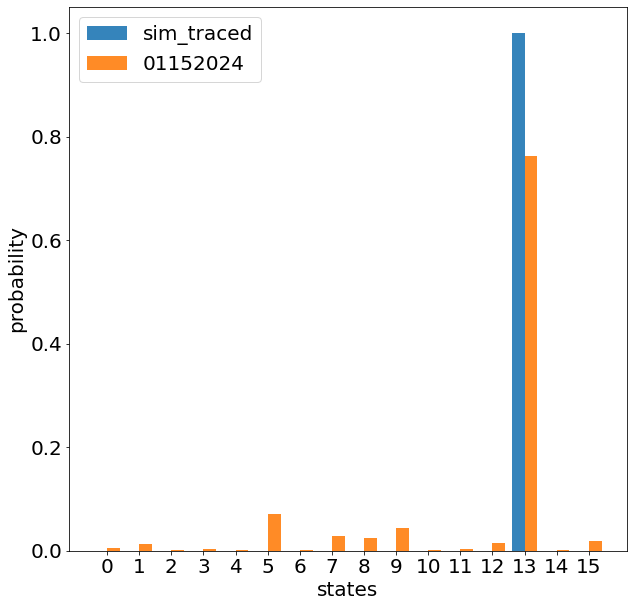

HAD2:RX+51:HAD3:RX+41:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:XA230.2500+:AZ2+1.0000:XA230.2500+:RY+21:XA230.2500+:RY+21:RX+31:XA230.2500+:RY+21:RX+31:XA230.2500+:RX+21:RX+31:XA230.2500+:RX+21:AZ3+1.0000:XA230.2500+:RY+21:RY+31:XA230.2500+:RX+21:AZ3+1.0000:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



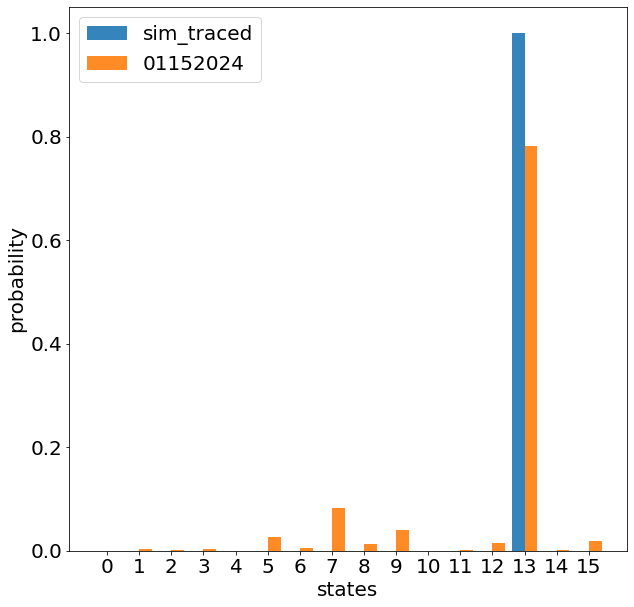

HAD2:RX+51:HAD3:RX+41:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:RY+21:XA230.2500+:RY+21:XA230.2500+:AZ2+1.0000:XA230.2500+:RX+31:XA230.2500+:RX+21:XA230.2500+:AZ2+1.0000:RX+31:XA230.2500+:RX+21:RX+31:XA230.2500+:RY+21:RX+31:XA230.2500+:RY+21:RX+31:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



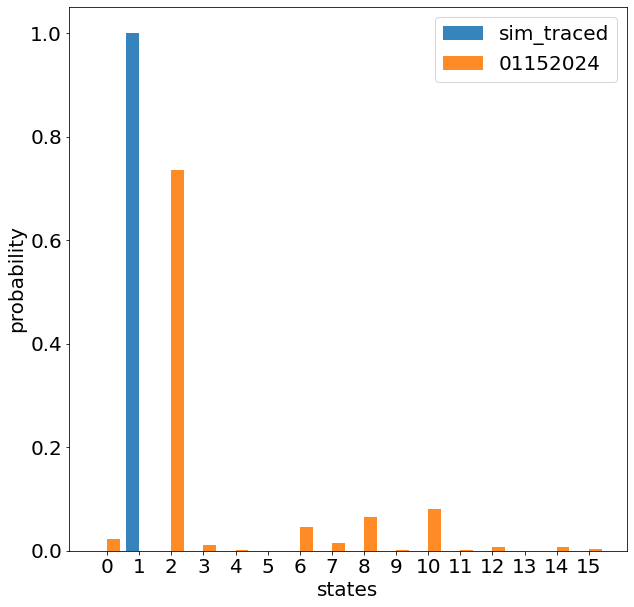

HAD2:RX+51:HAD3:RX+41:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:XA230.2500+:RX+21:RY+31:XA230.2500+:RY+21:RY+31:XA230.2500+:AZ3+1.0000:XA230.2500+:RY+21:AZ3+1.0000:XA230.2500+:AZ2+1.0000:AZ3+1.0000:XA230.2500+:RX+21:AZ3+1.0000:XA230.2500+:RY+21:AZ3+1.0000:XA230.2500+:RX+21:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



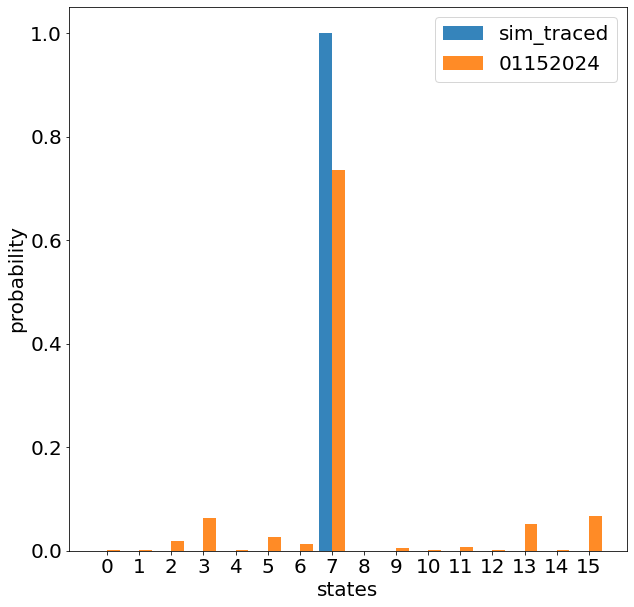

HAD2:RX+51:HAD3:RX+41:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:RY+31:XA230.2500+:AZ2+1.0000:RX+31:XA230.2500+:XA230.2500+:RY+21:RY+31:XA230.2500+:XA230.2500+:RY+21:RY+31:XA230.2500+:AZ2+1.0000:AZ3+1.0000:XA230.2500+:AZ3+1.0000:XA230.2500+:AZ2+1.0000:AZ3+1.0000:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



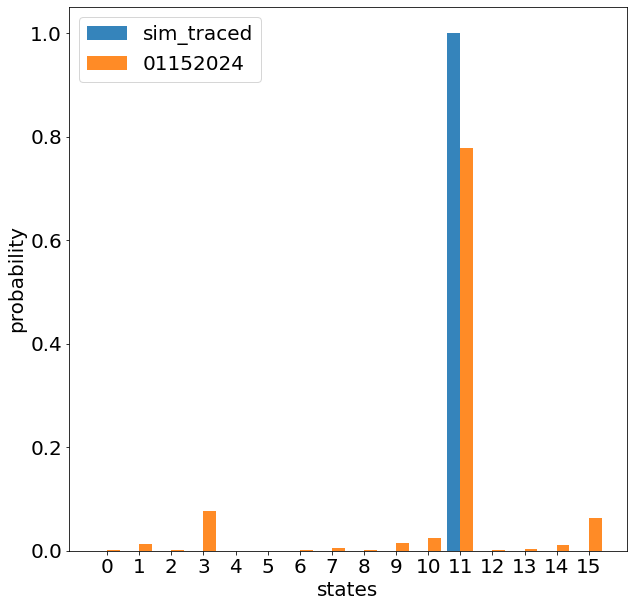

HAD2:RX+51:HAD3:RX+41:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:RX+21:XA230.2500+:AZ3+1.0000:XA230.2500+:AZ2+1.0000:XA230.2500+:AZ3+1.0000:XA230.2500+:AZ2+1.0000:RX+31:XA230.2500+:AZ2+1.0000:XA230.2500+:AZ2+1.0000:RY+31:XA230.2500+:RY+21:RY+31:XA230.2500+:RY+21:RY+31:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



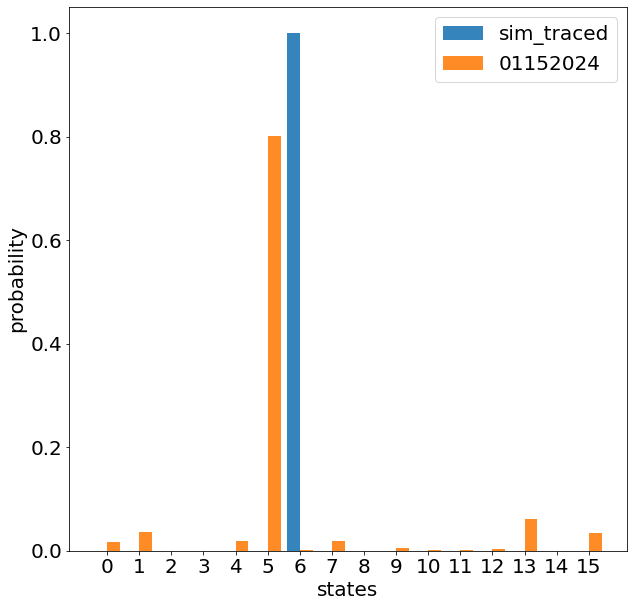

HAD2:RX+51:HAD3:RX+41:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:RY+21:XA230.2500+:RX+21:RY+31:XA230.2500+:RX+21:RY+31:XA230.2500+:RY+21:RX+31:XA230.2500+:RX+31:XA230.2500+:RY+21:XA230.2500+:AZ2+1.0000:RX+31:XA230.2500+:RY+31:XA230.2500+:AZ2+1.0000:AZ3+1.0000:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



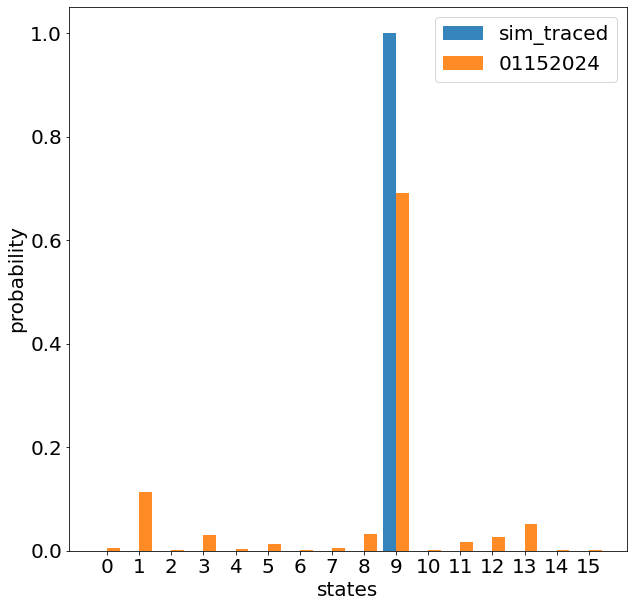

HAD2:RX+51:HAD3:RX+41:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:RX+31:XA230.2500+:AZ3+1.0000:XA230.2500+:RY+21:AZ3+1.0000:XA230.2500+:RY+31:XA230.2500+:AZ3+1.0000:XA230.2500+:RX+21:RX+31:XA230.2500+:RX+21:RY+31:XA230.2500+:AZ2+1.0000:XA230.2500+:RX+21:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



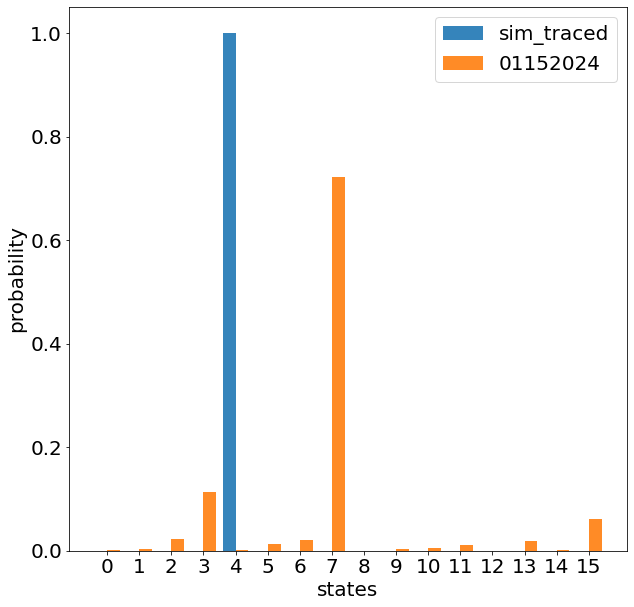

HAD2:RX+51:HAD3:RX+41:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:RY+31:XA230.2500+:RY+21:RX+31:XA230.2500+:AZ2+1.0000:XA230.2500+:XA230.2500+:AZ2+1.0000:XA230.2500+:AZ2+1.0000:RY+31:XA230.2500+:RY+21:RY+31:XA230.2500+:RX+21:AZ3+1.0000:XA230.2500+:RX+21:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



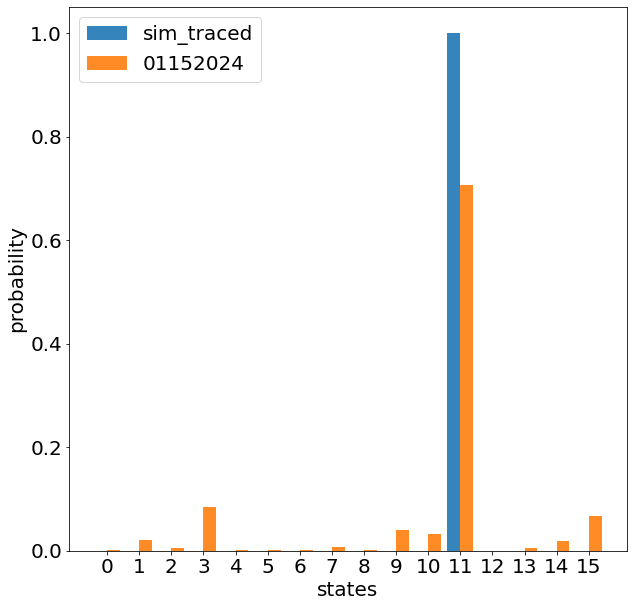

HAD2:RX+51:HAD3:RX+41:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:RY+31:XA230.2500+:RY+21:AZ3+1.0000:XA230.2500+:AZ2+1.0000:RX+31:XA230.2500+:AZ2+1.0000:AZ3+1.0000:XA230.2500+:RX+21:RY+31:XA230.2500+:RX+31:XA230.2500+:RY+21:RX+31:XA230.2500+:RY+21:AZ3+1.0000:XA230.2500+:AZ2+1.0000:AZ3+1.0000:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



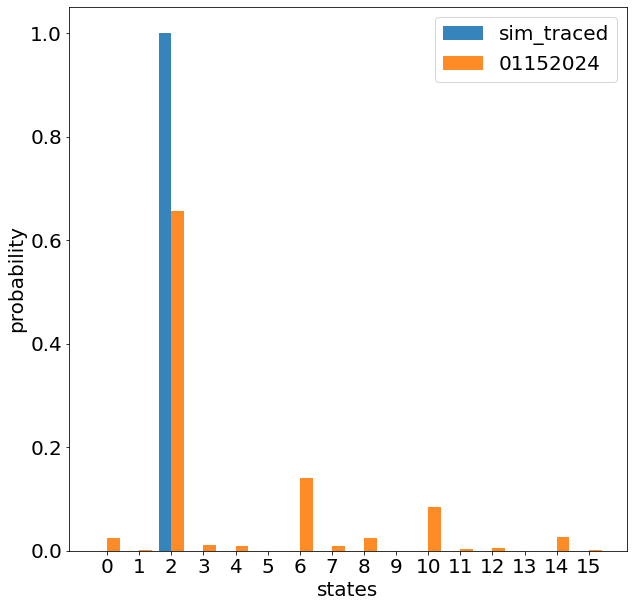

HAD2:RX+51:HAD3:RX+41:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:RY+31:XA230.2500+:RX+21:XA230.2500+:RX+21:AZ3+1.0000:XA230.2500+:AZ2+1.0000:XA230.2500+:RX+21:RY+31:XA230.2500+:RX+21:XA230.2500+:AZ3+1.0000:XA230.2500+:RY+21:XA230.2500+:AZ2+1.0000:AZ3+1.0000:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



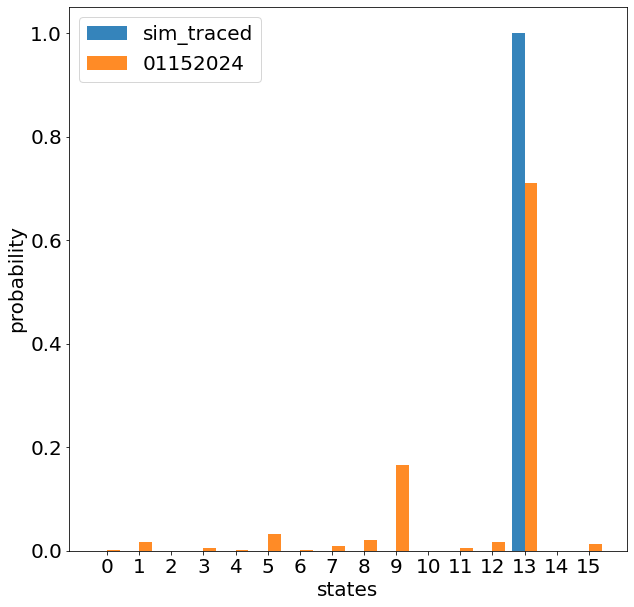

HAD2:RX+51:HAD3:RX+41:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:RX+31:XA230.2500+:RX+21:RX+31:XA230.2500+:AZ3+1.0000:XA230.2500+:RY+21:XA230.2500+:AZ2+1.0000:RX+31:XA230.2500+:RY+31:XA230.2500+:RX+21:XA230.2500+:RY+21:RX+31:XA230.2500+:RX+21:RY+31:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



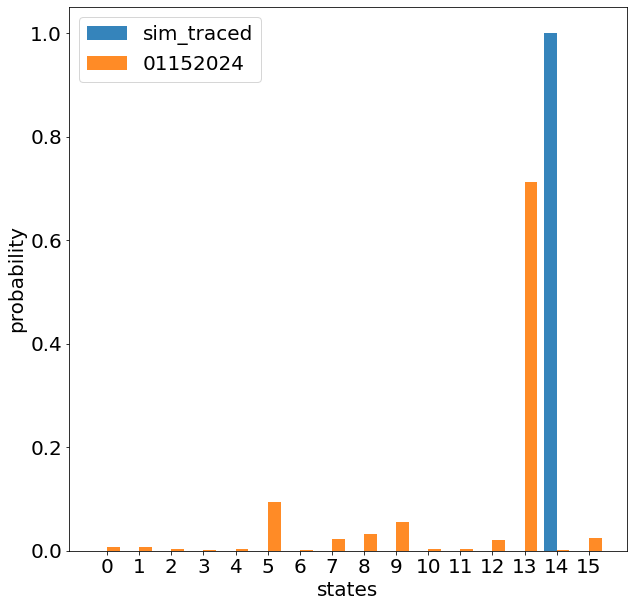

HAD2:RX+51:HAD3:RX+41:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:AZ2+1.0000:RY+31:XA230.2500+:XA230.2500+:AZ2+1.0000:XA230.2500+:RY+21:AZ3+1.0000:XA230.2500+:RY+21:XA230.2500+:XA230.2500+:RX+31:XA230.2500+:AZ2+1.0000:RX+31:XA230.2500+:RY+21:RY+31:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



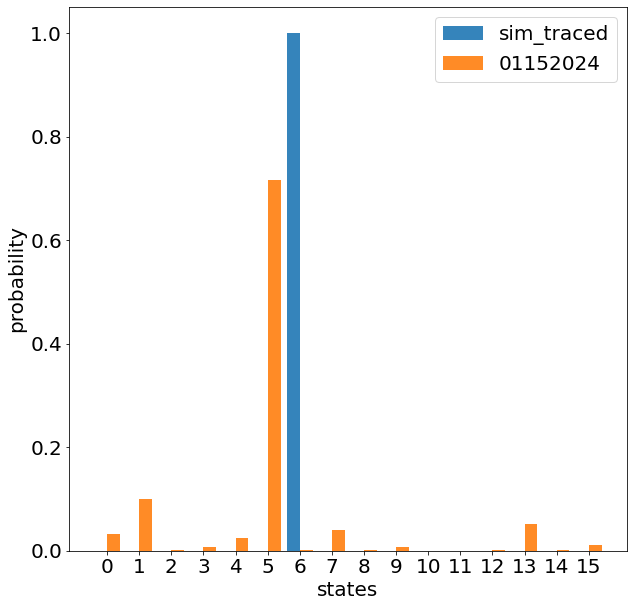

HAD2:RX+51:HAD3:RX+41:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:RY+21:XA230.2500+:RY+21:RX+31:XA230.2500+:RX+21:RX+31:XA230.2500+:AZ2+1.0000:AZ3+1.0000:XA230.2500+:RY+21:RX+31:XA230.2500+:RX+21:XA230.2500+:RY+21:XA230.2500+:RX+21:RX+31:XA230.2500+:RX+21:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



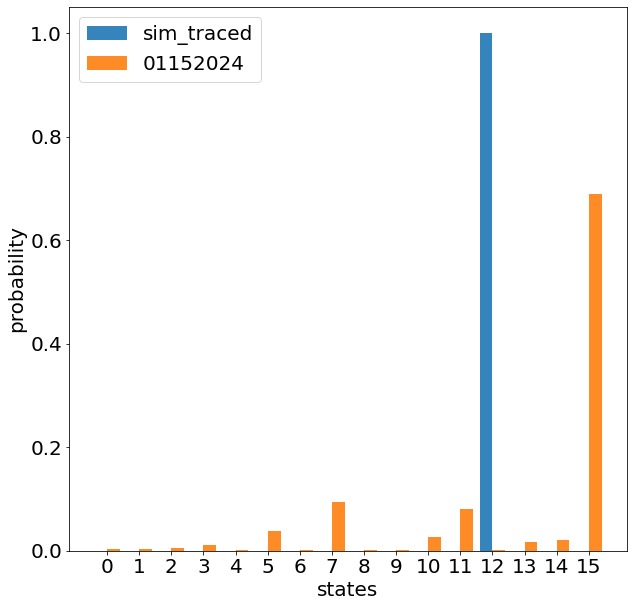

In [13]:
filenames_data=[]
counts_d8=[]
counts_d8_spam=[]
counts=[]
counts_spam=[]
filenames_data=filenames_d8_0703.copy()
print (filenames_data)
# # print (len(filenames_data))
paf_data=paf_data_d8_0703
circuit=c_d8
for i in range (len(filenames_data)):
#     print (filenames_data[i])
    a.Import(paf_data+filenames_data[i],keep_file=True)
    data_traced=Trace_Out(a,[0,1,2,3])
    counts=[round(shots*x) for x in  data_traced.population]
    counts_ibm_mapping, counts_ibm_mapping_dic=map_statepop_2_ibm_mapping(counts,nqubit)
    counts_d8.append(counts_ibm_mapping_dic)
    
#     a_s=spam1.Correct_SPAM(a)
#     data_traced_spam=Trace_Out(a_s,[0,1,2,3])
#     counts_spam=[round(shots*x) for x in  data_traced_spam.population]
#     counts_ibm_mapping_spam, counts_ibm_mapping_dic_spam=map_statepop_2_ibm_mapping(counts_spam,nqubit)
#     counts_d8_spam.append(counts_ibm_mapping_dic_spam)
    
#     a_0703.Import(paf_data_d8_0703+filenames_d8_0703[i],keep_file=True)
#     data_0703_traced=Trace_Out(a_0703,[0,1,2,3])
    
    b_c.Interpret_GatesLab_Sequence(circuit[i])
    print (circuit[i])
    b=b_c.Simulate()
    sim_traced=Trace_Out(b,[0,1,2,3])
#     Display_States_Population(states=[b,a,a_s],label=["simulation","d=8","spam"])
    Display_States_Population(states=[sim_traced,data_traced],label=["sim_traced","01152024"])

['2024-01-15-182032_Line_001.txt', '2024-01-15-182126_Line_002.txt', '2024-01-15-182220_Line_003.txt', '2024-01-15-204632_Line_004.txt', '2024-01-15-182449_Line_005.txt', '2024-01-15-182544_Line_006.txt', '2024-01-15-182717_Line_007.txt', '2024-01-15-182810_Line_008.txt', '2024-01-15-182904_Line_009.txt', '2024-01-15-183036_Line_010.txt', '2024-01-15-193907_Line_011.txt', '2024-01-15-194001_Line_012.txt', '2024-01-15-194053_Line_013.txt', '2024-01-15-194146_Line_014.txt', '2024-01-15-194316_Line_015.txt', '2024-01-15-194410_Line_016.txt', '2024-01-15-194504_Line_017.txt', '2024-01-15-194557_Line_018.txt', '2024-01-15-194729_Line_019.txt', '2024-01-15-194822_Line_020.txt']
2024-01-15-182032_Line_001.txt
HAD2:RX+51:HAD3:RX+41:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:RX+21:RX+31:XA230.2500+:AZ2+1.0000:RX+31:XA230.2500+:AZ2+1.0000:RX+31:XA230.2500+:RX+21:AZ3+1.0000:XA230.2500+:AZ2+1.0000:AZ3+1.0000:XA230.2500+:RX+21:XA230.2500+:AZ2+1.0000:AZ3+1.0000

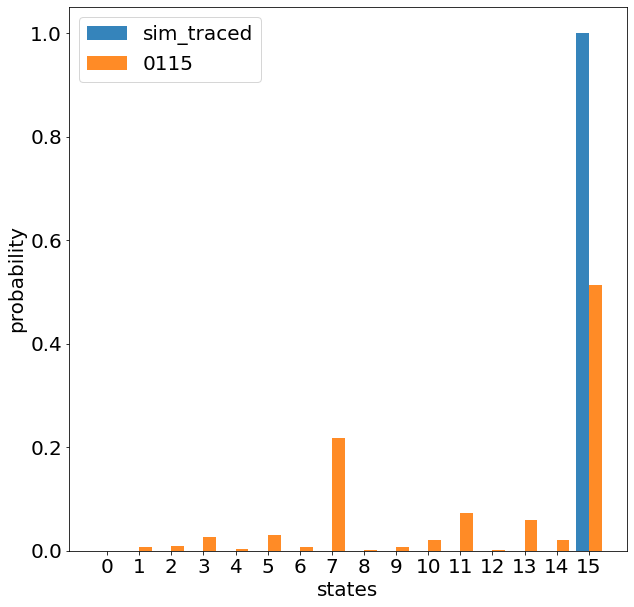

2024-01-15-182126_Line_002.txt
HAD2:RX+51:HAD3:RX+41:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:XA230.2500+:AZ2+1.0000:AZ3+1.0000:XA230.2500+:RX+21:XA230.2500+:AZ3+1.0000:XA230.2500+:RX+21:RX+31:XA230.2500+:RY+21:AZ3+1.0000:XA230.2500+:XA230.2500+:RY+21:AZ3+1.0000:XA230.2500+:AZ2+1.0000:RX+31:XA230.2500+:RY+21:XA230.2500+:RY+21:XA230.2500+:AZ2+1.0000:RY+31:XA230.2500+:RX+21:RX+31:XA230.2500+:XA230.2500+:AZ2+1.0000:RY+31:XA230.2500+:AZ2+1.0000:XA230.2500+:RY+21:RY+31:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



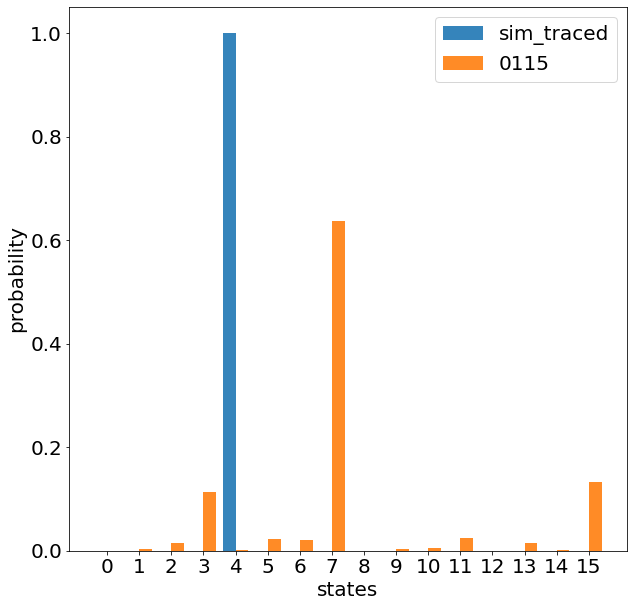

2024-01-15-182220_Line_003.txt
HAD2:RX+51:HAD3:RX+41:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:RX+31:XA230.2500+:RY+21:RY+31:XA230.2500+:RX+21:AZ3+1.0000:XA230.2500+:RX+21:RY+31:XA230.2500+:AZ3+1.0000:XA230.2500+:RX+21:AZ3+1.0000:XA230.2500+:RY+21:XA230.2500+:AZ2+1.0000:RX+31:XA230.2500+:AZ3+1.0000:XA230.2500+:RX+21:RX+31:XA230.2500+:RY+21:RY+31:XA230.2500+:RX+21:AZ3+1.0000:XA230.2500+:AZ3+1.0000:XA230.2500+:RY+21:XA230.2500+:AZ2+1.0000:RY+31:XA230.2500+:AZ2+1.0000:RX+31:XA230.2500+:RX+21:RX+31:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



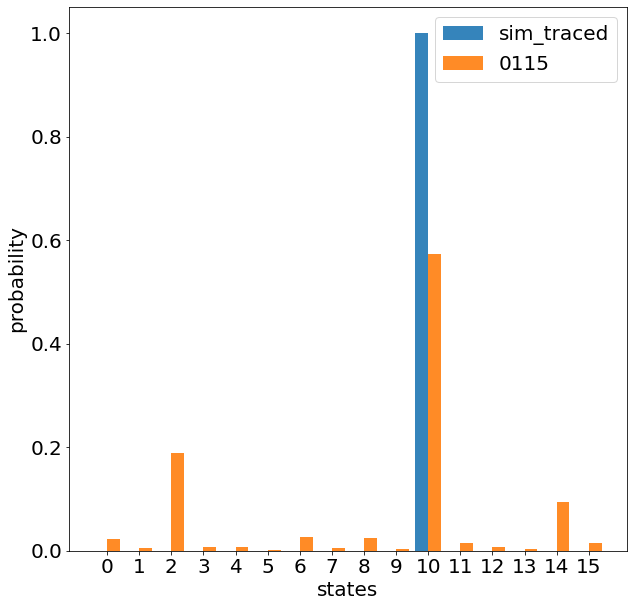

2024-01-15-204632_Line_004.txt
HAD2:RX+51:HAD3:RX+41:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:RY+21:XA230.2500+:AZ3+1.0000:XA230.2500+:RY+21:AZ3+1.0000:XA230.2500+:RY+21:XA230.2500+:RY+21:AZ3+1.0000:XA230.2500+:RX+21:AZ3+1.0000:XA230.2500+:AZ2+1.0000:RX+31:XA230.2500+:AZ2+1.0000:XA230.2500+:RY+21:RY+31:XA230.2500+:RY+21:XA230.2500+:RY+21:RY+31:XA230.2500+:AZ2+1.0000:XA230.2500+:RX+21:RX+31:XA230.2500+:RY+21:RY+31:XA230.2500+:RY+21:RX+31:XA230.2500+:RY+21:RY+31:XA230.2500+:RX+21:RY+31:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



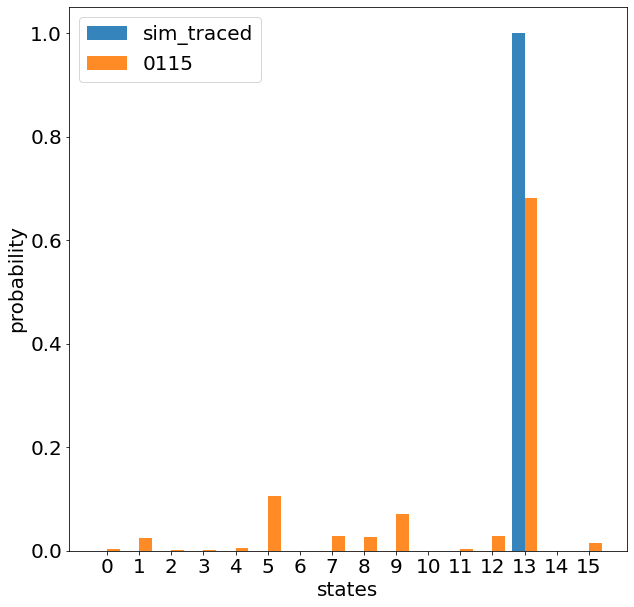

2024-01-15-182449_Line_005.txt
HAD2:RX+51:HAD3:RX+41:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:AZ3+1.0000:XA230.2500+:RX+21:RX+31:XA230.2500+:RX+31:XA230.2500+:AZ2+1.0000:XA230.2500+:RX+21:XA230.2500+:RY+21:AZ3+1.0000:XA230.2500+:RY+21:XA230.2500+:AZ2+1.0000:XA230.2500+:RY+21:XA230.2500+:RX+21:RX+31:XA230.2500+:RY+31:XA230.2500+:XA230.2500+:RY+21:XA230.2500+:RY+21:XA230.2500+:AZ2+1.0000:RX+31:XA230.2500+:RX+21:XA230.2500+:RX+21:RX+31:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



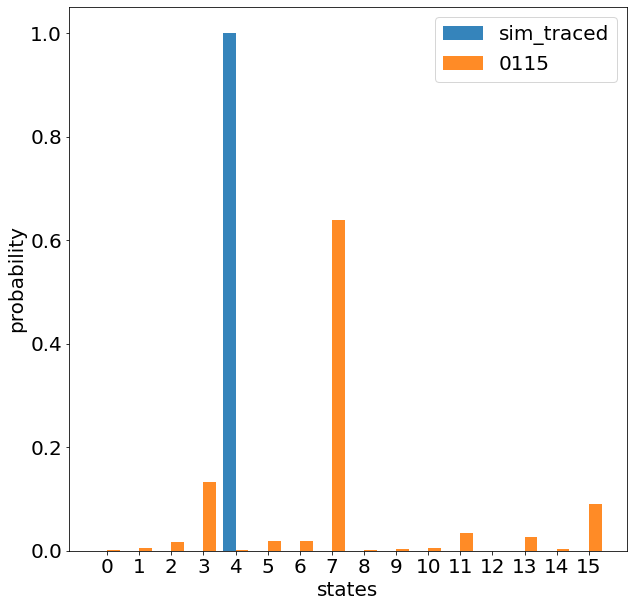

2024-01-15-182544_Line_006.txt
HAD2:RX+51:HAD3:RX+41:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:RY+21:XA230.2500+:RY+21:RY+31:XA230.2500+:AZ2+1.0000:RY+31:XA230.2500+:AZ2+1.0000:AZ3+1.0000:XA230.2500+:RY+21:RX+31:XA230.2500+:RY+21:AZ3+1.0000:XA230.2500+:RX+21:RX+31:XA230.2500+:RY+31:XA230.2500+:AZ3+1.0000:XA230.2500+:AZ2+1.0000:RY+31:XA230.2500+:RY+21:XA230.2500+:RX+21:AZ3+1.0000:XA230.2500+:RX+21:RX+31:XA230.2500+:RY+21:RX+31:XA230.2500+:RY+31:XA230.2500+:RY+31:XA230.2500+:RX+21:AZ3+1.0000:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



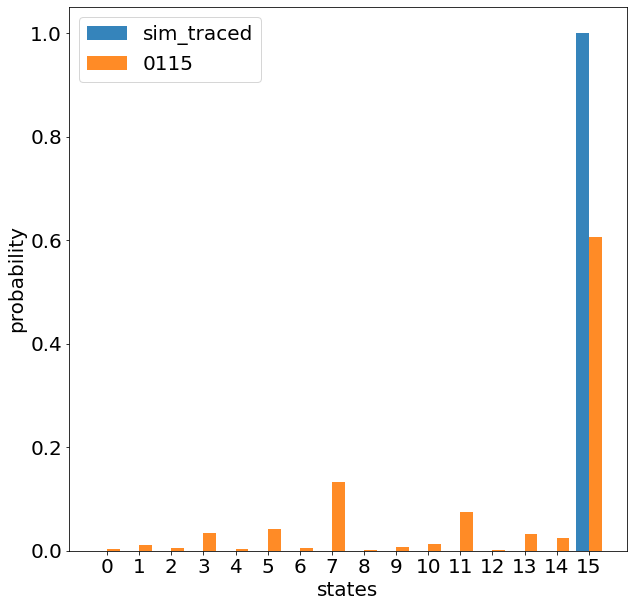

2024-01-15-182717_Line_007.txt
HAD2:RX+51:HAD3:RX+41:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:RY+21:RY+31:XA230.2500+:RY+31:XA230.2500+:RY+21:RY+31:XA230.2500+:RY+21:RY+31:XA230.2500+:RX+21:XA230.2500+:XA230.2500+:AZ3+1.0000:XA230.2500+:AZ3+1.0000:XA230.2500+:AZ2+1.0000:AZ3+1.0000:XA230.2500+:AZ2+1.0000:XA230.2500+:RY+21:RY+31:XA230.2500+:AZ2+1.0000:XA230.2500+:RY+31:XA230.2500+:RY+21:RY+31:XA230.2500+:RX+21:RX+31:XA230.2500+:RX+21:RY+31:XA230.2500+:RX+21:RX+31:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



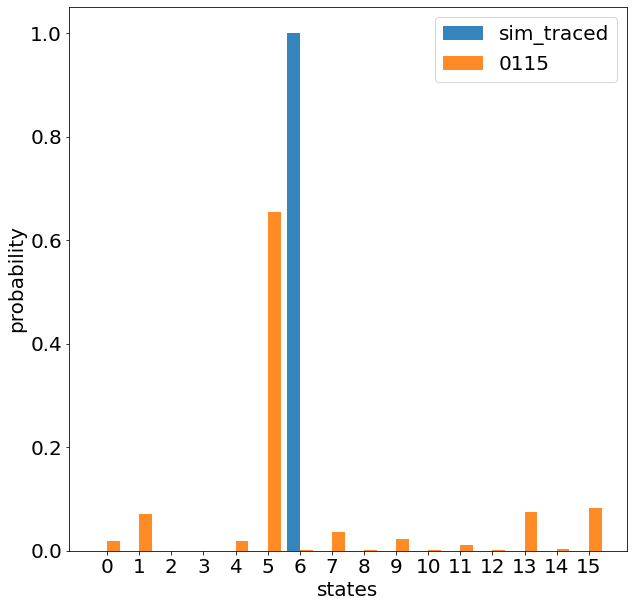

2024-01-15-182810_Line_008.txt
HAD2:RX+51:HAD3:RX+41:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:RX+21:XA230.2500+:RY+31:XA230.2500+:RX+31:XA230.2500+:RY+21:AZ3+1.0000:XA230.2500+:RX+21:RY+31:XA230.2500+:AZ2+1.0000:RX+31:XA230.2500+:RX+21:RX+31:XA230.2500+:RX+21:AZ3+1.0000:XA230.2500+:RY+21:RX+31:XA230.2500+:RX+21:XA230.2500+:AZ2+1.0000:RX+31:XA230.2500+:RX+31:XA230.2500+:AZ3+1.0000:XA230.2500+:RY+21:RX+31:XA230.2500+:RY+21:XA230.2500+:XA230.2500+:AZ3+1.0000:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



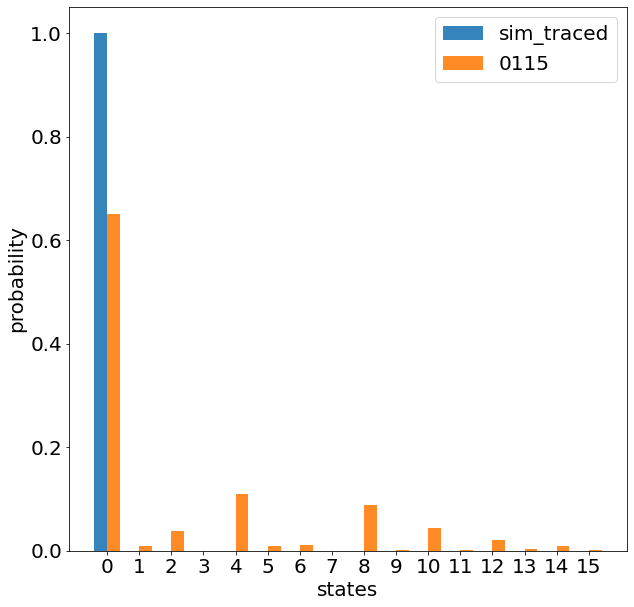

2024-01-15-182904_Line_009.txt
HAD2:RX+51:HAD3:RX+41:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:AZ2+1.0000:RY+31:XA230.2500+:RY+21:RY+31:XA230.2500+:AZ3+1.0000:XA230.2500+:AZ2+1.0000:RX+31:XA230.2500+:RX+21:RX+31:XA230.2500+:RY+21:AZ3+1.0000:XA230.2500+:AZ2+1.0000:AZ3+1.0000:XA230.2500+:RX+21:RY+31:XA230.2500+:AZ3+1.0000:XA230.2500+:RX+21:RX+31:XA230.2500+:RX+21:XA230.2500+:RY+21:XA230.2500+:AZ2+1.0000:XA230.2500+:RY+21:RY+31:XA230.2500+:RX+31:XA230.2500+:RX+21:XA230.2500+:RY+21:RX+31:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



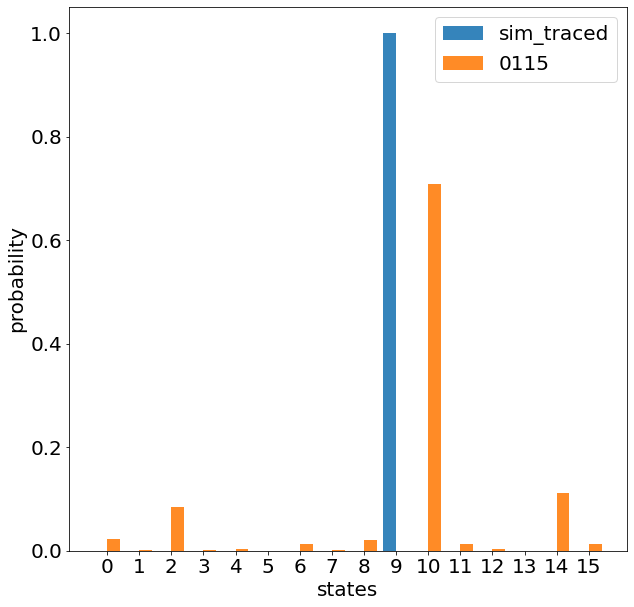

2024-01-15-183036_Line_010.txt
HAD2:RX+51:HAD3:RX+41:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:AZ2+1.0000:AZ3+1.0000:XA230.2500+:RY+21:RY+31:XA230.2500+:AZ2+1.0000:RY+31:XA230.2500+:RX+21:RX+31:XA230.2500+:AZ2+1.0000:RY+31:XA230.2500+:RX+21:AZ3+1.0000:XA230.2500+:RY+21:XA230.2500+:RX+31:XA230.2500+:RY+21:RY+31:XA230.2500+:XA230.2500+:RY+21:AZ3+1.0000:XA230.2500+:RX+31:XA230.2500+:RX+21:AZ3+1.0000:XA230.2500+:RX+21:XA230.2500+:RX+21:RX+31:XA230.2500+:RY+21:RX+31:XA230.2500+:AZ2+1.0000:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



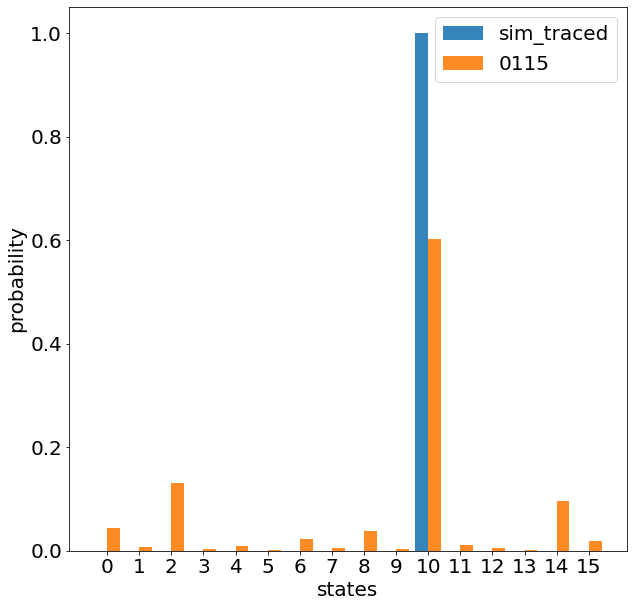

2024-01-15-193907_Line_011.txt
HAD2:RX+51:HAD3:RX+41:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:RX+31:XA230.2500+:RY+21:AZ3+1.0000:XA230.2500+:AZ2+1.0000:RY+31:XA230.2500+:RX+21:RY+31:XA230.2500+:RY+31:XA230.2500+:RX+21:RX+31:XA230.2500+:RY+21:XA230.2500+:AZ2+1.0000:RY+31:XA230.2500+:AZ2+1.0000:AZ3+1.0000:XA230.2500+:AZ2+1.0000:RY+31:XA230.2500+:RX+21:AZ3+1.0000:XA230.2500+:RX+21:XA230.2500+:RX+21:RY+31:XA230.2500+:RX+21:RX+31:XA230.2500+:RY+21:RX+31:XA230.2500+:RX+21:RX+31:XA230.2500+:RX+21:RY+31:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



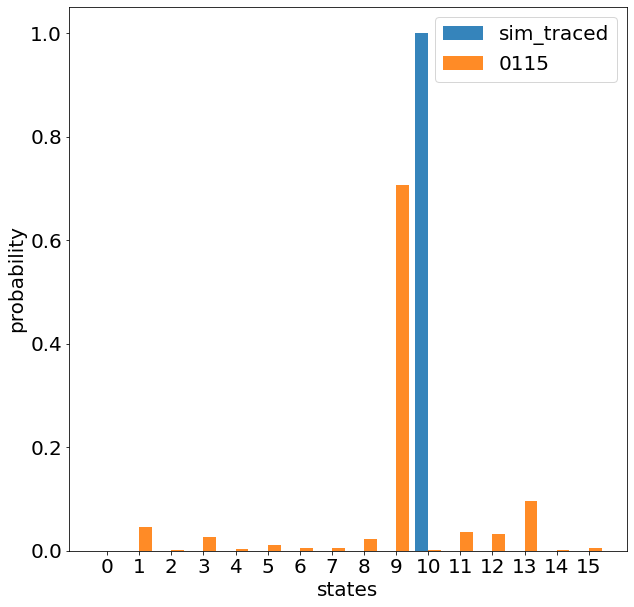

2024-01-15-194001_Line_012.txt
HAD2:RX+51:HAD3:RX+41:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:AZ2+1.0000:RX+31:XA230.2500+:AZ3+1.0000:XA230.2500+:AZ2+1.0000:XA230.2500+:RY+21:RX+31:XA230.2500+:AZ2+1.0000:RY+31:XA230.2500+:RX+21:AZ3+1.0000:XA230.2500+:RY+21:AZ3+1.0000:XA230.2500+:RX+21:AZ3+1.0000:XA230.2500+:RY+31:XA230.2500+:RX+31:XA230.2500+:RX+21:RX+31:XA230.2500+:RY+21:RY+31:XA230.2500+:RY+31:XA230.2500+:AZ3+1.0000:XA230.2500+:AZ2+1.0000:AZ3+1.0000:XA230.2500+:AZ2+1.0000:RY+31:XA230.2500+:RY+21:RX+31:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



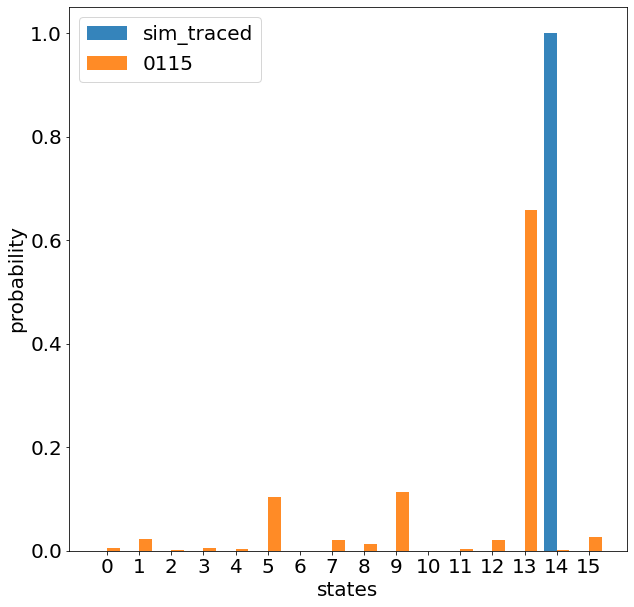

2024-01-15-194053_Line_013.txt
HAD2:RX+51:HAD3:RX+41:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:RX+21:RY+31:XA230.2500+:RX+21:RY+31:XA230.2500+:RY+21:RX+31:XA230.2500+:AZ2+1.0000:XA230.2500+:AZ2+1.0000:RY+31:XA230.2500+:AZ2+1.0000:AZ3+1.0000:XA230.2500+:RX+21:RY+31:XA230.2500+:RY+31:XA230.2500+:RX+21:RX+31:XA230.2500+:RX+21:RY+31:XA230.2500+:RX+21:RX+31:XA230.2500+:AZ2+1.0000:XA230.2500+:AZ2+1.0000:AZ3+1.0000:XA230.2500+:RY+21:RY+31:XA230.2500+:RX+21:XA230.2500+:AZ2+1.0000:XA230.2500+:AZ3+1.0000:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



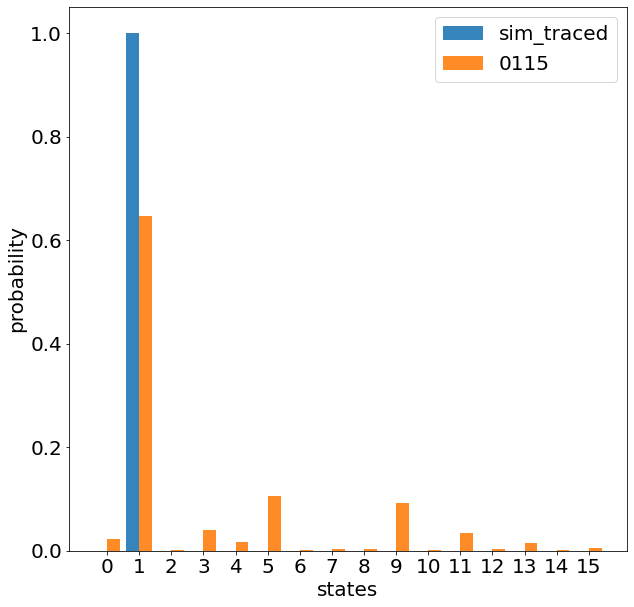

2024-01-15-194146_Line_014.txt
HAD2:RX+51:HAD3:RX+41:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:RY+21:RX+31:XA230.2500+:XA230.2500+:RX+21:RY+31:XA230.2500+:RX+31:XA230.2500+:AZ2+1.0000:XA230.2500+:RY+21:RY+31:XA230.2500+:AZ3+1.0000:XA230.2500+:RX+21:RY+31:XA230.2500+:RY+21:XA230.2500+:RX+21:AZ3+1.0000:XA230.2500+:AZ2+1.0000:AZ3+1.0000:XA230.2500+:RX+21:RY+31:XA230.2500+:AZ2+1.0000:RY+31:XA230.2500+:RY+31:XA230.2500+:AZ2+1.0000:RX+31:XA230.2500+:AZ2+1.0000:AZ3+1.0000:XA230.2500+:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



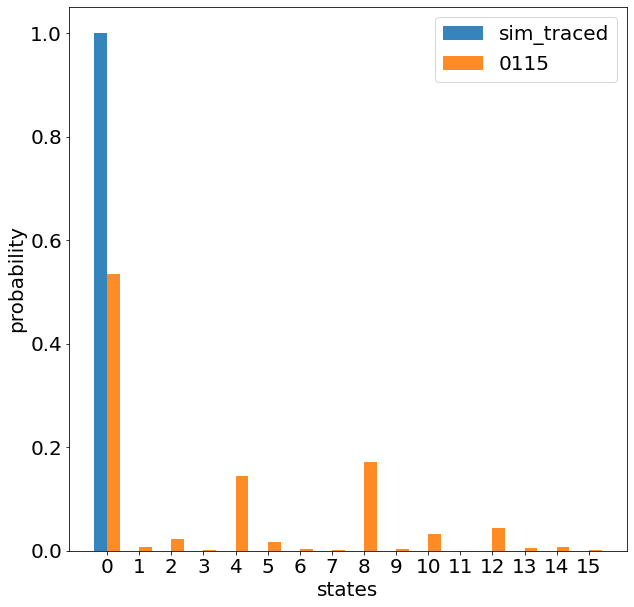

2024-01-15-194316_Line_015.txt
HAD2:RX+51:HAD3:RX+41:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:XA230.2500+:AZ2+1.0000:RX+31:XA230.2500+:AZ2+1.0000:RX+31:XA230.2500+:AZ2+1.0000:XA230.2500+:XA230.2500+:AZ2+1.0000:XA230.2500+:AZ2+1.0000:RX+31:XA230.2500+:AZ2+1.0000:RY+31:XA230.2500+:RX+21:RX+31:XA230.2500+:RY+21:AZ3+1.0000:XA230.2500+:AZ2+1.0000:RX+31:XA230.2500+:XA230.2500+:AZ2+1.0000:RX+31:XA230.2500+:AZ2+1.0000:XA230.2500+:AZ3+1.0000:XA230.2500+:RX+21:XA230.2500+:RY+21:AZ3+1.0000:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



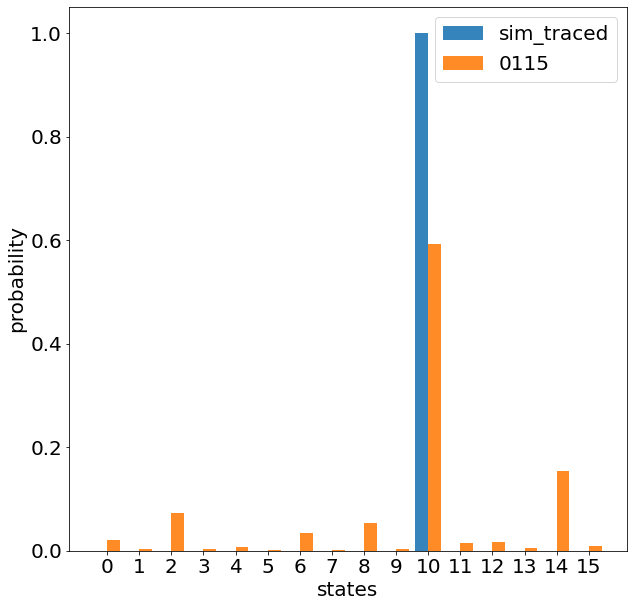

2024-01-15-194410_Line_016.txt
HAD2:RX+51:HAD3:RX+41:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:RX+31:XA230.2500+:RY+21:RX+31:XA230.2500+:RY+21:AZ3+1.0000:XA230.2500+:AZ2+1.0000:AZ3+1.0000:XA230.2500+:RX+21:AZ3+1.0000:XA230.2500+:RX+21:RX+31:XA230.2500+:AZ2+1.0000:AZ3+1.0000:XA230.2500+:RY+21:XA230.2500+:RX+21:XA230.2500+:AZ3+1.0000:XA230.2500+:RY+21:AZ3+1.0000:XA230.2500+:AZ2+1.0000:RY+31:XA230.2500+:RY+31:XA230.2500+:RX+21:XA230.2500+:RX+21:RX+31:XA230.2500+:RY+21:RY+31:XA230.2500+:RX+31:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



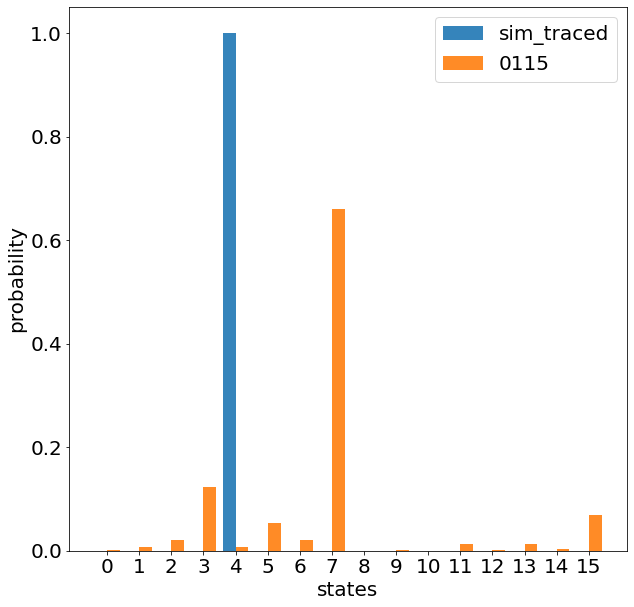

2024-01-15-194504_Line_017.txt
HAD2:RX+51:HAD3:RX+41:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:RY+21:RY+31:XA230.2500+:RX+21:RY+31:XA230.2500+:AZ3+1.0000:XA230.2500+:RY+21:XA230.2500+:RY+21:AZ3+1.0000:XA230.2500+:AZ2+1.0000:RX+31:XA230.2500+:AZ2+1.0000:RX+31:XA230.2500+:XA230.2500+:RX+21:AZ3+1.0000:XA230.2500+:AZ2+1.0000:AZ3+1.0000:XA230.2500+:RY+21:RY+31:XA230.2500+:RX+31:XA230.2500+:RY+21:AZ3+1.0000:XA230.2500+:RX+21:RY+31:XA230.2500+:RY+21:AZ3+1.0000:XA230.2500+:RY+21:RX+31:XA230.2500+:AZ3+1.0000:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



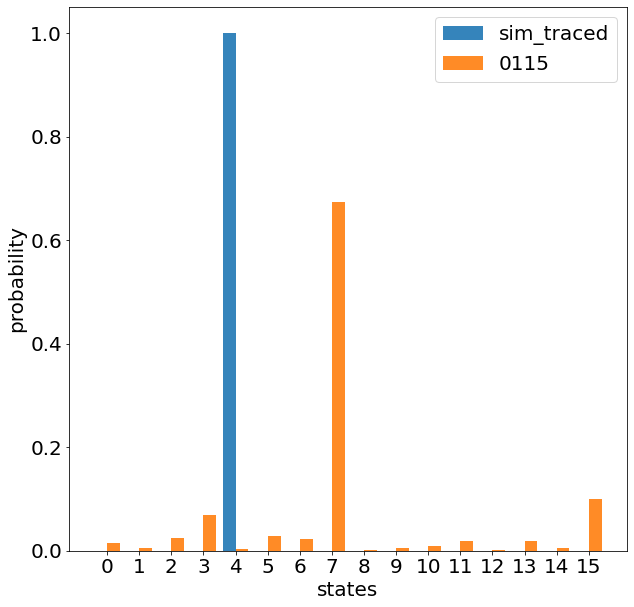

2024-01-15-194557_Line_018.txt
HAD2:RX+51:HAD3:RX+41:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:RY+21:AZ3+1.0000:XA230.2500+:AZ3+1.0000:XA230.2500+:AZ2+1.0000:XA230.2500+:AZ2+1.0000:RX+31:XA230.2500+:RY+31:XA230.2500+:RX+31:XA230.2500+:RY+21:AZ3+1.0000:XA230.2500+:RX+21:RY+31:XA230.2500+:AZ2+1.0000:RX+31:XA230.2500+:RX+21:XA230.2500+:RX+31:XA230.2500+:RX+21:RX+31:XA230.2500+:AZ2+1.0000:RX+31:XA230.2500+:AZ2+1.0000:XA230.2500+:AZ2+1.0000:XA230.2500+:RX+31:XA230.2500+:RY+31:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



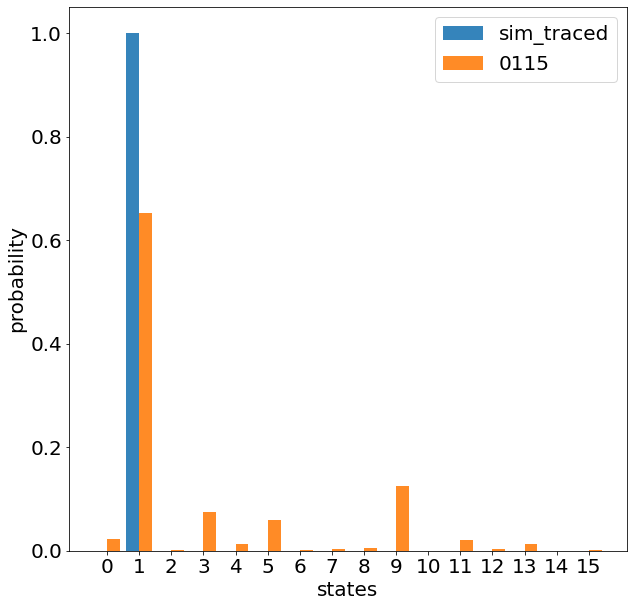

2024-01-15-194729_Line_019.txt
HAD2:RX+51:HAD3:RX+41:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:XA230.2500+:RX+21:AZ3+1.0000:XA230.2500+:AZ2+1.0000:XA230.2500+:RX+31:XA230.2500+:RY+21:XA230.2500+:XA230.2500+:AZ2+1.0000:XA230.2500+:RX+21:AZ3+1.0000:XA230.2500+:RY+31:XA230.2500+:RX+21:RX+31:XA230.2500+:RX+21:RY+31:XA230.2500+:RY+31:XA230.2500+:RX+21:AZ3+1.0000:XA230.2500+:AZ2+1.0000:RY+31:XA230.2500+:XA230.2500+:RY+31:XA230.2500+:RX+21:RX+31:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



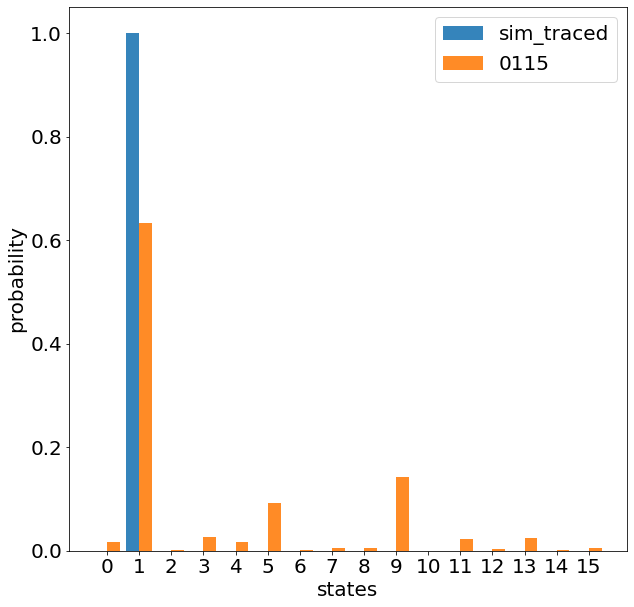

2024-01-15-194822_Line_020.txt
HAD2:RX+51:HAD3:RX+41:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:RX+31:XA230.2500+:RX+21:RX+31:XA230.2500+:RY+21:RY+31:XA230.2500+:AZ2+1.0000:RX+31:XA230.2500+:RX+21:XA230.2500+:RY+21:RY+31:XA230.2500+:RX+31:XA230.2500+:XA230.2500+:RY+21:XA230.2500+:RY+21:XA230.2500+:AZ2+1.0000:RX+31:XA230.2500+:RX+31:XA230.2500+:RY+21:AZ3+1.0000:XA230.2500+:AZ2+1.0000:RY+31:XA230.2500+:XA230.2500+:RY+21:RY+31:XA230.2500+:AZ2+1.0000:RX+31:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



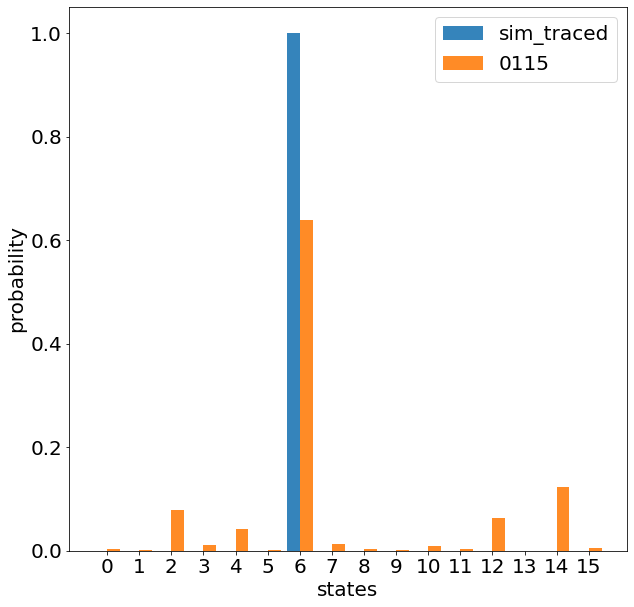

In [15]:
filenames_data=[]
counts_d16=[]
counts_d16_spam=[]
counts=[]
counts_spam=[]
filenames_data=filenames_d16_0115.copy()
print (filenames_data)
# # print (len(filenames_data))
paf_data=paf_data_d16_0115
circuit=c_d16
for i in range (len(filenames_data)):
    print (filenames_data[i])
    a.Import(paf_data+filenames_data[i],keep_file=True)
    data_traced=Trace_Out(a,[0,1,2,3])
    counts=[round(shots*x) for x in  data_traced.population]
    counts_ibm_mapping, counts_ibm_mapping_dic=map_statepop_2_ibm_mapping(counts,nqubit)
    counts_d16.append(counts_ibm_mapping_dic)
    
#     a_s=spam1.Correct_SPAM(a)
#     data_traced_spam=Trace_Out(a_s,[0,1,2,3])
#     counts_spam=[round(shots*x) for x in  data_traced_spam.population]
#     counts_ibm_mapping_spam, counts_ibm_mapping_dic_spam=map_statepop_2_ibm_mapping(counts_spam,nqubit)
#     counts_d8_spam.append(counts_ibm_mapping_dic_spam)
    
#     a_0703.Import(paf_data_d16_0115+filenames_d16_0115[i],keep_file=True)
#     data_0703_traced=Trace_Out(a_0703,[0,1,2,3])
    
    b_c.Interpret_GatesLab_Sequence(circuit[i])
    print (circuit[i])
    b=b_c.Simulate()
    sim_traced=Trace_Out(b,[0,1,2,3])
#     Display_States_Population(states=[b,a,a_s],label=["simulation","d=8","spam"])
    Display_States_Population(states=[sim_traced,data_traced],label=["sim_traced","0115"])

['2024-01-15-183507_Line_001.txt', '2024-01-15-183643_Line_002.txt', '2024-01-15-183858_Line_003.txt', '2024-01-15-184038_Line_004.txt', '2024-01-15-184255_Line_005.txt', '2024-01-15-184434_Line_006.txt', '2024-01-15-184652_Line_007.txt', '2024-01-15-184830_Line_008.txt', '2024-01-15-185046_Line_009.txt', '2024-01-15-185224_Line_010.txt', '2024-01-15-191945_Line_011.txt', '2024-01-15-192123_Line_012.txt', '2024-01-15-192258_Line_013.txt', '2024-01-15-192516_Line_014.txt', '2024-01-15-192655_Line_015.txt', '2024-01-15-192834_Line_016.txt', '2024-01-15-193048_Line_017.txt', '2024-01-15-193223_Line_018.txt', '2024-01-15-193401_Line_019.txt', '2024-01-15-193617_Line_020.txt']
2024-01-15-183507_Line_001.txt
HAD2:RX+51:HAD3:RX+41:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:AZ3+1.0000:XA230.2500+:AZ2+1.0000:XA230.2500+:RX+21:XA230.2500+:AZ2+1.0000:RX+31:XA230.2500+:RY+31:XA230.2500+:AZ3+1.0000:XA230.2500+:RX+21:RY+31:XA230.2500+:RX+21:RX+31:XA230.2500+:RY

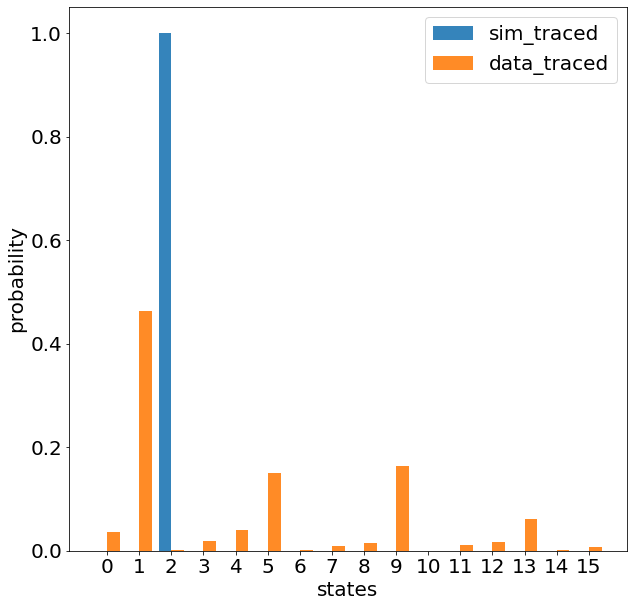

2024-01-15-183643_Line_002.txt
HAD2:RX+51:HAD3:RX+41:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:AZ3+1.0000:XA230.2500+:RY+21:RY+31:XA230.2500+:RX+21:AZ3+1.0000:XA230.2500+:RX+21:RX+31:XA230.2500+:AZ2+1.0000:XA230.2500+:RY+21:AZ3+1.0000:XA230.2500+:RY+21:RX+31:XA230.2500+:AZ2+1.0000:XA230.2500+:XA230.2500+:AZ2+1.0000:RY+31:XA230.2500+:AZ2+1.0000:XA230.2500+:RY+21:RY+31:XA230.2500+:AZ2+1.0000:AZ3+1.0000:XA230.2500+:RY+21:AZ3+1.0000:XA230.2500+:RX+21:XA230.2500+:RY+21:AZ3+1.0000:XA230.2500+:RY+31:XA230.2500+:RX+21:RY+31:XA230.2500+:AZ2+1.0000:RY+31:XA230.2500+:RY+21:RY+31:XA230.2500+:RY+21:XA230.2500+:AZ3+1.0000:XA230.2500+:AZ2+1.0000:XA230.2500+:AZ2+1.0000:AZ3+1.0000:XA230.2500+:RX+21:RY+31:XA230.2500+:AZ2+1.0000:RY+31:XA230.2500+:AZ2+1.0000:XA230.2500+:RX+21:RY+31:XA230.2500+:RX+21:RX+31:XA230.2500+:AZ2+1.0000:RX+31:XA230.2500+:RY+31:XA230.2500+:XA230.2500+:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3


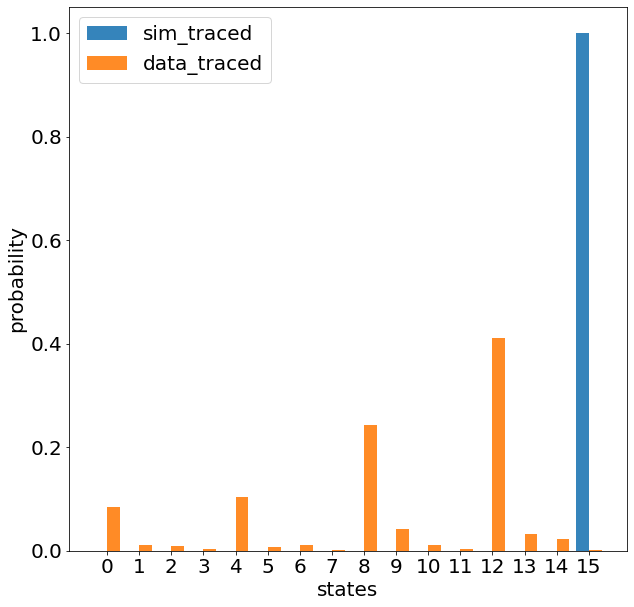

2024-01-15-183858_Line_003.txt
HAD2:RX+51:HAD3:RX+41:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:AZ2+1.0000:XA230.2500+:AZ2+1.0000:XA230.2500+:RY+21:RY+31:XA230.2500+:RY+21:XA230.2500+:RY+21:XA230.2500+:AZ3+1.0000:XA230.2500+:RY+21:AZ3+1.0000:XA230.2500+:RX+21:RY+31:XA230.2500+:RX+21:AZ3+1.0000:XA230.2500+:RX+21:AZ3+1.0000:XA230.2500+:RX+31:XA230.2500+:RX+21:RX+31:XA230.2500+:AZ2+1.0000:RY+31:XA230.2500+:RX+21:RX+31:XA230.2500+:AZ3+1.0000:XA230.2500+:AZ3+1.0000:XA230.2500+:RX+21:XA230.2500+:XA230.2500+:RX+21:XA230.2500+:RX+21:XA230.2500+:AZ2+1.0000:RY+31:XA230.2500+:RY+21:RX+31:XA230.2500+:AZ3+1.0000:XA230.2500+:RY+21:AZ3+1.0000:XA230.2500+:AZ2+1.0000:XA230.2500+:RX+21:RX+31:XA230.2500+:RX+21:XA230.2500+:AZ2+1.0000:RY+31:XA230.2500+:RX+31:XA230.2500+:RY+31:XA230.2500+:RX+21:AZ3+1.0000:XA230.2500+:RX+21:AZ3+1.0000:XA230.2500+:RX+21:RX+31:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



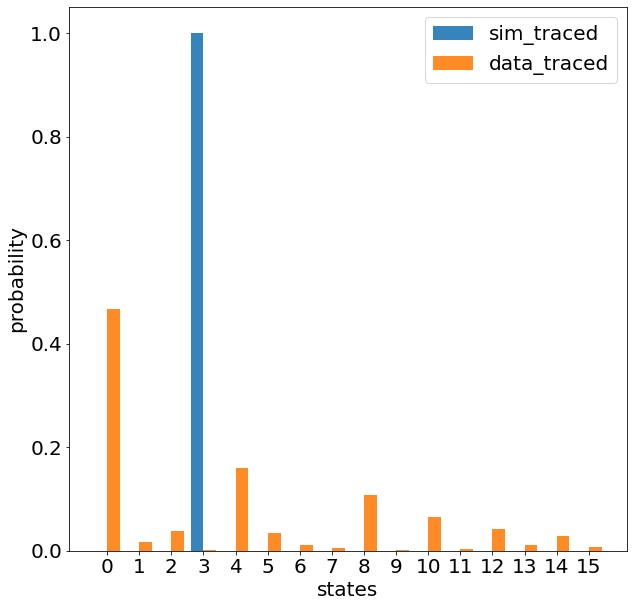

2024-01-15-184038_Line_004.txt
HAD2:RX+51:HAD3:RX+41:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:RY+21:RX+31:XA230.2500+:AZ2+1.0000:RY+31:XA230.2500+:RX+31:XA230.2500+:RX+31:XA230.2500+:RX+21:AZ3+1.0000:XA230.2500+:AZ2+1.0000:RX+31:XA230.2500+:RX+21:RX+31:XA230.2500+:AZ2+1.0000:RY+31:XA230.2500+:RY+21:XA230.2500+:AZ2+1.0000:AZ3+1.0000:XA230.2500+:RY+21:RX+31:XA230.2500+:AZ2+1.0000:RY+31:XA230.2500+:RY+21:AZ3+1.0000:XA230.2500+:RY+21:AZ3+1.0000:XA230.2500+:RY+21:RX+31:XA230.2500+:RY+21:RY+31:XA230.2500+:RY+31:XA230.2500+:AZ2+1.0000:XA230.2500+:RY+21:RX+31:XA230.2500+:RX+21:AZ3+1.0000:XA230.2500+:RX+21:XA230.2500+:AZ2+1.0000:AZ3+1.0000:XA230.2500+:RX+21:RY+31:XA230.2500+:RX+21:XA230.2500+:RY+31:XA230.2500+:RY+21:RY+31:XA230.2500+:RX+31:XA230.2500+:RX+21:AZ3+1.0000:XA230.2500+:RX+21:AZ3+1.0000:XA230.2500+:AZ2+1.0000:XA230.2500+:RY+21:AZ3+1.0000:XA230.2500+:RX+21:XA230.2500+:RX+31:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:A

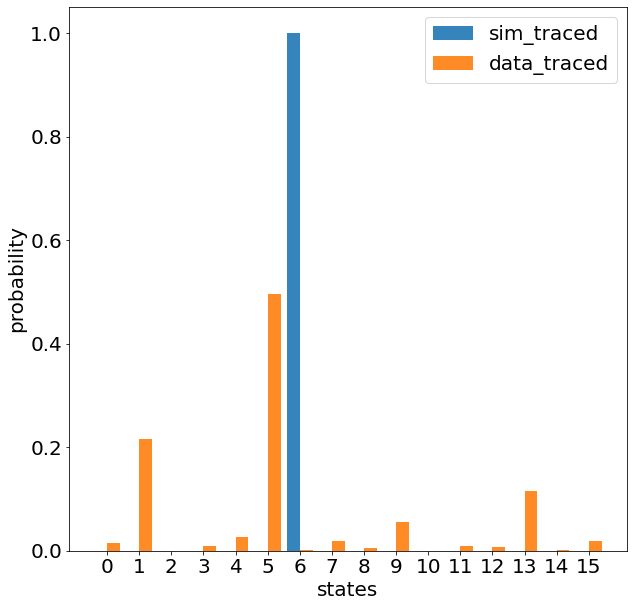

2024-01-15-184255_Line_005.txt
HAD2:RX+51:HAD3:RX+41:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:RY+21:RY+31:XA230.2500+:AZ2+1.0000:XA230.2500+:AZ2+1.0000:XA230.2500+:RY+21:XA230.2500+:RX+21:RX+31:XA230.2500+:RX+21:RX+31:XA230.2500+:RX+21:XA230.2500+:AZ2+1.0000:XA230.2500+:RY+21:RX+31:XA230.2500+:RX+31:XA230.2500+:RY+21:AZ3+1.0000:XA230.2500+:AZ2+1.0000:RX+31:XA230.2500+:RY+21:RX+31:XA230.2500+:XA230.2500+:RY+21:XA230.2500+:RX+31:XA230.2500+:RX+21:RX+31:XA230.2500+:AZ2+1.0000:AZ3+1.0000:XA230.2500+:RY+21:RX+31:XA230.2500+:RX+21:AZ3+1.0000:XA230.2500+:AZ2+1.0000:RY+31:XA230.2500+:RX+21:RY+31:XA230.2500+:RX+21:RY+31:XA230.2500+:RY+21:XA230.2500+:RY+31:XA230.2500+:RX+31:XA230.2500+:RY+31:XA230.2500+:AZ2+1.0000:RY+31:XA230.2500+:RY+21:XA230.2500+:RX+21:XA230.2500+:RX+21:RY+31:XA230.2500+:AZ2+1.0000:AZ3+1.0000:XA230.2500+:AZ2+1.0000:AZ3+1.0000:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



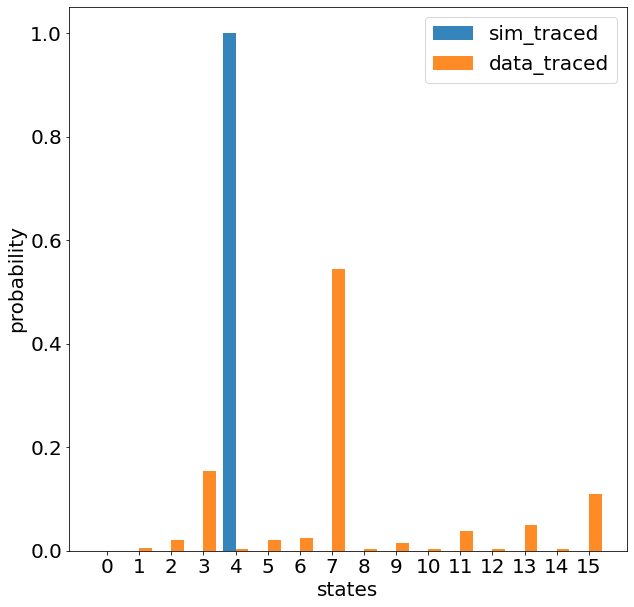

2024-01-15-184434_Line_006.txt
HAD2:RX+51:HAD3:RX+41:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:AZ2+1.0000:RY+31:XA230.2500+:RX+21:RX+31:XA230.2500+:RX+31:XA230.2500+:RY+21:RX+31:XA230.2500+:AZ3+1.0000:XA230.2500+:RX+21:RY+31:XA230.2500+:RX+21:XA230.2500+:RY+21:RY+31:XA230.2500+:RX+21:RX+31:XA230.2500+:RX+21:RY+31:XA230.2500+:AZ2+1.0000:XA230.2500+:RX+21:AZ3+1.0000:XA230.2500+:XA230.2500+:AZ3+1.0000:XA230.2500+:RY+21:RX+31:XA230.2500+:RX+21:RY+31:XA230.2500+:RX+21:AZ3+1.0000:XA230.2500+:RY+21:RX+31:XA230.2500+:AZ3+1.0000:XA230.2500+:RY+31:XA230.2500+:RY+21:AZ3+1.0000:XA230.2500+:AZ2+1.0000:AZ3+1.0000:XA230.2500+:RX+21:RX+31:XA230.2500+:AZ2+1.0000:RY+31:XA230.2500+:RY+31:XA230.2500+:AZ2+1.0000:RX+31:XA230.2500+:AZ2+1.0000:AZ3+1.0000:XA230.2500+:RX+21:RX+31:XA230.2500+:RX+21:AZ3+1.0000:XA230.2500+:RX+21:RX+31:XA230.2500+:RY+21:AZ3+1.0000:XA230.2500+:RY+31:XA230.2500+:RX+21:AZ3+1.0000:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:R

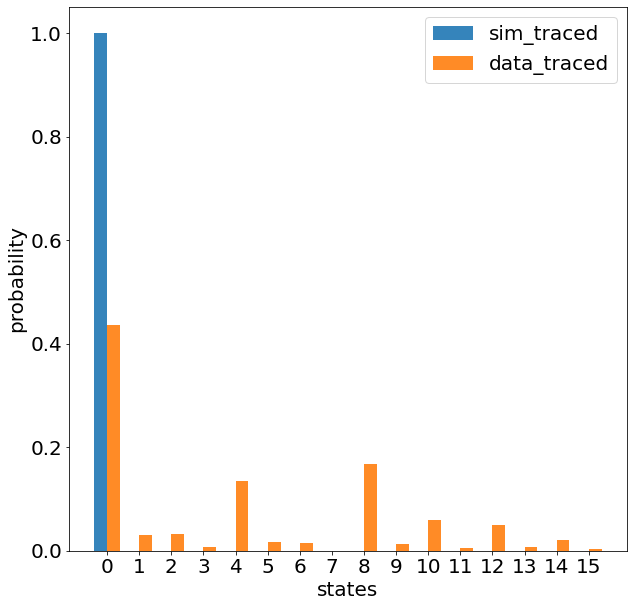

2024-01-15-184652_Line_007.txt
HAD2:RX+51:HAD3:RX+41:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:AZ2+1.0000:RY+31:XA230.2500+:RY+21:XA230.2500+:AZ2+1.0000:AZ3+1.0000:XA230.2500+:RX+21:RX+31:XA230.2500+:AZ2+1.0000:AZ3+1.0000:XA230.2500+:RX+21:RY+31:XA230.2500+:AZ2+1.0000:RY+31:XA230.2500+:AZ2+1.0000:RY+31:XA230.2500+:AZ3+1.0000:XA230.2500+:RY+21:XA230.2500+:RY+21:XA230.2500+:RY+21:RY+31:XA230.2500+:RY+31:XA230.2500+:AZ2+1.0000:AZ3+1.0000:XA230.2500+:RY+31:XA230.2500+:AZ2+1.0000:RY+31:XA230.2500+:RX+21:RX+31:XA230.2500+:RY+21:RX+31:XA230.2500+:AZ2+1.0000:AZ3+1.0000:XA230.2500+:RX+21:RX+31:XA230.2500+:RY+31:XA230.2500+:RX+21:XA230.2500+:RX+21:XA230.2500+:RY+21:RX+31:XA230.2500+:RY+21:XA230.2500+:XA230.2500+:RY+21:XA230.2500+:AZ2+1.0000:RY+31:XA230.2500+:AZ2+1.0000:RY+31:XA230.2500+:RY+21:RY+31:XA230.2500+:RX+21:RX+31:XA230.2500+:RX+31:XA230.2500+:RX+21:RX+31:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



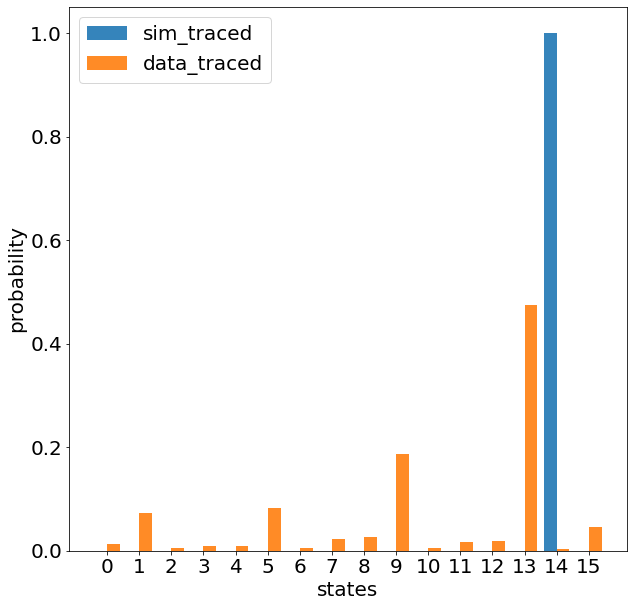

2024-01-15-184830_Line_008.txt
HAD2:RX+51:HAD3:RX+41:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:AZ2+1.0000:RY+31:XA230.2500+:RX+21:XA230.2500+:RX+21:AZ3+1.0000:XA230.2500+:RX+21:AZ3+1.0000:XA230.2500+:RX+21:RY+31:XA230.2500+:RY+21:RY+31:XA230.2500+:RX+31:XA230.2500+:RX+21:RY+31:XA230.2500+:AZ3+1.0000:XA230.2500+:AZ2+1.0000:AZ3+1.0000:XA230.2500+:AZ3+1.0000:XA230.2500+:AZ3+1.0000:XA230.2500+:RY+21:RY+31:XA230.2500+:AZ2+1.0000:RY+31:XA230.2500+:AZ2+1.0000:XA230.2500+:AZ2+1.0000:RY+31:XA230.2500+:AZ2+1.0000:AZ3+1.0000:XA230.2500+:RX+21:RY+31:XA230.2500+:AZ2+1.0000:RX+31:XA230.2500+:RY+31:XA230.2500+:RY+31:XA230.2500+:RY+21:RX+31:XA230.2500+:RX+21:RY+31:XA230.2500+:AZ2+1.0000:AZ3+1.0000:XA230.2500+:RY+21:XA230.2500+:RY+21:AZ3+1.0000:XA230.2500+:RY+21:RX+31:XA230.2500+:RX+21:XA230.2500+:AZ2+1.0000:AZ3+1.0000:XA230.2500+:RX+21:AZ3+1.0000:XA230.2500+:RY+21:RY+31:XA230.2500+:RY+21:XA230.2500+:AZ2+1.0000:RX+31:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32

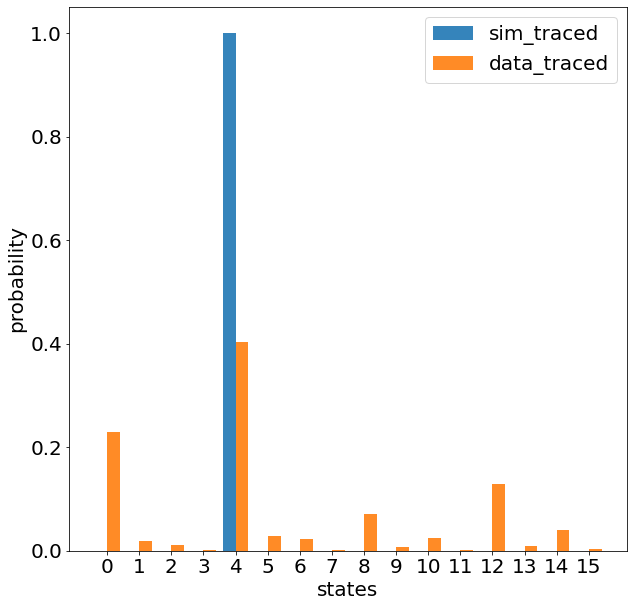

2024-01-15-185046_Line_009.txt
HAD2:RX+51:HAD3:RX+41:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:RY+21:RX+31:XA230.2500+:AZ2+1.0000:RY+31:XA230.2500+:XA230.2500+:RY+21:RX+31:XA230.2500+:RY+21:AZ3+1.0000:XA230.2500+:RY+21:RY+31:XA230.2500+:RX+21:XA230.2500+:RY+21:XA230.2500+:RX+21:RX+31:XA230.2500+:RX+21:RX+31:XA230.2500+:AZ2+1.0000:AZ3+1.0000:XA230.2500+:RY+21:XA230.2500+:AZ2+1.0000:RX+31:XA230.2500+:AZ2+1.0000:XA230.2500+:AZ2+1.0000:AZ3+1.0000:XA230.2500+:AZ2+1.0000:RX+31:XA230.2500+:RY+21:RY+31:XA230.2500+:RX+21:RY+31:XA230.2500+:AZ2+1.0000:RX+31:XA230.2500+:RX+21:AZ3+1.0000:XA230.2500+:RX+31:XA230.2500+:RY+21:XA230.2500+:RX+21:RX+31:XA230.2500+:AZ2+1.0000:XA230.2500+:AZ2+1.0000:AZ3+1.0000:XA230.2500+:RY+21:XA230.2500+:RY+21:RX+31:XA230.2500+:AZ3+1.0000:XA230.2500+:XA230.2500+:RX+21:RX+31:XA230.2500+:XA230.2500+:RX+21:AZ3+1.0000:XA230.2500+:RY+21:RX+31:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



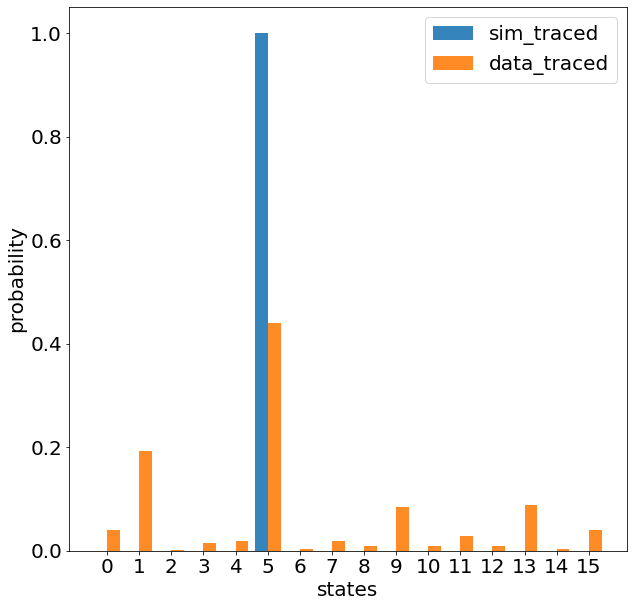

2024-01-15-185224_Line_010.txt
HAD2:RX+51:HAD3:RX+41:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:RY+21:AZ3+1.0000:XA230.2500+:RY+31:XA230.2500+:RX+21:RY+31:XA230.2500+:AZ2+1.0000:RY+31:XA230.2500+:XA230.2500+:AZ2+1.0000:RX+31:XA230.2500+:RX+21:RX+31:XA230.2500+:RY+21:RX+31:XA230.2500+:RX+21:AZ3+1.0000:XA230.2500+:RX+21:XA230.2500+:AZ2+1.0000:RX+31:XA230.2500+:RX+31:XA230.2500+:RY+21:XA230.2500+:RX+21:RX+31:XA230.2500+:AZ2+1.0000:XA230.2500+:RY+21:XA230.2500+:RX+31:XA230.2500+:XA230.2500+:RX+31:XA230.2500+:AZ3+1.0000:XA230.2500+:XA230.2500+:AZ2+1.0000:RX+31:XA230.2500+:RY+21:AZ3+1.0000:XA230.2500+:RY+21:RY+31:XA230.2500+:RX+21:RY+31:XA230.2500+:RX+21:AZ3+1.0000:XA230.2500+:RX+31:XA230.2500+:RY+31:XA230.2500+:XA230.2500+:RX+21:AZ3+1.0000:XA230.2500+:RX+21:RX+31:XA230.2500+:AZ2+1.0000:RY+31:XA230.2500+:AZ2+1.0000:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



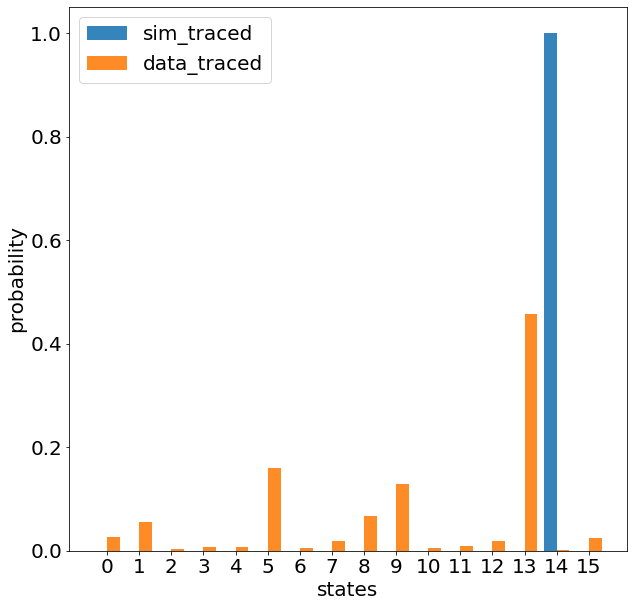

2024-01-15-191945_Line_011.txt
HAD2:RX+51:HAD3:RX+41:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:RY+21:AZ3+1.0000:XA230.2500+:AZ3+1.0000:XA230.2500+:RY+21:RX+31:XA230.2500+:AZ3+1.0000:XA230.2500+:AZ3+1.0000:XA230.2500+:RX+21:RX+31:XA230.2500+:XA230.2500+:XA230.2500+:RY+31:XA230.2500+:AZ2+1.0000:AZ3+1.0000:XA230.2500+:RX+21:XA230.2500+:AZ2+1.0000:RX+31:XA230.2500+:RY+31:XA230.2500+:AZ2+1.0000:RY+31:XA230.2500+:AZ2+1.0000:RX+31:XA230.2500+:AZ2+1.0000:RX+31:XA230.2500+:RY+21:XA230.2500+:RX+21:AZ3+1.0000:XA230.2500+:RY+21:XA230.2500+:AZ2+1.0000:RY+31:XA230.2500+:AZ2+1.0000:XA230.2500+:RX+21:XA230.2500+:RY+21:XA230.2500+:RX+31:XA230.2500+:RY+21:RY+31:XA230.2500+:RX+21:AZ3+1.0000:XA230.2500+:RY+31:XA230.2500+:AZ2+1.0000:XA230.2500+:AZ2+1.0000:RX+31:XA230.2500+:RY+21:RX+31:XA230.2500+:XA230.2500+:RY+21:XA230.2500+:AZ2+1.0000:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



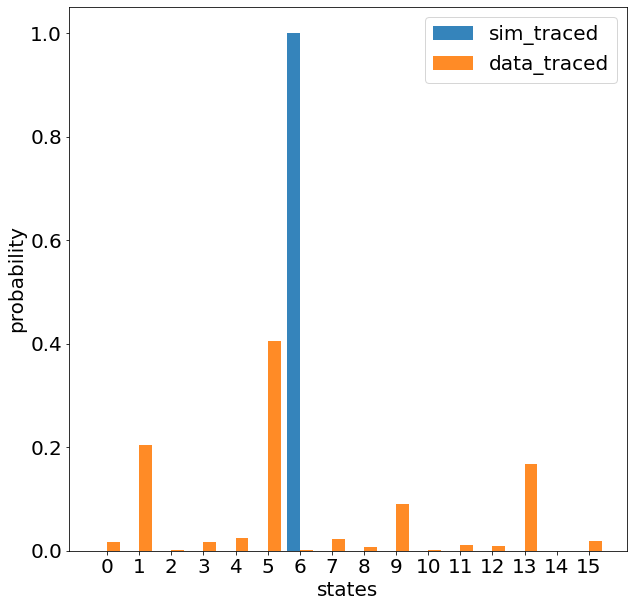

2024-01-15-192123_Line_012.txt
HAD2:RX+51:HAD3:RX+41:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:AZ2+1.0000:XA230.2500+:AZ2+1.0000:RX+31:XA230.2500+:RX+31:XA230.2500+:AZ3+1.0000:XA230.2500+:AZ2+1.0000:AZ3+1.0000:XA230.2500+:RY+21:XA230.2500+:RY+21:RX+31:XA230.2500+:RX+21:RY+31:XA230.2500+:AZ2+1.0000:XA230.2500+:RX+21:AZ3+1.0000:XA230.2500+:AZ2+1.0000:XA230.2500+:AZ2+1.0000:RY+31:XA230.2500+:AZ3+1.0000:XA230.2500+:RY+21:RX+31:XA230.2500+:RY+21:RY+31:XA230.2500+:RY+21:RX+31:XA230.2500+:RY+31:XA230.2500+:RX+21:AZ3+1.0000:XA230.2500+:AZ2+1.0000:RY+31:XA230.2500+:RY+21:AZ3+1.0000:XA230.2500+:RY+21:RY+31:XA230.2500+:AZ2+1.0000:RX+31:XA230.2500+:AZ2+1.0000:RY+31:XA230.2500+:RY+21:XA230.2500+:RY+21:RX+31:XA230.2500+:RY+21:RX+31:XA230.2500+:RX+21:XA230.2500+:RY+21:RX+31:XA230.2500+:AZ3+1.0000:XA230.2500+:RY+21:XA230.2500+:RY+31:XA230.2500+:AZ2+1.0000:AZ3+1.0000:XA230.2500+:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD

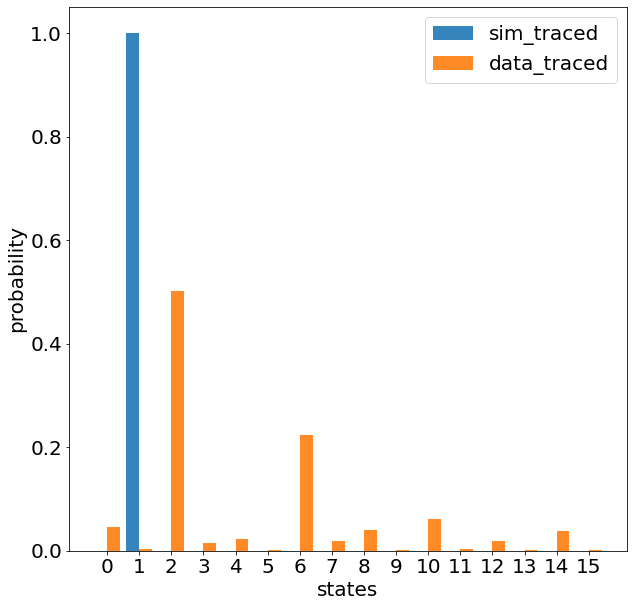

2024-01-15-192258_Line_013.txt
HAD2:RX+51:HAD3:RX+41:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:RY+31:XA230.2500+:AZ3+1.0000:XA230.2500+:AZ2+1.0000:RY+31:XA230.2500+:RY+21:AZ3+1.0000:XA230.2500+:RY+21:XA230.2500+:AZ3+1.0000:XA230.2500+:XA230.2500+:RX+21:XA230.2500+:RX+31:XA230.2500+:RY+21:AZ3+1.0000:XA230.2500+:AZ2+1.0000:AZ3+1.0000:XA230.2500+:RX+31:XA230.2500+:RX+21:RX+31:XA230.2500+:RX+21:RX+31:XA230.2500+:RY+21:RY+31:XA230.2500+:RX+31:XA230.2500+:AZ2+1.0000:AZ3+1.0000:XA230.2500+:AZ2+1.0000:RY+31:XA230.2500+:RX+21:AZ3+1.0000:XA230.2500+:AZ2+1.0000:XA230.2500+:RY+31:XA230.2500+:RY+21:AZ3+1.0000:XA230.2500+:XA230.2500+:AZ2+1.0000:AZ3+1.0000:XA230.2500+:RY+31:XA230.2500+:RX+21:AZ3+1.0000:XA230.2500+:RX+31:XA230.2500+:AZ2+1.0000:AZ3+1.0000:XA230.2500+:RX+21:RX+31:XA230.2500+:RY+31:XA230.2500+:RY+21:XA230.2500+:XA230.2500+:RY+21:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



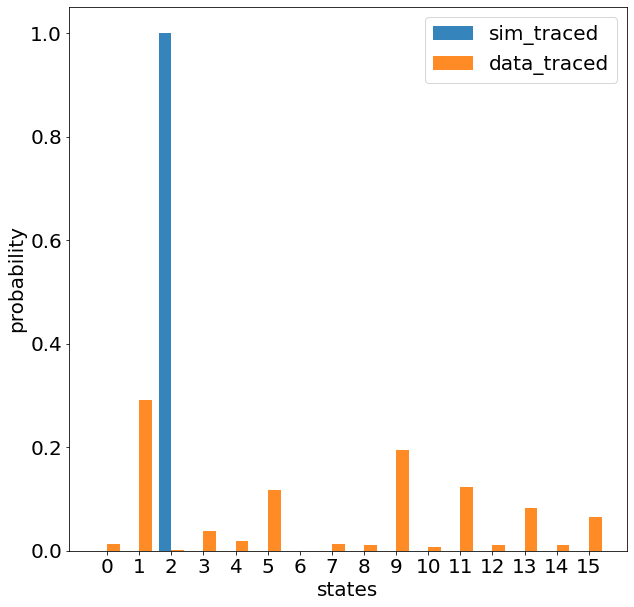

2024-01-15-192516_Line_014.txt
HAD2:RX+51:HAD3:RX+41:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:RY+21:AZ3+1.0000:XA230.2500+:RY+21:RY+31:XA230.2500+:AZ2+1.0000:AZ3+1.0000:XA230.2500+:XA230.2500+:RY+21:RY+31:XA230.2500+:RY+31:XA230.2500+:RX+21:AZ3+1.0000:XA230.2500+:RX+31:XA230.2500+:AZ2+1.0000:AZ3+1.0000:XA230.2500+:RX+21:RX+31:XA230.2500+:RY+21:AZ3+1.0000:XA230.2500+:RY+21:RY+31:XA230.2500+:AZ2+1.0000:AZ3+1.0000:XA230.2500+:RX+21:RX+31:XA230.2500+:XA230.2500+:RY+21:AZ3+1.0000:XA230.2500+:RX+21:RY+31:XA230.2500+:RX+21:RX+31:XA230.2500+:RY+21:AZ3+1.0000:XA230.2500+:RY+31:XA230.2500+:RY+21:RY+31:XA230.2500+:RY+21:XA230.2500+:AZ3+1.0000:XA230.2500+:RX+21:RX+31:XA230.2500+:RY+21:RY+31:XA230.2500+:AZ3+1.0000:XA230.2500+:RY+21:XA230.2500+:AZ2+1.0000:RX+31:XA230.2500+:RX+21:AZ3+1.0000:XA230.2500+:RX+21:RX+31:XA230.2500+:RY+21:RX+31:XA230.2500+:XA230.2500+:RY+21:AZ3+1.0000:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:H

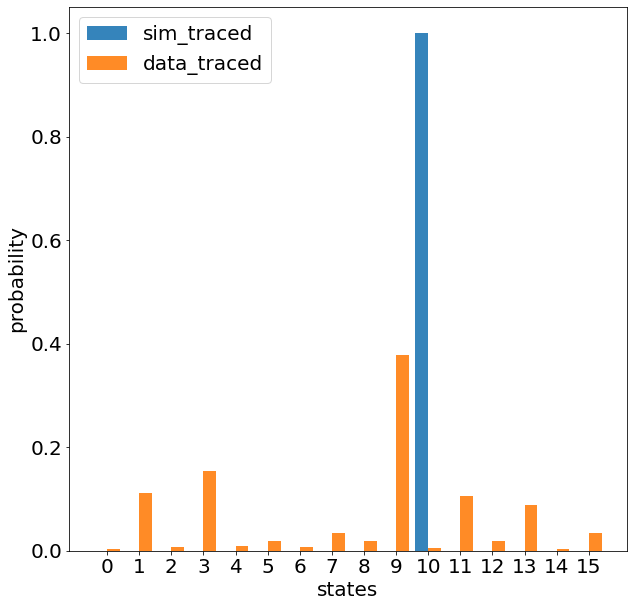

2024-01-15-192655_Line_015.txt
HAD2:RX+51:HAD3:RX+41:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:AZ3+1.0000:XA230.2500+:RX+31:XA230.2500+:AZ2+1.0000:RX+31:XA230.2500+:RX+31:XA230.2500+:AZ2+1.0000:AZ3+1.0000:XA230.2500+:RX+21:RX+31:XA230.2500+:RX+21:AZ3+1.0000:XA230.2500+:AZ2+1.0000:XA230.2500+:RY+31:XA230.2500+:RX+21:RY+31:XA230.2500+:RY+21:RX+31:XA230.2500+:RX+21:RY+31:XA230.2500+:RX+21:RY+31:XA230.2500+:RX+21:XA230.2500+:RY+31:XA230.2500+:AZ2+1.0000:RY+31:XA230.2500+:RY+21:XA230.2500+:AZ2+1.0000:XA230.2500+:XA230.2500+:AZ2+1.0000:AZ3+1.0000:XA230.2500+:AZ2+1.0000:AZ3+1.0000:XA230.2500+:RY+31:XA230.2500+:RX+21:XA230.2500+:RX+21:RY+31:XA230.2500+:RY+21:AZ3+1.0000:XA230.2500+:AZ2+1.0000:RY+31:XA230.2500+:AZ2+1.0000:RY+31:XA230.2500+:RY+21:XA230.2500+:RX+21:RY+31:XA230.2500+:AZ2+1.0000:RX+31:XA230.2500+:AZ2+1.0000:RY+31:XA230.2500+:RY+21:XA230.2500+:RX+21:RY+31:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD

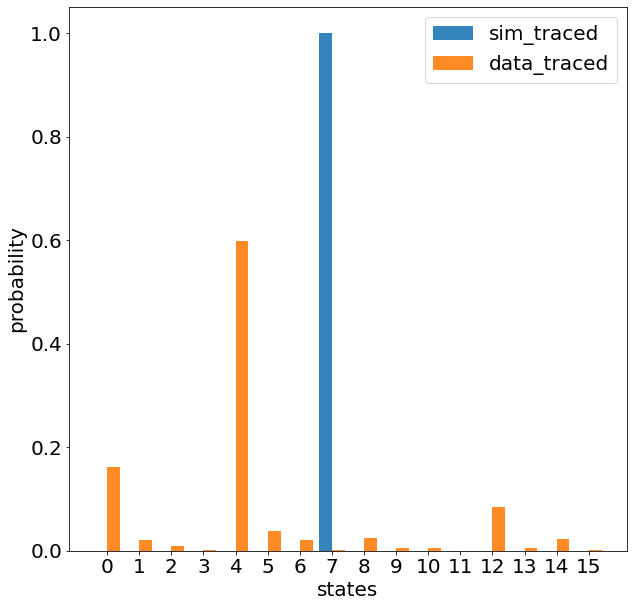

2024-01-15-192834_Line_016.txt
HAD2:RX+51:HAD3:RX+41:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:AZ2+1.0000:RX+31:XA230.2500+:RY+21:RX+31:XA230.2500+:XA230.2500+:RX+21:AZ3+1.0000:XA230.2500+:AZ2+1.0000:RX+31:XA230.2500+:RX+21:RY+31:XA230.2500+:RY+21:RY+31:XA230.2500+:XA230.2500+:RX+21:XA230.2500+:AZ3+1.0000:XA230.2500+:AZ2+1.0000:RX+31:XA230.2500+:AZ2+1.0000:AZ3+1.0000:XA230.2500+:RY+21:RY+31:XA230.2500+:RY+21:XA230.2500+:RX+31:XA230.2500+:RX+21:XA230.2500+:AZ2+1.0000:XA230.2500+:RY+21:AZ3+1.0000:XA230.2500+:XA230.2500+:AZ2+1.0000:AZ3+1.0000:XA230.2500+:RX+21:AZ3+1.0000:XA230.2500+:RY+31:XA230.2500+:AZ2+1.0000:XA230.2500+:RX+31:XA230.2500+:RY+21:RX+31:XA230.2500+:RY+21:RY+31:XA230.2500+:RX+21:RX+31:XA230.2500+:AZ2+1.0000:RX+31:XA230.2500+:RX+21:RX+31:XA230.2500+:RY+21:RY+31:XA230.2500+:RX+21:RY+31:XA230.2500+:RX+31:XA230.2500+:RY+21:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



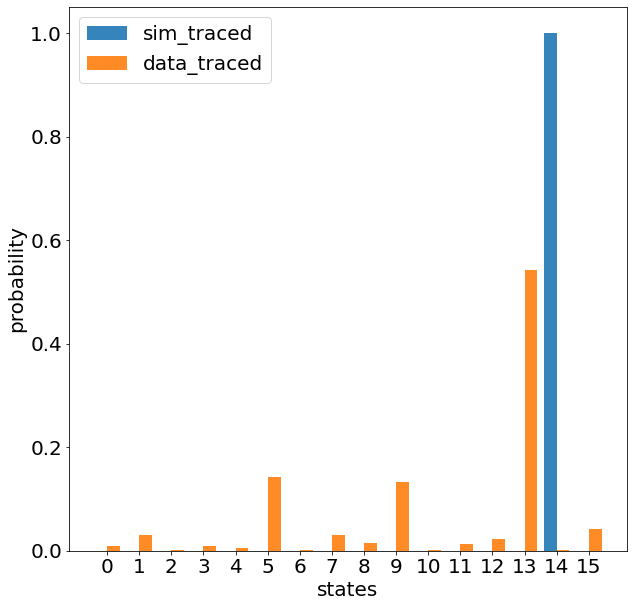

2024-01-15-193048_Line_017.txt
HAD2:RX+51:HAD3:RX+41:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:RY+21:AZ3+1.0000:XA230.2500+:RY+21:AZ3+1.0000:XA230.2500+:RY+21:RY+31:XA230.2500+:RY+21:RX+31:XA230.2500+:RY+31:XA230.2500+:RY+21:XA230.2500+:RX+21:XA230.2500+:RY+21:AZ3+1.0000:XA230.2500+:RY+21:RX+31:XA230.2500+:RX+21:AZ3+1.0000:XA230.2500+:AZ2+1.0000:XA230.2500+:RX+21:RY+31:XA230.2500+:RY+21:AZ3+1.0000:XA230.2500+:RX+21:XA230.2500+:XA230.2500+:AZ3+1.0000:XA230.2500+:AZ3+1.0000:XA230.2500+:AZ2+1.0000:XA230.2500+:RX+21:AZ3+1.0000:XA230.2500+:RX+21:AZ3+1.0000:XA230.2500+:RY+21:RY+31:XA230.2500+:RX+21:XA230.2500+:RX+21:XA230.2500+:AZ2+1.0000:XA230.2500+:XA230.2500+:RX+21:RX+31:XA230.2500+:RY+21:RX+31:XA230.2500+:AZ2+1.0000:RY+31:XA230.2500+:RX+21:AZ3+1.0000:XA230.2500+:RY+21:AZ3+1.0000:XA230.2500+:RX+21:AZ3+1.0000:XA230.2500+:RY+21:XA230.2500+:RY+21:RX+31:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



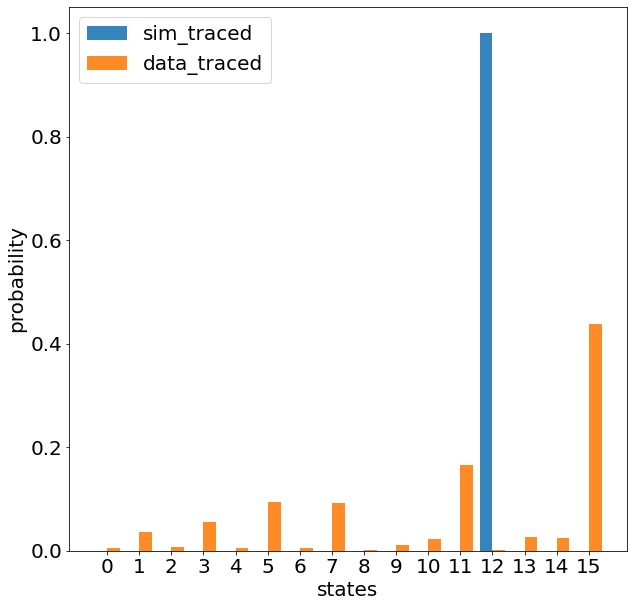

2024-01-15-193223_Line_018.txt
HAD2:RX+51:HAD3:RX+41:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:AZ2+1.0000:RY+31:XA230.2500+:RX+31:XA230.2500+:RX+21:XA230.2500+:AZ2+1.0000:AZ3+1.0000:XA230.2500+:AZ3+1.0000:XA230.2500+:RY+21:AZ3+1.0000:XA230.2500+:RX+21:XA230.2500+:RX+21:XA230.2500+:AZ2+1.0000:RX+31:XA230.2500+:RX+21:RY+31:XA230.2500+:AZ3+1.0000:XA230.2500+:AZ3+1.0000:XA230.2500+:AZ2+1.0000:AZ3+1.0000:XA230.2500+:RX+21:XA230.2500+:RX+21:RY+31:XA230.2500+:AZ2+1.0000:AZ3+1.0000:XA230.2500+:RX+21:XA230.2500+:RX+21:XA230.2500+:AZ2+1.0000:XA230.2500+:RX+21:AZ3+1.0000:XA230.2500+:RY+21:XA230.2500+:RY+21:XA230.2500+:RX+21:RX+31:XA230.2500+:RY+21:RX+31:XA230.2500+:RY+21:XA230.2500+:AZ2+1.0000:XA230.2500+:RY+21:RY+31:XA230.2500+:AZ2+1.0000:RX+31:XA230.2500+:AZ2+1.0000:XA230.2500+:RX+21:AZ3+1.0000:XA230.2500+:RX+21:RX+31:XA230.2500+:AZ2+1.0000:AZ3+1.0000:XA230.2500+:RY+31:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:

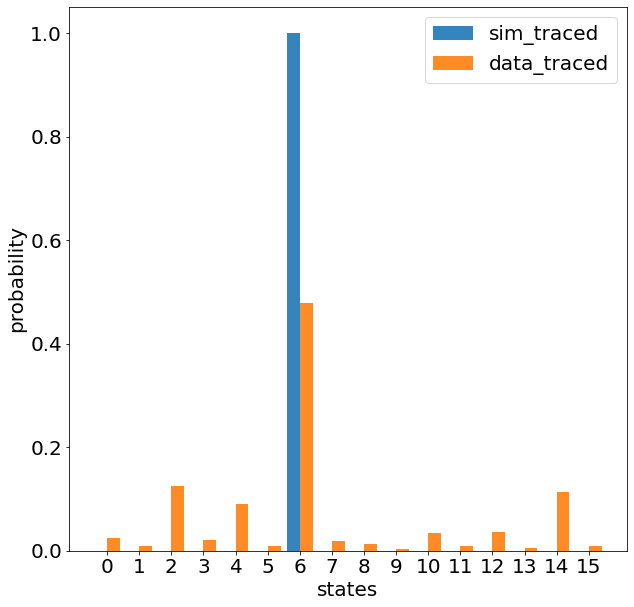

2024-01-15-193401_Line_019.txt
HAD2:RX+51:HAD3:RX+41:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:AZ2+1.0000:RY+31:XA230.2500+:RX+21:AZ3+1.0000:XA230.2500+:AZ2+1.0000:XA230.2500+:RX+21:XA230.2500+:RX+21:XA230.2500+:RX+31:XA230.2500+:RY+31:XA230.2500+:XA230.2500+:AZ2+1.0000:AZ3+1.0000:XA230.2500+:AZ3+1.0000:XA230.2500+:AZ2+1.0000:RY+31:XA230.2500+:RX+21:AZ3+1.0000:XA230.2500+:RX+31:XA230.2500+:RY+21:XA230.2500+:AZ2+1.0000:AZ3+1.0000:XA230.2500+:RY+21:RY+31:XA230.2500+:AZ2+1.0000:XA230.2500+:RX+21:RY+31:XA230.2500+:RY+21:RX+31:XA230.2500+:RX+21:AZ3+1.0000:XA230.2500+:RX+31:XA230.2500+:RY+21:RY+31:XA230.2500+:RX+21:AZ3+1.0000:XA230.2500+:RX+21:RX+31:XA230.2500+:RY+21:RY+31:XA230.2500+:AZ2+1.0000:RX+31:XA230.2500+:RY+21:XA230.2500+:AZ2+1.0000:XA230.2500+:AZ2+1.0000:RX+31:XA230.2500+:RY+21:RY+31:XA230.2500+:RX+21:XA230.2500+:AZ2+1.0000:XA230.2500+:RY+21:RX+31:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



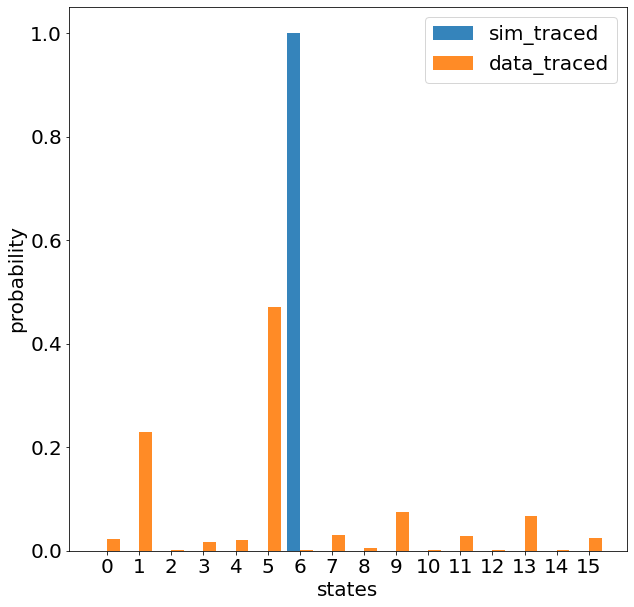

2024-01-15-193617_Line_020.txt
HAD2:RX+51:HAD3:RX+41:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:RX+31:XA230.2500+:RY+21:RY+31:XA230.2500+:RY+21:AZ3+1.0000:XA230.2500+:RY+21:RX+31:XA230.2500+:RX+21:XA230.2500+:AZ2+1.0000:XA230.2500+:RY+21:RY+31:XA230.2500+:AZ2+1.0000:AZ3+1.0000:XA230.2500+:RX+21:RY+31:XA230.2500+:AZ2+1.0000:RX+31:XA230.2500+:RX+21:RY+31:XA230.2500+:AZ3+1.0000:XA230.2500+:RX+21:RY+31:XA230.2500+:AZ2+1.0000:AZ3+1.0000:XA230.2500+:RX+31:XA230.2500+:XA230.2500+:RX+21:RX+31:XA230.2500+:RY+21:AZ3+1.0000:XA230.2500+:AZ2+1.0000:RX+31:XA230.2500+:RY+21:RY+31:XA230.2500+:RX+21:XA230.2500+:RY+21:XA230.2500+:RY+21:XA230.2500+:AZ3+1.0000:XA230.2500+:RY+21:RX+31:XA230.2500+:RY+31:XA230.2500+:RY+21:AZ3+1.0000:XA230.2500+:RY+31:XA230.2500+:RY+21:RX+31:XA230.2500+:RX+31:XA230.2500+:RY+21:RX+31:XA230.2500+:AZ2+1.0000:XA230.2500+:AZ2+1.0000:AZ3+1.0000:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



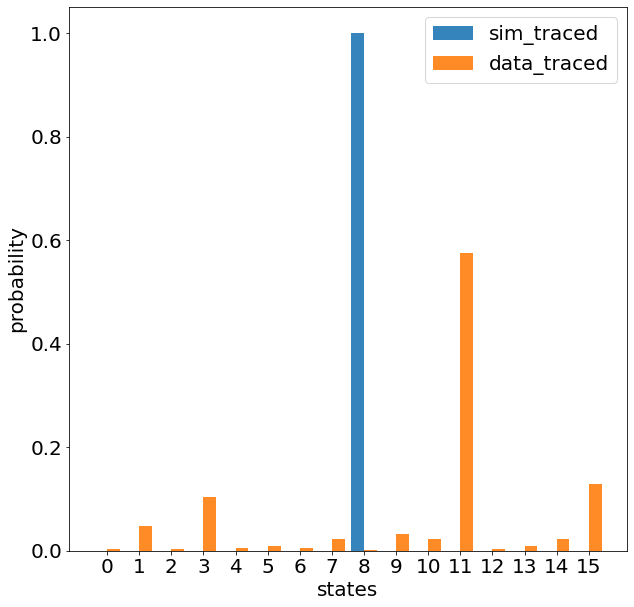

In [16]:
filenames_data=[]
counts_d32=[]
counts_d32_spam=[]
counts=[]
counts_spam=[]
filenames_data=filenames_d32_0115.copy()
print (filenames_data)
# # print (len(filenames_data))
paf_data=paf_data_d32_0115
circuit=c_d32
for i in range (len(filenames_data)):
    print (filenames_data[i])
    a.Import(paf_data+filenames_data[i],keep_file=True)
    data_traced=Trace_Out(a,[0,1,2,3])
    counts=[round(shots*x) for x in  data_traced.population]
    counts_ibm_mapping, counts_ibm_mapping_dic=map_statepop_2_ibm_mapping(counts,nqubit)
    counts_d32.append(counts_ibm_mapping_dic)
    
#     a_s=spam1.Correct_SPAM(a)
#     data_traced_spam=Trace_Out(a_s,[0,1,2,3])
#     counts_spam=[round(shots*x) for x in  data_traced_spam.population]
#     counts_ibm_mapping_spam, counts_ibm_mapping_dic_spam=map_statepop_2_ibm_mapping(counts_spam,nqubit)
#     counts_d8_spam.append(counts_ibm_mapping_dic_spam)
    
    
    b_c.Interpret_GatesLab_Sequence(circuit[i])
    print (circuit[i])
    b=b_c.Simulate()
    sim_traced=Trace_Out(b,[0,1,2,3])
#     Display_States_Population(states=[b,a,a_s],label=["simulation","d=8","spam"])
    Display_States_Population(states=[sim_traced,data_traced],label=["sim_traced","data_traced"])

In [23]:
# print (counts_d2[0])
# print (counts_d2_spam[0])

In [17]:
import copy
from copy import copy, deepcopy
with open("/Volumes/funkflower/Users/Yingyue/Gates_Lab_Suite-master/PauliNoiseEstimation/circuits/XX23541_noSE_explicitCNOT_FT_R0627_01+10/5842626d-f518-4838-a0a2-c93e640ed4ffXX23541_noSE_explicitCNOT_FT_R0627_01+10", "rb") as fp:   # Unpickling
    eab_load = pickle.load(fp)

eab_load_cpy=deepcopy(eab_load[0:100])
eab_load_cpy_spam=deepcopy(eab_load[0:100])

In [18]:
C=20
for i in range (C):
#     print (i)
    assert eab_load_cpy[i]["L"]==2
    print (eab_load_cpy[i]["counts"])
    print (counts_d2_sim[i])

    print (counts_d2[i].copy())
    print ("\n")
    eab_load_cpy[i]["counts"]=counts_d2[i].copy()


    
for i in range (C):
#     print (i)
    assert eab_load_cpy_spam[i]["L"]==2
    eab_load_cpy_spam[i]["counts"]=counts_d2_spam[i].copy()



# for i in range (C):
#     print (eab_load_cpy[i]["counts"])
#     print (eab_load_cpy_spam[i]["counts"])

{'0000': 0, '1000': 0, '0100': 0, '1100': 2000, '0010': 0, '1010': 0, '0110': 0, '1110': 0, '0001': 0, '1001': 0, '0101': 0, '1101': 0, '0011': 0, '1011': 0, '0111': 0, '1111': 0}
{'0000': 0, '1000': 0, '0100': 0, '1100': 2000, '0010': 0, '1010': 0, '0110': 0, '1110': 0, '0001': 0, '1001': 0, '0101': 0, '1101': 0, '0011': 0, '1011': 0, '0111': 0, '1111': 0}
{'0000': 4, '1000': 33, '0100': 39, '1100': 1624, '0010': 2, '1010': 6, '0110': 34, '1110': 91, '0001': 1, '1001': 29, '0101': 5, '1101': 105, '0011': 2, '1011': 5, '0111': 6, '1111': 14}


{'0000': 0, '1000': 0, '0100': 0, '1100': 0, '0010': 2000, '1010': 0, '0110': 0, '1110': 0, '0001': 0, '1001': 0, '0101': 0, '1101': 0, '0011': 0, '1011': 0, '0111': 0, '1111': 0}
{'0000': 0, '1000': 0, '0100': 0, '1100': 0, '0010': 2000, '1010': 0, '0110': 0, '1110': 0, '0001': 0, '1001': 0, '0101': 0, '1101': 0, '0011': 0, '1011': 0, '0111': 0, '1111': 0}
{'0000': 130, '1000': 25, '0100': 4, '1100': 0, '0010': 1737, '1010': 23, '0110': 19, '111

IndexError: list index out of range

In [19]:
for i in range (C,2*C):
#     print (i)
    assert eab_load_cpy[i]["L"]==4
    eab_load_cpy[i]["counts"]=counts_d4[i-C].copy()
#     print ( eab_load_cpy[i]["counts_exp"])
#     print (eab_load_cpy[i]["counts"])
    
# for i in range (C,2*C):
# #     print (i)
#     assert eab_load_cpy_spam[i]["L"]==4
#     eab_load_cpy_spam[i]["counts"]=counts_d4_spam[i-C].copy()

    #     print ( eab_load_cpy[i]["counts_exp"])
#     print (eab_load_cpy_spam[i]["counts"])

# for i in range (C,2*C):
#     print (eab_load_cpy[i]["counts"])
#     print (eab_load_cpy_spam[i]["counts"])    

In [20]:
for i in range (2*C,3*C):
#     print (i)
    assert eab_load_cpy[i]["L"]==8
    eab_load_cpy[i]["counts"]=counts_d8[i-2*C].copy()
#     print ( eab_load_cpy[i]["counts_exp"])
#     print (eab_load_cpy[i])

# for i in range (2*C,3*C):
# #     print (i)
#     assert eab_load_cpy_spam[i]["L"]==8
#     eab_load_cpy_spam[i]["counts"]=counts_d8_spam[i-2*C].copy()

#     print ( eab_load_cpy[i]["counts_exp"])
#     print (eab_load_cpy_spam[i]["counts"])

# for i in range (2*C,3*C):
#     print (eab_load_cpy[i]["counts"])
#     print (eab_load_cpy_spam[i]["counts"])    

In [21]:
# print (eab_load_cpy)

In [22]:
for i in range (3*C,4*C):
#     print (i)
    assert eab_load_cpy[i]["L"]==16
    eab_load_cpy[i]["counts"]=counts_d16[i-3*C].copy()
#     print ( eab_load_cpy[i]["counts_exp"])
#     print (eab_load_cpy[i])

for i in range (4*C,5*C):
#     print (i)
    assert eab_load_cpy[i]["L"]==32
    eab_load_cpy[i]["counts"]=counts_d32[i-4*C].copy()
#     print ( eab_load_cpy[i]["counts_exp"])
#     print (eab_load_cpy[i])

In [23]:
filename = str(uuid.uuid4())
filename+="XX23541_FTXX_identitychannel_01152024_01+10_ExperimentalData"
with open("/Volumes/funkflower/Users/Yingyue/Gates_Lab_Suite-master/PauliNoiseEstimation/data/EAB_identity_channel/results_file/"+filename, "wb") as fp:
    pickle.dump(eab_load_cpy, fp)


Data analysis

plot average fidelity and fit

plot fidelity from each circuit and fit

data analysis with bootstrapping

spam results

In [ ]:

b=[]
c=[1,2]
f=c
c=[1]
print (d)
print (b)
print (c)